In [68]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train
import gc

# Prepare data

In [2]:
fnames = glob('../data/corpus/**.txt')

In [134]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [143]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [146]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [2]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [51]:
_docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(_docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [53]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(_docs[ix])

In [54]:
sim_mat = cosine_similarity(val_vecs, _docs)

In [56]:
best = {}
for i, vec in enumerate(tqdm_notebook(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:00<00:00, 34894.06it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


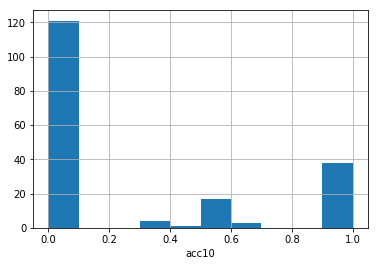

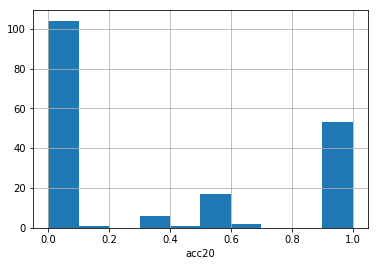

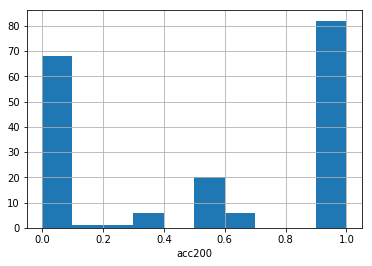

In [58]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# try supervised

In [4]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)
gc.collect()

100%|██████████| 368458/368458 [00:04<00:00, 87415.00it/s] 


0

In [110]:
embedding_size = 300
batch_size = 64
learning_rate = 0.001
sizes=[300, 200]

In [151]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size=batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=True)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:], batch_size)
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            assert not X_train.isnull().values.any()
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.negative
            ], feed_dict = {model.phase: 1, 'X:0': X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-26 14:28:58,490 [MainThread  ] [INFO ]  start training ...
2017-09-26 14:29:01,377 [MainThread  ] [INFO ]  step 0, loss 0.0821286
2017-09-26 14:29:01,401 [MainThread  ] [INFO ]  step 1, loss 0.115811
2017-09-26 14:29:01,527 [MainThread  ] [INFO ]  step 2, loss 0.142324
2017-09-26 14:29:01,551 [MainThread  ] [INFO ]  step 3, loss 0.156378
2017-09-26 14:29:01,571 [MainThread  ] [INFO ]  step 4, loss 0.115542
2017-09-26 14:29:01,590 [MainThread  ] [INFO ]  step 5, loss 0.0787742
2017-09-26 14:29:01,612 [MainThread  ] [INFO ]  step 6, loss 0.0859518
2017-09-26 14:29:01,629 [MainThread  ] [INFO ]  step 7, loss 0.129093
2017-09-26 14:29:01,643 [MainThread  ] [INFO ]  step 8, loss 0.10178
2017-09-26 14:29:01,663 [MainThread  ] [INFO ]  step 9, loss 0.0666589
2017-09-26 14:29:01,681 [MainThread  ] [INFO ]  step 10, loss 0.0996227
2017-09-26 14:29:01,697 [MainThread  ] [INFO ]  step 11, loss 0.119449
2017-09-26 14:29:01,715 [MainThread  ] [INFO ]  step 12, loss 0.11853
2017-09-26 14:29:

2017-09-26 14:29:04,449 [MainThread  ] [INFO ]  step 114, loss 0.0782362
2017-09-26 14:29:04,469 [MainThread  ] [INFO ]  step 115, loss 0.0595795
2017-09-26 14:29:04,486 [MainThread  ] [INFO ]  step 116, loss 0.0483973
2017-09-26 14:29:04,504 [MainThread  ] [INFO ]  step 117, loss 0.0387209
2017-09-26 14:29:04,520 [MainThread  ] [INFO ]  step 118, loss 0.0548356
2017-09-26 14:29:04,642 [MainThread  ] [INFO ]  step 119, loss 0.0937229
2017-09-26 14:29:04,668 [MainThread  ] [INFO ]  step 120, loss 0.0370225
2017-09-26 14:29:04,685 [MainThread  ] [INFO ]  step 121, loss 0.0429572
2017-09-26 14:29:04,704 [MainThread  ] [INFO ]  step 122, loss 0.0707772
2017-09-26 14:29:04,723 [MainThread  ] [INFO ]  step 123, loss 0.0241765
2017-09-26 14:29:04,738 [MainThread  ] [INFO ]  step 124, loss 0.0345521
2017-09-26 14:29:04,756 [MainThread  ] [INFO ]  step 125, loss 0.0639984
2017-09-26 14:29:04,777 [MainThread  ] [INFO ]  step 126, loss 0.0625442
2017-09-26 14:29:04,797 [MainThread  ] [INFO ]  ste

2017-09-26 14:29:07,483 [MainThread  ] [INFO ]  step 227, loss 0.0345778
2017-09-26 14:29:07,504 [MainThread  ] [INFO ]  step 228, loss 0.0239146
2017-09-26 14:29:07,524 [MainThread  ] [INFO ]  step 229, loss 0.0378146
2017-09-26 14:29:07,543 [MainThread  ] [INFO ]  step 230, loss 0.00898448
2017-09-26 14:29:07,563 [MainThread  ] [INFO ]  step 231, loss 0.0241011
2017-09-26 14:29:07,580 [MainThread  ] [INFO ]  step 232, loss 0.0527876
2017-09-26 14:29:07,598 [MainThread  ] [INFO ]  step 233, loss 0.0335103
2017-09-26 14:29:07,615 [MainThread  ] [INFO ]  step 234, loss 0.0789721
2017-09-26 14:29:07,631 [MainThread  ] [INFO ]  step 235, loss 0.0261493
2017-09-26 14:29:07,652 [MainThread  ] [INFO ]  step 236, loss 0.0142087
2017-09-26 14:29:07,670 [MainThread  ] [INFO ]  step 237, loss 0.027113
2017-09-26 14:29:07,794 [MainThread  ] [INFO ]  step 238, loss 0.0628038
2017-09-26 14:29:07,812 [MainThread  ] [INFO ]  step 239, loss 0.0628055
2017-09-26 14:29:07,828 [MainThread  ] [INFO ]  ste

2017-09-26 14:29:10,257 [MainThread  ] [INFO ]  step 340, loss 0.0499599
2017-09-26 14:29:10,275 [MainThread  ] [INFO ]  step 341, loss 0.0476108
2017-09-26 14:29:10,294 [MainThread  ] [INFO ]  step 342, loss 0.034076
2017-09-26 14:29:10,313 [MainThread  ] [INFO ]  step 343, loss 0.0262163
2017-09-26 14:29:10,329 [MainThread  ] [INFO ]  step 344, loss 0.0725356
2017-09-26 14:29:10,347 [MainThread  ] [INFO ]  step 345, loss 0.0428533
2017-09-26 14:29:10,364 [MainThread  ] [INFO ]  step 346, loss 0.077493
2017-09-26 14:29:10,379 [MainThread  ] [INFO ]  step 347, loss 0.055496
2017-09-26 14:29:10,394 [MainThread  ] [INFO ]  step 348, loss 0.0676821
2017-09-26 14:29:10,411 [MainThread  ] [INFO ]  step 349, loss 0.0248042
2017-09-26 14:29:10,425 [MainThread  ] [INFO ]  step 350, loss 0.0413828
2017-09-26 14:29:10,546 [MainThread  ] [INFO ]  step 351, loss 0.045509
2017-09-26 14:29:10,562 [MainThread  ] [INFO ]  step 352, loss 0.044037
2017-09-26 14:29:10,584 [MainThread  ] [INFO ]  step 353

2017-09-26 14:29:13,546 [MainThread  ] [INFO ]  step 453, loss 0.0339105
2017-09-26 14:29:13,558 [MainThread  ] [INFO ]  step 454, loss 0.0137243
2017-09-26 14:29:13,575 [MainThread  ] [INFO ]  step 455, loss 0.0727759
2017-09-26 14:29:13,590 [MainThread  ] [INFO ]  step 456, loss 0.0405241
2017-09-26 14:29:13,605 [MainThread  ] [INFO ]  step 457, loss 0.0200127
2017-09-26 14:29:13,621 [MainThread  ] [INFO ]  step 458, loss 0.0555116
2017-09-26 14:29:13,639 [MainThread  ] [INFO ]  step 459, loss 0.0295934
2017-09-26 14:29:13,758 [MainThread  ] [INFO ]  step 460, loss 0.0498831
2017-09-26 14:29:13,777 [MainThread  ] [INFO ]  step 461, loss 0.0546786
2017-09-26 14:29:13,796 [MainThread  ] [INFO ]  step 462, loss 0.034872
2017-09-26 14:29:13,812 [MainThread  ] [INFO ]  step 463, loss 0.0935609
2017-09-26 14:29:13,832 [MainThread  ] [INFO ]  step 464, loss 0.0240099
2017-09-26 14:29:13,853 [MainThread  ] [INFO ]  step 465, loss 0.00921614
2017-09-26 14:29:13,870 [MainThread  ] [INFO ]  ste

2017-09-26 14:29:17,039 [MainThread  ] [INFO ]  step 566, loss 0.0510018
2017-09-26 14:29:17,056 [MainThread  ] [INFO ]  step 567, loss 0.013076
2017-09-26 14:29:17,077 [MainThread  ] [INFO ]  step 568, loss 0.0412714
2017-09-26 14:29:17,094 [MainThread  ] [INFO ]  step 569, loss 0.0411444
2017-09-26 14:29:17,111 [MainThread  ] [INFO ]  step 570, loss 0.0273661
2017-09-26 14:29:17,127 [MainThread  ] [INFO ]  step 571, loss 0.0680898
2017-09-26 14:29:17,143 [MainThread  ] [INFO ]  step 572, loss 0.0183046
2017-09-26 14:29:17,160 [MainThread  ] [INFO ]  step 573, loss 0.0394423
2017-09-26 14:29:17,189 [MainThread  ] [INFO ]  step 574, loss 0.0288004
2017-09-26 14:29:17,312 [MainThread  ] [INFO ]  step 575, loss 0.0269584
2017-09-26 14:29:17,336 [MainThread  ] [INFO ]  step 576, loss 0.0676005
2017-09-26 14:29:17,457 [MainThread  ] [INFO ]  step 577, loss 0.0587047
2017-09-26 14:29:17,477 [MainThread  ] [INFO ]  step 578, loss 0.0643147
2017-09-26 14:29:17,500 [MainThread  ] [INFO ]  step

2017-09-26 14:29:20,259 [MainThread  ] [INFO ]  step 679, loss 0.0590788
2017-09-26 14:29:20,382 [MainThread  ] [INFO ]  step 680, loss 0.0660954
2017-09-26 14:29:20,399 [MainThread  ] [INFO ]  step 681, loss 0.0314052
2017-09-26 14:29:20,414 [MainThread  ] [INFO ]  step 682, loss 0.0601105
2017-09-26 14:29:20,431 [MainThread  ] [INFO ]  step 683, loss 0.0429975
2017-09-26 14:29:20,447 [MainThread  ] [INFO ]  step 684, loss 0.0162191
2017-09-26 14:29:20,464 [MainThread  ] [INFO ]  step 685, loss 0.0304903
2017-09-26 14:29:20,480 [MainThread  ] [INFO ]  step 686, loss 0.0802428
2017-09-26 14:29:20,502 [MainThread  ] [INFO ]  step 687, loss 0.0153275
2017-09-26 14:29:20,520 [MainThread  ] [INFO ]  step 688, loss 0.0221225
2017-09-26 14:29:20,537 [MainThread  ] [INFO ]  step 689, loss 0.0431928
2017-09-26 14:29:20,553 [MainThread  ] [INFO ]  step 690, loss 0.0274842
2017-09-26 14:29:20,570 [MainThread  ] [INFO ]  step 691, loss 0.0404316
2017-09-26 14:29:20,693 [MainThread  ] [INFO ]  ste

2017-09-26 14:29:23,362 [MainThread  ] [INFO ]  step 792, loss 0.0578777
2017-09-26 14:29:23,380 [MainThread  ] [INFO ]  step 793, loss 0.0663739
2017-09-26 14:29:23,501 [MainThread  ] [INFO ]  step 794, loss 0.083216
2017-09-26 14:29:23,520 [MainThread  ] [INFO ]  step 795, loss 0.04656
2017-09-26 14:29:23,540 [MainThread  ] [INFO ]  step 796, loss 0.0296766
2017-09-26 14:29:23,558 [MainThread  ] [INFO ]  step 797, loss 0.00719131
2017-09-26 14:29:23,575 [MainThread  ] [INFO ]  step 798, loss 0.0669574
2017-09-26 14:29:23,693 [MainThread  ] [INFO ]  step 799, loss 0.0488402
2017-09-26 14:29:23,710 [MainThread  ] [INFO ]  step 800, loss 0.023686
2017-09-26 14:29:23,725 [MainThread  ] [INFO ]  step 801, loss 0.0458652
2017-09-26 14:29:23,740 [MainThread  ] [INFO ]  step 802, loss 0.0355343
2017-09-26 14:29:23,756 [MainThread  ] [INFO ]  step 803, loss 0.0541794
2017-09-26 14:29:23,773 [MainThread  ] [INFO ]  step 804, loss 0.0210473
2017-09-26 14:29:23,794 [MainThread  ] [INFO ]  step 8

2017-09-26 14:29:27,305 [MainThread  ] [INFO ]  step 905, loss 0.0428332
2017-09-26 14:29:27,323 [MainThread  ] [INFO ]  step 906, loss 0.051795
2017-09-26 14:29:27,338 [MainThread  ] [INFO ]  step 907, loss 0.0255833
2017-09-26 14:29:27,352 [MainThread  ] [INFO ]  step 908, loss 0.0346016
2017-09-26 14:29:27,367 [MainThread  ] [INFO ]  step 909, loss 0.0357584
2017-09-26 14:29:27,380 [MainThread  ] [INFO ]  step 910, loss 0.0107965
2017-09-26 14:29:27,396 [MainThread  ] [INFO ]  step 911, loss 0.060757
2017-09-26 14:29:27,520 [MainThread  ] [INFO ]  step 912, loss 0.0303834
2017-09-26 14:29:27,541 [MainThread  ] [INFO ]  step 913, loss 0.0168047
2017-09-26 14:29:27,559 [MainThread  ] [INFO ]  step 914, loss 0.0359554
2017-09-26 14:29:27,574 [MainThread  ] [INFO ]  step 915, loss 0.0250774
2017-09-26 14:29:27,589 [MainThread  ] [INFO ]  step 916, loss 0.0358408
2017-09-26 14:29:27,605 [MainThread  ] [INFO ]  step 917, loss 0.0214363
2017-09-26 14:29:27,623 [MainThread  ] [INFO ]  step 

2017-09-26 14:29:30,366 [MainThread  ] [INFO ]  step 1018, loss 0.0913233
2017-09-26 14:29:30,382 [MainThread  ] [INFO ]  step 1019, loss 0.0533005
2017-09-26 14:29:30,396 [MainThread  ] [INFO ]  step 1020, loss 0.0240526
2017-09-26 14:29:30,410 [MainThread  ] [INFO ]  step 1021, loss 0.0572743
2017-09-26 14:29:30,428 [MainThread  ] [INFO ]  step 1022, loss 0.0444616
2017-09-26 14:29:30,445 [MainThread  ] [INFO ]  step 1023, loss 0.0544684
2017-09-26 14:29:30,460 [MainThread  ] [INFO ]  step 1024, loss 0.0512549
2017-09-26 14:29:30,478 [MainThread  ] [INFO ]  step 1025, loss 0.0266842
2017-09-26 14:29:30,492 [MainThread  ] [INFO ]  step 1026, loss 0.0162645
2017-09-26 14:29:30,508 [MainThread  ] [INFO ]  step 1027, loss 0.0430129
2017-09-26 14:29:30,523 [MainThread  ] [INFO ]  step 1028, loss 0.0299317
2017-09-26 14:29:30,540 [MainThread  ] [INFO ]  step 1029, loss 0.0427614
2017-09-26 14:29:30,556 [MainThread  ] [INFO ]  step 1030, loss 0.02176
2017-09-26 14:29:30,571 [MainThread  ] [

2017-09-26 14:29:32,647 [MainThread  ] [INFO ]  step 1129, loss 0.0331174
2017-09-26 14:29:32,662 [MainThread  ] [INFO ]  step 1130, loss 0.0226126
2017-09-26 14:29:32,678 [MainThread  ] [INFO ]  step 1131, loss 0.0559945
2017-09-26 14:29:32,820 [MainThread  ] [INFO ]  step 1132, loss 0.0133744
2017-09-26 14:29:32,840 [MainThread  ] [INFO ]  step 1133, loss 0.0278467
2017-09-26 14:29:32,860 [MainThread  ] [INFO ]  step 1134, loss 0.0479739
2017-09-26 14:29:32,874 [MainThread  ] [INFO ]  step 1135, loss 0.0429098
2017-09-26 14:29:32,890 [MainThread  ] [INFO ]  step 1136, loss 0.0319125
2017-09-26 14:29:33,010 [MainThread  ] [INFO ]  step 1137, loss 0.0274543
2017-09-26 14:29:33,032 [MainThread  ] [INFO ]  step 1138, loss 0.0361119
2017-09-26 14:29:33,049 [MainThread  ] [INFO ]  step 1139, loss 0.0370809
2017-09-26 14:29:33,064 [MainThread  ] [INFO ]  step 1140, loss 0.0219386
2017-09-26 14:29:33,080 [MainThread  ] [INFO ]  step 1141, loss 0.0354013
2017-09-26 14:29:33,096 [MainThread  ]

2017-09-26 14:29:36,229 [MainThread  ] [INFO ]  step 1240, loss 0.0240662
2017-09-26 14:29:36,244 [MainThread  ] [INFO ]  step 1241, loss 0.0536439
2017-09-26 14:29:36,261 [MainThread  ] [INFO ]  step 1242, loss 0.0100816
2017-09-26 14:29:36,385 [MainThread  ] [INFO ]  step 1243, loss 0.0225335
2017-09-26 14:29:36,402 [MainThread  ] [INFO ]  step 1244, loss 0.0528475
2017-09-26 14:29:36,423 [MainThread  ] [INFO ]  step 1245, loss 0.0466754
2017-09-26 14:29:36,439 [MainThread  ] [INFO ]  step 1246, loss 0.0646321
2017-09-26 14:29:36,455 [MainThread  ] [INFO ]  step 1247, loss 0.0258109
2017-09-26 14:29:36,474 [MainThread  ] [INFO ]  step 1248, loss 0.010229
2017-09-26 14:29:36,490 [MainThread  ] [INFO ]  step 1249, loss 0.035707
2017-09-26 14:29:36,511 [MainThread  ] [INFO ]  step 1250, loss 0.0216498
2017-09-26 14:29:36,532 [MainThread  ] [INFO ]  step 1251, loss 0.0162806
2017-09-26 14:29:36,547 [MainThread  ] [INFO ]  step 1252, loss 0.045533
2017-09-26 14:29:36,565 [MainThread  ] [I

2017-09-26 14:29:38,768 [MainThread  ] [INFO ]  step 1351, loss 0.0397606
2017-09-26 14:29:38,791 [MainThread  ] [INFO ]  step 1352, loss 0.0120565
2017-09-26 14:29:38,810 [MainThread  ] [INFO ]  step 1353, loss 0.02799
2017-09-26 14:29:38,830 [MainThread  ] [INFO ]  step 1354, loss 0.0522612
2017-09-26 14:29:38,843 [MainThread  ] [INFO ]  step 1355, loss 0.0621481
2017-09-26 14:29:38,858 [MainThread  ] [INFO ]  step 1356, loss 0.016115
2017-09-26 14:29:38,976 [MainThread  ] [INFO ]  step 1357, loss 0.0356513
2017-09-26 14:29:38,995 [MainThread  ] [INFO ]  step 1358, loss 0.0499248
2017-09-26 14:29:39,014 [MainThread  ] [INFO ]  step 1359, loss 0.0273647
2017-09-26 14:29:39,030 [MainThread  ] [INFO ]  step 1360, loss 0.0419785
2017-09-26 14:29:39,045 [MainThread  ] [INFO ]  step 1361, loss 0.0328963
2017-09-26 14:29:39,061 [MainThread  ] [INFO ]  step 1362, loss 0.0285065
2017-09-26 14:29:39,076 [MainThread  ] [INFO ]  step 1363, loss 0.0215071
2017-09-26 14:29:39,092 [MainThread  ] [I

2017-09-26 14:29:42,022 [MainThread  ] [INFO ]  step 1462, loss 0.016864
2017-09-26 14:29:42,041 [MainThread  ] [INFO ]  step 1463, loss 0.0234651
2017-09-26 14:29:42,161 [MainThread  ] [INFO ]  step 1464, loss 0.0137594
2017-09-26 14:29:42,179 [MainThread  ] [INFO ]  step 1465, loss 0.0480726
2017-09-26 14:29:42,301 [MainThread  ] [INFO ]  step 1466, loss 0.0559721
2017-09-26 14:29:42,318 [MainThread  ] [INFO ]  step 1467, loss 0.0316308
2017-09-26 14:29:42,336 [MainThread  ] [INFO ]  step 1468, loss 0.0145347
2017-09-26 14:29:42,353 [MainThread  ] [INFO ]  step 1469, loss 0.042299
2017-09-26 14:29:42,372 [MainThread  ] [INFO ]  step 1470, loss 0.0978855
2017-09-26 14:29:42,500 [MainThread  ] [INFO ]  step 1471, loss 0.055304
2017-09-26 14:29:42,515 [MainThread  ] [INFO ]  step 1472, loss 0.0279406
2017-09-26 14:29:42,527 [MainThread  ] [INFO ]  step 1473, loss 0.0404665
2017-09-26 14:29:42,543 [MainThread  ] [INFO ]  step 1474, loss 0.0316682
2017-09-26 14:29:42,561 [MainThread  ] [I

2017-09-26 14:29:45,233 [MainThread  ] [INFO ]  step 1573, loss 0.0349056
2017-09-26 14:29:45,355 [MainThread  ] [INFO ]  step 1574, loss 0.0362877
2017-09-26 14:29:45,370 [MainThread  ] [INFO ]  step 1575, loss 0.0478626
2017-09-26 14:29:45,389 [MainThread  ] [INFO ]  step 1576, loss 0.0399608
2017-09-26 14:29:45,509 [MainThread  ] [INFO ]  step 1577, loss 0.0225346
2017-09-26 14:29:45,636 [MainThread  ] [INFO ]  step 1578, loss 0.0455982
2017-09-26 14:29:45,659 [MainThread  ] [INFO ]  step 1579, loss 0.0206006
2017-09-26 14:29:45,675 [MainThread  ] [INFO ]  step 1580, loss 0.0225895
2017-09-26 14:29:45,792 [MainThread  ] [INFO ]  step 1581, loss 0.0289699
2017-09-26 14:29:45,809 [MainThread  ] [INFO ]  step 1582, loss 0.0179195
2017-09-26 14:29:45,827 [MainThread  ] [INFO ]  step 1583, loss 0.0223361
2017-09-26 14:29:45,844 [MainThread  ] [INFO ]  step 1584, loss 0.0302174
2017-09-26 14:29:45,861 [MainThread  ] [INFO ]  step 1585, loss 0.061819
2017-09-26 14:29:45,876 [MainThread  ] 

2017-09-26 14:29:48,334 [MainThread  ] [INFO ]  step 1684, loss 0.0920477
2017-09-26 14:29:48,352 [MainThread  ] [INFO ]  step 1685, loss 0.00115905
2017-09-26 14:29:48,370 [MainThread  ] [INFO ]  step 1686, loss 0.0168813
2017-09-26 14:29:48,388 [MainThread  ] [INFO ]  step 1687, loss 0.0520588
2017-09-26 14:29:48,403 [MainThread  ] [INFO ]  step 1688, loss 0.0154019
2017-09-26 14:29:48,418 [MainThread  ] [INFO ]  step 1689, loss 0.0202251
2017-09-26 14:29:48,434 [MainThread  ] [INFO ]  step 1690, loss 0.0305161
2017-09-26 14:29:48,449 [MainThread  ] [INFO ]  step 1691, loss 0.0545381
2017-09-26 14:29:48,463 [MainThread  ] [INFO ]  step 1692, loss 0.0115263
2017-09-26 14:29:48,480 [MainThread  ] [INFO ]  step 1693, loss 0.0508766
2017-09-26 14:29:48,496 [MainThread  ] [INFO ]  step 1694, loss 0.0555299
2017-09-26 14:29:48,511 [MainThread  ] [INFO ]  step 1695, loss 0.0419704
2017-09-26 14:29:48,526 [MainThread  ] [INFO ]  step 1696, loss 0.0417187
2017-09-26 14:29:48,541 [MainThread  

2017-09-26 14:29:50,508 [MainThread  ] [INFO ]  step 1795, loss 0.0444077
2017-09-26 14:29:50,525 [MainThread  ] [INFO ]  step 1796, loss 0.0749228
2017-09-26 14:29:50,545 [MainThread  ] [INFO ]  step 1797, loss 0.0352423
2017-09-26 14:29:50,559 [MainThread  ] [INFO ]  step 1798, loss 0.032799
2017-09-26 14:29:50,574 [MainThread  ] [INFO ]  step 1799, loss 0.0388393
2017-09-26 14:29:50,589 [MainThread  ] [INFO ]  step 1800, loss 0.0568107
2017-09-26 14:29:50,605 [MainThread  ] [INFO ]  step 1801, loss 0.0159894
2017-09-26 14:29:50,625 [MainThread  ] [INFO ]  step 1802, loss 0.0757751
2017-09-26 14:29:50,746 [MainThread  ] [INFO ]  step 1803, loss 0.0127538
2017-09-26 14:29:50,867 [MainThread  ] [INFO ]  step 1804, loss 0.0251065
2017-09-26 14:29:50,886 [MainThread  ] [INFO ]  step 1805, loss 0.0420234
2017-09-26 14:29:50,905 [MainThread  ] [INFO ]  step 1806, loss 0.035599
2017-09-26 14:29:50,921 [MainThread  ] [INFO ]  step 1807, loss 0.0562172
2017-09-26 14:29:50,941 [MainThread  ] [

2017-09-26 14:29:53,453 [MainThread  ] [INFO ]  step 1906, loss 0.0512939
2017-09-26 14:29:53,470 [MainThread  ] [INFO ]  step 1907, loss 0.0318253
2017-09-26 14:29:53,486 [MainThread  ] [INFO ]  step 1908, loss 0.026336
2017-09-26 14:29:53,503 [MainThread  ] [INFO ]  step 1909, loss 0.017438
2017-09-26 14:29:53,520 [MainThread  ] [INFO ]  step 1910, loss 0.0400036
2017-09-26 14:29:53,537 [MainThread  ] [INFO ]  step 1911, loss 0.0180267
2017-09-26 14:29:53,555 [MainThread  ] [INFO ]  step 1912, loss 0.048658
2017-09-26 14:29:53,571 [MainThread  ] [INFO ]  step 1913, loss 0.0358662
2017-09-26 14:29:53,587 [MainThread  ] [INFO ]  step 1914, loss 0.0117361
2017-09-26 14:29:53,604 [MainThread  ] [INFO ]  step 1915, loss 0.021447
2017-09-26 14:29:53,619 [MainThread  ] [INFO ]  step 1916, loss 0.0674223
2017-09-26 14:29:53,635 [MainThread  ] [INFO ]  step 1917, loss 0.0309309
2017-09-26 14:29:53,652 [MainThread  ] [INFO ]  step 1918, loss 0.0536436
2017-09-26 14:29:53,670 [MainThread  ] [IN

2017-09-26 14:29:56,770 [MainThread  ] [INFO ]  step 2017, loss 0.0340804
2017-09-26 14:29:56,787 [MainThread  ] [INFO ]  step 2018, loss 0.0421769
2017-09-26 14:29:56,802 [MainThread  ] [INFO ]  step 2019, loss 0.0318957
2017-09-26 14:29:56,820 [MainThread  ] [INFO ]  step 2020, loss 0.0370423
2017-09-26 14:29:56,835 [MainThread  ] [INFO ]  step 2021, loss 0.068024
2017-09-26 14:29:56,859 [MainThread  ] [INFO ]  step 2022, loss 0.028889
2017-09-26 14:29:56,980 [MainThread  ] [INFO ]  step 2023, loss 0.0477536
2017-09-26 14:29:56,995 [MainThread  ] [INFO ]  step 2024, loss 0.0409592
2017-09-26 14:29:57,011 [MainThread  ] [INFO ]  step 2025, loss 0.055939
2017-09-26 14:29:57,027 [MainThread  ] [INFO ]  step 2026, loss 0.0489628
2017-09-26 14:29:57,044 [MainThread  ] [INFO ]  step 2027, loss 0.0327598
2017-09-26 14:29:57,060 [MainThread  ] [INFO ]  step 2028, loss 0.00517534
2017-09-26 14:29:57,076 [MainThread  ] [INFO ]  step 2029, loss 0.00251023
2017-09-26 14:29:57,092 [MainThread  ] 

2017-09-26 14:29:59,936 [MainThread  ] [INFO ]  step 2128, loss 0.00681527
2017-09-26 14:29:59,954 [MainThread  ] [INFO ]  step 2129, loss 0.0345343
2017-09-26 14:29:59,972 [MainThread  ] [INFO ]  step 2130, loss 0.0325237
2017-09-26 14:29:59,988 [MainThread  ] [INFO ]  step 2131, loss 0.00945883
2017-09-26 14:30:00,004 [MainThread  ] [INFO ]  step 2132, loss 0.0649088
2017-09-26 14:30:00,024 [MainThread  ] [INFO ]  step 2133, loss 0.0490482
2017-09-26 14:30:00,039 [MainThread  ] [INFO ]  step 2134, loss 0.032512
2017-09-26 14:30:00,058 [MainThread  ] [INFO ]  step 2135, loss 0.0176439
2017-09-26 14:30:00,072 [MainThread  ] [INFO ]  step 2136, loss 0.0190974
2017-09-26 14:30:00,087 [MainThread  ] [INFO ]  step 2137, loss 0.0233715
2017-09-26 14:30:00,107 [MainThread  ] [INFO ]  step 2138, loss 0.013016
2017-09-26 14:30:00,123 [MainThread  ] [INFO ]  step 2139, loss 0.0429648
2017-09-26 14:30:00,141 [MainThread  ] [INFO ]  step 2140, loss 0.0509585
2017-09-26 14:30:00,157 [MainThread  ]

2017-09-26 14:30:02,442 [MainThread  ] [INFO ]  step 2239, loss 0.0247307
2017-09-26 14:30:02,463 [MainThread  ] [INFO ]  step 2240, loss 0.0513049
2017-09-26 14:30:02,483 [MainThread  ] [INFO ]  step 2241, loss 0.0332642
2017-09-26 14:30:02,503 [MainThread  ] [INFO ]  step 2242, loss 0.0376554
2017-09-26 14:30:02,521 [MainThread  ] [INFO ]  step 2243, loss 0.0072657
2017-09-26 14:30:02,537 [MainThread  ] [INFO ]  step 2244, loss 0.0430693
2017-09-26 14:30:02,665 [MainThread  ] [INFO ]  step 2245, loss 0.00762721
2017-09-26 14:30:02,681 [MainThread  ] [INFO ]  step 2246, loss 0.0361753
2017-09-26 14:30:02,700 [MainThread  ] [INFO ]  step 2247, loss 0.0340894
2017-09-26 14:30:02,819 [MainThread  ] [INFO ]  step 2248, loss 0.0295162
2017-09-26 14:30:02,833 [MainThread  ] [INFO ]  step 2249, loss 0.0898361
2017-09-26 14:30:02,850 [MainThread  ] [INFO ]  step 2250, loss 0.01622
2017-09-26 14:30:02,870 [MainThread  ] [INFO ]  step 2251, loss 0.00781743
2017-09-26 14:30:02,889 [MainThread  ]

2017-09-26 14:30:05,362 [MainThread  ] [INFO ]  step 2350, loss 0.0355827
2017-09-26 14:30:05,379 [MainThread  ] [INFO ]  step 2351, loss 0.0320985
2017-09-26 14:30:05,396 [MainThread  ] [INFO ]  step 2352, loss 0.0263724
2017-09-26 14:30:05,516 [MainThread  ] [INFO ]  step 2353, loss 0.0615424
2017-09-26 14:30:05,534 [MainThread  ] [INFO ]  step 2354, loss 0.0422433
2017-09-26 14:30:05,551 [MainThread  ] [INFO ]  step 2355, loss 0.0541921
2017-09-26 14:30:05,567 [MainThread  ] [INFO ]  step 2356, loss 0.0069547
2017-09-26 14:30:05,583 [MainThread  ] [INFO ]  step 2357, loss 0.0353816
2017-09-26 14:30:05,597 [MainThread  ] [INFO ]  step 2358, loss 0.0416338
2017-09-26 14:30:05,615 [MainThread  ] [INFO ]  step 2359, loss 0.0477791
2017-09-26 14:30:05,630 [MainThread  ] [INFO ]  step 2360, loss 0.0770783
2017-09-26 14:30:05,646 [MainThread  ] [INFO ]  step 2361, loss 0.0210296
2017-09-26 14:30:05,660 [MainThread  ] [INFO ]  step 2362, loss 0.0615281
2017-09-26 14:30:05,675 [MainThread  ]

2017-09-26 14:30:08,932 [MainThread  ] [INFO ]  step 2461, loss 0.0226572
2017-09-26 14:30:08,949 [MainThread  ] [INFO ]  step 2462, loss 0.0502631
2017-09-26 14:30:08,964 [MainThread  ] [INFO ]  step 2463, loss 0.0256449
2017-09-26 14:30:08,977 [MainThread  ] [INFO ]  step 2464, loss 0.0236462
2017-09-26 14:30:09,093 [MainThread  ] [INFO ]  step 2465, loss 0.0281293
2017-09-26 14:30:09,108 [MainThread  ] [INFO ]  step 2466, loss 0.0268156
2017-09-26 14:30:09,124 [MainThread  ] [INFO ]  step 2467, loss 0.0170046
2017-09-26 14:30:09,144 [MainThread  ] [INFO ]  step 2468, loss 0.0796574
2017-09-26 14:30:09,161 [MainThread  ] [INFO ]  step 2469, loss 0.019492
2017-09-26 14:30:09,183 [MainThread  ] [INFO ]  step 2470, loss 0.0137542
2017-09-26 14:30:09,198 [MainThread  ] [INFO ]  step 2471, loss 0.0188099
2017-09-26 14:30:09,318 [MainThread  ] [INFO ]  step 2472, loss 0.101259
2017-09-26 14:30:09,440 [MainThread  ] [INFO ]  step 2473, loss 0.0400148
2017-09-26 14:30:09,454 [MainThread  ] [

2017-09-26 14:30:12,237 [MainThread  ] [INFO ]  step 2572, loss 0.0157113
2017-09-26 14:30:12,253 [MainThread  ] [INFO ]  step 2573, loss 0.0180733
2017-09-26 14:30:12,269 [MainThread  ] [INFO ]  step 2574, loss 0.0327604
2017-09-26 14:30:12,285 [MainThread  ] [INFO ]  step 2575, loss 0.0284181
2017-09-26 14:30:12,304 [MainThread  ] [INFO ]  step 2576, loss 0.0235268
2017-09-26 14:30:12,323 [MainThread  ] [INFO ]  step 2577, loss 0.0185764
2017-09-26 14:30:12,339 [MainThread  ] [INFO ]  step 2578, loss 0.0594388
2017-09-26 14:30:12,355 [MainThread  ] [INFO ]  step 2579, loss 0.0358779
2017-09-26 14:30:12,387 [MainThread  ] [INFO ]  step 2580, loss 0.0307349
2017-09-26 14:30:12,412 [MainThread  ] [INFO ]  step 2581, loss 0.02118
2017-09-26 14:30:12,428 [MainThread  ] [INFO ]  step 2582, loss 0.0163388
2017-09-26 14:30:12,452 [MainThread  ] [INFO ]  step 2583, loss 0.0552759
2017-09-26 14:30:12,586 [MainThread  ] [INFO ]  step 2584, loss 0.0210295
2017-09-26 14:30:12,606 [MainThread  ] [

2017-09-26 14:30:15,676 [MainThread  ] [INFO ]  step 2683, loss 0.0321889
2017-09-26 14:30:15,691 [MainThread  ] [INFO ]  step 2684, loss 0.0407934
2017-09-26 14:30:15,708 [MainThread  ] [INFO ]  step 2685, loss 0.00920625
2017-09-26 14:30:15,729 [MainThread  ] [INFO ]  step 2686, loss 0.0402318
2017-09-26 14:30:15,746 [MainThread  ] [INFO ]  step 2687, loss 0.0316969
2017-09-26 14:30:15,764 [MainThread  ] [INFO ]  step 2688, loss 0.019267
2017-09-26 14:30:15,782 [MainThread  ] [INFO ]  step 2689, loss 0.0326195
2017-09-26 14:30:15,796 [MainThread  ] [INFO ]  step 2690, loss 0.0521032
2017-09-26 14:30:15,808 [MainThread  ] [INFO ]  step 2691, loss 0.0406439
2017-09-26 14:30:15,821 [MainThread  ] [INFO ]  step 2692, loss 0.0284918
2017-09-26 14:30:15,834 [MainThread  ] [INFO ]  step 2693, loss 0.0596738
2017-09-26 14:30:15,848 [MainThread  ] [INFO ]  step 2694, loss 0.00561853
2017-09-26 14:30:15,862 [MainThread  ] [INFO ]  step 2695, loss 0.0358621
2017-09-26 14:30:15,875 [MainThread  

2017-09-26 14:30:17,925 [MainThread  ] [INFO ]  step 2794, loss 0.0269409
2017-09-26 14:30:17,944 [MainThread  ] [INFO ]  step 2795, loss 0.0537019
2017-09-26 14:30:17,961 [MainThread  ] [INFO ]  step 2796, loss 0.0256785
2017-09-26 14:30:17,978 [MainThread  ] [INFO ]  step 2797, loss 0.0135261
2017-09-26 14:30:18,107 [MainThread  ] [INFO ]  step 2798, loss 0.0404334
2017-09-26 14:30:18,122 [MainThread  ] [INFO ]  step 2799, loss 0.0568076
2017-09-26 14:30:18,143 [MainThread  ] [INFO ]  step 2800, loss 0.0602903
2017-09-26 14:30:18,164 [MainThread  ] [INFO ]  step 2801, loss 0.0152692
2017-09-26 14:30:18,183 [MainThread  ] [INFO ]  step 2802, loss 0.0544715
2017-09-26 14:30:18,199 [MainThread  ] [INFO ]  step 2803, loss 0.0318571
2017-09-26 14:30:18,215 [MainThread  ] [INFO ]  step 2804, loss 0.0194946
2017-09-26 14:30:18,232 [MainThread  ] [INFO ]  step 2805, loss 0.0381056
2017-09-26 14:30:18,247 [MainThread  ] [INFO ]  step 2806, loss 0.0517204
2017-09-26 14:30:18,262 [MainThread  ]

2017-09-26 14:30:20,983 [MainThread  ] [INFO ]  step 2905, loss 0.0209054
2017-09-26 14:30:21,001 [MainThread  ] [INFO ]  step 2906, loss 0.0264576
2017-09-26 14:30:21,126 [MainThread  ] [INFO ]  step 2907, loss 0.0333067
2017-09-26 14:30:21,249 [MainThread  ] [INFO ]  step 2908, loss 0.0372392
2017-09-26 14:30:21,266 [MainThread  ] [INFO ]  step 2909, loss 0.0166441
2017-09-26 14:30:21,286 [MainThread  ] [INFO ]  step 2910, loss 0.0193556
2017-09-26 14:30:21,301 [MainThread  ] [INFO ]  step 2911, loss 0.0628251
2017-09-26 14:30:21,320 [MainThread  ] [INFO ]  step 2912, loss 0.06496
2017-09-26 14:30:21,339 [MainThread  ] [INFO ]  step 2913, loss 0.0316187
2017-09-26 14:30:21,358 [MainThread  ] [INFO ]  step 2914, loss 0.0376436
2017-09-26 14:30:21,375 [MainThread  ] [INFO ]  step 2915, loss 0.0165431
2017-09-26 14:30:21,391 [MainThread  ] [INFO ]  step 2916, loss 0.0103063
2017-09-26 14:30:21,406 [MainThread  ] [INFO ]  step 2917, loss 0.0303881
2017-09-26 14:30:21,425 [MainThread  ] [

2017-09-26 14:30:24,249 [MainThread  ] [INFO ]  step 3016, loss 0.0341246
2017-09-26 14:30:24,370 [MainThread  ] [INFO ]  step 3017, loss 0.0126125
2017-09-26 14:30:24,391 [MainThread  ] [INFO ]  step 3018, loss 0.0303251
2017-09-26 14:30:24,421 [MainThread  ] [INFO ]  step 3019, loss 0.0322947
2017-09-26 14:30:24,442 [MainThread  ] [INFO ]  step 3020, loss 0.0268183
2017-09-26 14:30:24,464 [MainThread  ] [INFO ]  step 3021, loss 0.0248608
2017-09-26 14:30:24,484 [MainThread  ] [INFO ]  step 3022, loss 0.0361712
2017-09-26 14:30:24,502 [MainThread  ] [INFO ]  step 3023, loss 0.00656302
2017-09-26 14:30:24,636 [MainThread  ] [INFO ]  step 3024, loss 0.0563368
2017-09-26 14:30:24,651 [MainThread  ] [INFO ]  step 3025, loss 0.0237212
2017-09-26 14:30:24,668 [MainThread  ] [INFO ]  step 3026, loss 0.00802552
2017-09-26 14:30:24,686 [MainThread  ] [INFO ]  step 3027, loss 0.0188716
2017-09-26 14:30:24,702 [MainThread  ] [INFO ]  step 3028, loss 0.059892
2017-09-26 14:30:24,717 [MainThread  

2017-09-26 14:30:27,496 [MainThread  ] [INFO ]  step 3127, loss 0.0238984
2017-09-26 14:30:27,510 [MainThread  ] [INFO ]  step 3128, loss 0.0298049
2017-09-26 14:30:27,524 [MainThread  ] [INFO ]  step 3129, loss 0.0102273
2017-09-26 14:30:27,642 [MainThread  ] [INFO ]  step 3130, loss 0.0180792
2017-09-26 14:30:27,656 [MainThread  ] [INFO ]  step 3131, loss 0.0145797
2017-09-26 14:30:27,671 [MainThread  ] [INFO ]  step 3132, loss 0.0413113
2017-09-26 14:30:27,685 [MainThread  ] [INFO ]  step 3133, loss 0.0140348
2017-09-26 14:30:27,699 [MainThread  ] [INFO ]  step 3134, loss 0.039927
2017-09-26 14:30:27,713 [MainThread  ] [INFO ]  step 3135, loss 0.0216634
2017-09-26 14:30:27,729 [MainThread  ] [INFO ]  step 3136, loss 0.0522915
2017-09-26 14:30:27,745 [MainThread  ] [INFO ]  step 3137, loss 0.0614836
2017-09-26 14:30:27,872 [MainThread  ] [INFO ]  step 3138, loss 0.0249014
2017-09-26 14:30:27,893 [MainThread  ] [INFO ]  step 3139, loss 0.0189505
2017-09-26 14:30:27,913 [MainThread  ] 

2017-09-26 14:30:29,799 [MainThread  ] [INFO ]  step 3238, loss 0.0243421
2017-09-26 14:30:29,822 [MainThread  ] [INFO ]  step 3239, loss 0.0419225
2017-09-26 14:30:29,840 [MainThread  ] [INFO ]  step 3240, loss 0.0130862
2017-09-26 14:30:29,854 [MainThread  ] [INFO ]  step 3241, loss 0.0135752
2017-09-26 14:30:29,869 [MainThread  ] [INFO ]  step 3242, loss 0.0151225
2017-09-26 14:30:29,897 [MainThread  ] [INFO ]  step 3243, loss 0.0486311
2017-09-26 14:30:29,914 [MainThread  ] [INFO ]  step 3244, loss 0.0410932
2017-09-26 14:30:29,932 [MainThread  ] [INFO ]  step 3245, loss 0.00862322
2017-09-26 14:30:29,950 [MainThread  ] [INFO ]  step 3246, loss 0.0403461
2017-09-26 14:30:29,970 [MainThread  ] [INFO ]  step 3247, loss 0.0453969
2017-09-26 14:30:30,090 [MainThread  ] [INFO ]  step 3248, loss 0.00836139
2017-09-26 14:30:30,109 [MainThread  ] [INFO ]  step 3249, loss 0.0365108
2017-09-26 14:30:30,123 [MainThread  ] [INFO ]  step 3250, loss 0.0455638
2017-09-26 14:30:30,138 [MainThread 

2017-09-26 14:30:32,621 [MainThread  ] [INFO ]  step 3349, loss 0.0259299
2017-09-26 14:30:32,636 [MainThread  ] [INFO ]  step 3350, loss 0.00801712
2017-09-26 14:30:32,650 [MainThread  ] [INFO ]  step 3351, loss 0.0413993
2017-09-26 14:30:32,663 [MainThread  ] [INFO ]  step 3352, loss 0.0174565
2017-09-26 14:30:32,677 [MainThread  ] [INFO ]  step 3353, loss 0.0190179
2017-09-26 14:30:32,792 [MainThread  ] [INFO ]  step 3354, loss 0.0403929
2017-09-26 14:30:32,805 [MainThread  ] [INFO ]  step 3355, loss 0.0567687
2017-09-26 14:30:32,817 [MainThread  ] [INFO ]  step 3356, loss 0.00531722
2017-09-26 14:30:32,829 [MainThread  ] [INFO ]  step 3357, loss 0.022569
2017-09-26 14:30:32,842 [MainThread  ] [INFO ]  step 3358, loss 0.00921885
2017-09-26 14:30:32,854 [MainThread  ] [INFO ]  step 3359, loss 0.0142001
2017-09-26 14:30:32,866 [MainThread  ] [INFO ]  step 3360, loss 0.0330157
2017-09-26 14:30:32,879 [MainThread  ] [INFO ]  step 3361, loss 0.0430729
2017-09-26 14:30:32,993 [MainThread 

2017-09-26 14:30:35,372 [MainThread  ] [INFO ]  step 3460, loss 0.0187225
2017-09-26 14:30:35,486 [MainThread  ] [INFO ]  step 3461, loss 0.0129857
2017-09-26 14:30:35,498 [MainThread  ] [INFO ]  step 3462, loss 0.023482
2017-09-26 14:30:35,511 [MainThread  ] [INFO ]  step 3463, loss 0.0894256
2017-09-26 14:30:35,524 [MainThread  ] [INFO ]  step 3464, loss 0.0134587
2017-09-26 14:30:35,537 [MainThread  ] [INFO ]  step 3465, loss 0.0484089
2017-09-26 14:30:35,548 [MainThread  ] [INFO ]  step 3466, loss 0.0287085
2017-09-26 14:30:35,561 [MainThread  ] [INFO ]  step 3467, loss 0.0331162
2017-09-26 14:30:35,573 [MainThread  ] [INFO ]  step 3468, loss 0.028181
2017-09-26 14:30:35,688 [MainThread  ] [INFO ]  step 3469, loss 0.0488793
2017-09-26 14:30:35,702 [MainThread  ] [INFO ]  step 3470, loss 0.0365298
2017-09-26 14:30:35,819 [MainThread  ] [INFO ]  step 3471, loss 0.0503759
2017-09-26 14:30:35,834 [MainThread  ] [INFO ]  step 3472, loss 0.0295205
2017-09-26 14:30:35,848 [MainThread  ] [

2017-09-26 14:30:39,290 [MainThread  ] [INFO ]  step 3571, loss 0.00853505
2017-09-26 14:30:39,303 [MainThread  ] [INFO ]  step 3572, loss 0.0355846
2017-09-26 14:30:39,317 [MainThread  ] [INFO ]  step 3573, loss 0.035871
2017-09-26 14:30:39,330 [MainThread  ] [INFO ]  step 3574, loss 0.0310489
2017-09-26 14:30:39,343 [MainThread  ] [INFO ]  step 3575, loss 0.0270918
2017-09-26 14:30:39,361 [MainThread  ] [INFO ]  step 3576, loss 0.0376571
2017-09-26 14:30:39,478 [MainThread  ] [INFO ]  step 3577, loss 0.0184059
2017-09-26 14:30:39,493 [MainThread  ] [INFO ]  step 3578, loss 0.0584337
2017-09-26 14:30:39,507 [MainThread  ] [INFO ]  step 3579, loss 0.076796
2017-09-26 14:30:39,521 [MainThread  ] [INFO ]  step 3580, loss 0.0332929
2017-09-26 14:30:39,536 [MainThread  ] [INFO ]  step 3581, loss 0.0329259
2017-09-26 14:30:39,552 [MainThread  ] [INFO ]  step 3582, loss 0.0893043
2017-09-26 14:30:39,566 [MainThread  ] [INFO ]  step 3583, loss 0.0427737
2017-09-26 14:30:39,580 [MainThread  ] 

2017-09-26 14:30:41,902 [MainThread  ] [INFO ]  step 3682, loss 0.0318968
2017-09-26 14:30:42,016 [MainThread  ] [INFO ]  step 3683, loss 0.032042
2017-09-26 14:30:42,028 [MainThread  ] [INFO ]  step 3684, loss 0.0457418
2017-09-26 14:30:42,041 [MainThread  ] [INFO ]  step 3685, loss 0.03513
2017-09-26 14:30:42,052 [MainThread  ] [INFO ]  step 3686, loss 0.0233176
2017-09-26 14:30:42,064 [MainThread  ] [INFO ]  step 3687, loss 0.0763734
2017-09-26 14:30:42,077 [MainThread  ] [INFO ]  step 3688, loss 0.0621484
2017-09-26 14:30:42,090 [MainThread  ] [INFO ]  step 3689, loss 0.0488395
2017-09-26 14:30:42,103 [MainThread  ] [INFO ]  step 3690, loss 0.0213181
2017-09-26 14:30:42,116 [MainThread  ] [INFO ]  step 3691, loss 0.0314161
2017-09-26 14:30:42,128 [MainThread  ] [INFO ]  step 3692, loss 0.0345515
2017-09-26 14:30:42,140 [MainThread  ] [INFO ]  step 3693, loss 0.0327999
2017-09-26 14:30:42,152 [MainThread  ] [INFO ]  step 3694, loss 0.0144603
2017-09-26 14:30:42,164 [MainThread  ] [I

2017-09-26 14:30:44,544 [MainThread  ] [INFO ]  step 3793, loss 0.0410525
2017-09-26 14:30:44,568 [MainThread  ] [INFO ]  step 3794, loss 0.044089
2017-09-26 14:30:44,586 [MainThread  ] [INFO ]  step 3795, loss 0.0230533
2017-09-26 14:30:44,599 [MainThread  ] [INFO ]  step 3796, loss 0.0267518
2017-09-26 14:30:44,611 [MainThread  ] [INFO ]  step 3797, loss 0.0706791
2017-09-26 14:30:44,624 [MainThread  ] [INFO ]  step 3798, loss 0.0238183
2017-09-26 14:30:44,636 [MainThread  ] [INFO ]  step 3799, loss 0.0269099
2017-09-26 14:30:44,750 [MainThread  ] [INFO ]  step 3800, loss 0.0457409
2017-09-26 14:30:44,765 [MainThread  ] [INFO ]  step 3801, loss 0.0232037
2017-09-26 14:30:44,780 [MainThread  ] [INFO ]  step 3802, loss 0.0349972
2017-09-26 14:30:44,796 [MainThread  ] [INFO ]  step 3803, loss 0.00516135
2017-09-26 14:30:44,811 [MainThread  ] [INFO ]  step 3804, loss 0.0342636
2017-09-26 14:30:44,826 [MainThread  ] [INFO ]  step 3805, loss 0.0484684
2017-09-26 14:30:44,841 [MainThread  ]

2017-09-26 14:30:46,979 [MainThread  ] [INFO ]  step 3904, loss 0.0236848
2017-09-26 14:30:46,991 [MainThread  ] [INFO ]  step 3905, loss 0.0178873
2017-09-26 14:30:47,003 [MainThread  ] [INFO ]  step 3906, loss 0.0410838
2017-09-26 14:30:47,015 [MainThread  ] [INFO ]  step 3907, loss 0.0213623
2017-09-26 14:30:47,027 [MainThread  ] [INFO ]  step 3908, loss 0.023223
2017-09-26 14:30:47,038 [MainThread  ] [INFO ]  step 3909, loss 0.0457256
2017-09-26 14:30:47,051 [MainThread  ] [INFO ]  step 3910, loss 0.0160843
2017-09-26 14:30:47,063 [MainThread  ] [INFO ]  step 3911, loss 0.0
2017-09-26 14:30:47,076 [MainThread  ] [INFO ]  step 3912, loss 0.042169
2017-09-26 14:30:47,187 [MainThread  ] [INFO ]  step 3913, loss 0.0487473
2017-09-26 14:30:47,201 [MainThread  ] [INFO ]  step 3914, loss 0.0503486
2017-09-26 14:30:47,213 [MainThread  ] [INFO ]  step 3915, loss 0.0504151
2017-09-26 14:30:47,226 [MainThread  ] [INFO ]  step 3916, loss 0.0206042
2017-09-26 14:30:47,238 [MainThread  ] [INFO ]

2017-09-26 14:30:49,431 [MainThread  ] [INFO ]  step 4015, loss 0.045965
2017-09-26 14:30:49,546 [MainThread  ] [INFO ]  step 4016, loss 0.0281786
2017-09-26 14:30:49,558 [MainThread  ] [INFO ]  step 4017, loss 0.0385777
2017-09-26 14:30:49,570 [MainThread  ] [INFO ]  step 4018, loss 0.021068
2017-09-26 14:30:49,685 [MainThread  ] [INFO ]  step 4019, loss 0.0364964
2017-09-26 14:30:49,698 [MainThread  ] [INFO ]  step 4020, loss 0.0322945
2017-09-26 14:30:49,710 [MainThread  ] [INFO ]  step 4021, loss 0.0347854
2017-09-26 14:30:49,722 [MainThread  ] [INFO ]  step 4022, loss 0.0720157
2017-09-26 14:30:49,835 [MainThread  ] [INFO ]  step 4023, loss 0.0534932
2017-09-26 14:30:49,857 [MainThread  ] [INFO ]  step 4024, loss 0.0185898
2017-09-26 14:30:49,872 [MainThread  ] [INFO ]  step 4025, loss 0.0144028
2017-09-26 14:30:49,886 [MainThread  ] [INFO ]  step 4026, loss 0.0172691
2017-09-26 14:30:49,900 [MainThread  ] [INFO ]  step 4027, loss 0.0603414
2017-09-26 14:30:49,918 [MainThread  ] [

2017-09-26 14:30:52,395 [MainThread  ] [INFO ]  step 4126, loss 0.00606611
2017-09-26 14:30:52,537 [MainThread  ] [INFO ]  step 4127, loss 0.0517277
2017-09-26 14:30:52,560 [MainThread  ] [INFO ]  step 4128, loss 0.0526242
2017-09-26 14:30:52,576 [MainThread  ] [INFO ]  step 4129, loss 0.0357163
2017-09-26 14:30:52,607 [MainThread  ] [INFO ]  step 4130, loss 0.0479723
2017-09-26 14:30:52,622 [MainThread  ] [INFO ]  step 4131, loss 0.0279642
2017-09-26 14:30:52,642 [MainThread  ] [INFO ]  step 4132, loss 0.0384255
2017-09-26 14:30:52,658 [MainThread  ] [INFO ]  step 4133, loss 0.0649637
2017-09-26 14:30:52,675 [MainThread  ] [INFO ]  step 4134, loss 0.0114402
2017-09-26 14:30:52,807 [MainThread  ] [INFO ]  step 4135, loss 0.0406757
2017-09-26 14:30:52,823 [MainThread  ] [INFO ]  step 4136, loss 0.00909186
2017-09-26 14:30:52,839 [MainThread  ] [INFO ]  step 4137, loss 0.0263846
2017-09-26 14:30:52,853 [MainThread  ] [INFO ]  step 4138, loss 0.0578078
2017-09-26 14:30:52,867 [MainThread 

2017-09-26 14:30:55,064 [MainThread  ] [INFO ]  step 4237, loss 0.0416885
2017-09-26 14:30:55,078 [MainThread  ] [INFO ]  step 4238, loss 0.0355861
2017-09-26 14:30:55,093 [MainThread  ] [INFO ]  step 4239, loss 0.0365301
2017-09-26 14:30:55,107 [MainThread  ] [INFO ]  step 4240, loss 0.0319977
2017-09-26 14:30:55,120 [MainThread  ] [INFO ]  step 4241, loss 0.0324497
2017-09-26 14:30:55,132 [MainThread  ] [INFO ]  step 4242, loss 0.0301248
2017-09-26 14:30:55,146 [MainThread  ] [INFO ]  step 4243, loss 0.0255744
2017-09-26 14:30:55,158 [MainThread  ] [INFO ]  step 4244, loss 0.0331597
2017-09-26 14:30:55,170 [MainThread  ] [INFO ]  step 4245, loss 0.00361454
2017-09-26 14:30:55,182 [MainThread  ] [INFO ]  step 4246, loss 0.0359988
2017-09-26 14:30:55,195 [MainThread  ] [INFO ]  step 4247, loss 0.0488373
2017-09-26 14:30:55,206 [MainThread  ] [INFO ]  step 4248, loss 0.0322921
2017-09-26 14:30:55,218 [MainThread  ] [INFO ]  step 4249, loss 0.0165436
2017-09-26 14:30:55,230 [MainThread  

2017-09-26 14:30:57,386 [MainThread  ] [INFO ]  step 4348, loss 0.0352779
2017-09-26 14:30:57,399 [MainThread  ] [INFO ]  step 4349, loss 0.0423003
2017-09-26 14:30:57,414 [MainThread  ] [INFO ]  step 4350, loss 0.0252484
2017-09-26 14:30:57,427 [MainThread  ] [INFO ]  step 4351, loss 0.0332132
2017-09-26 14:30:57,445 [MainThread  ] [INFO ]  step 4352, loss 0.0188997
2017-09-26 14:30:57,457 [MainThread  ] [INFO ]  step 4353, loss 0.0259306
2017-09-26 14:30:57,470 [MainThread  ] [INFO ]  step 4354, loss 0.0525803
2017-09-26 14:30:57,585 [MainThread  ] [INFO ]  step 4355, loss 0.0436289
2017-09-26 14:30:57,598 [MainThread  ] [INFO ]  step 4356, loss 0.0371093
2017-09-26 14:30:57,611 [MainThread  ] [INFO ]  step 4357, loss 0.0148019
2017-09-26 14:30:57,623 [MainThread  ] [INFO ]  step 4358, loss 0.0101742
2017-09-26 14:30:57,635 [MainThread  ] [INFO ]  step 4359, loss 0.061453
2017-09-26 14:30:57,648 [MainThread  ] [INFO ]  step 4360, loss 0.0103208
2017-09-26 14:30:57,660 [MainThread  ] 

2017-09-26 14:30:59,577 [MainThread  ] [INFO ]  step 4459, loss 0.019928
2017-09-26 14:30:59,589 [MainThread  ] [INFO ]  step 4460, loss 0.0336345
2017-09-26 14:30:59,702 [MainThread  ] [INFO ]  step 4461, loss 0.0200136
2017-09-26 14:30:59,714 [MainThread  ] [INFO ]  step 4462, loss 0.00922385
2017-09-26 14:30:59,728 [MainThread  ] [INFO ]  step 4463, loss 0.0396972
2017-09-26 14:30:59,740 [MainThread  ] [INFO ]  step 4464, loss 0.00356904
2017-09-26 14:30:59,753 [MainThread  ] [INFO ]  step 4465, loss 0.0332101
2017-09-26 14:30:59,765 [MainThread  ] [INFO ]  step 4466, loss 0.0536903
2017-09-26 14:30:59,883 [MainThread  ] [INFO ]  step 4467, loss 0.0672104
2017-09-26 14:30:59,897 [MainThread  ] [INFO ]  step 4468, loss 0.0032917
2017-09-26 14:30:59,910 [MainThread  ] [INFO ]  step 4469, loss 0.0236275
2017-09-26 14:30:59,922 [MainThread  ] [INFO ]  step 4470, loss 0.0264621
2017-09-26 14:30:59,934 [MainThread  ] [INFO ]  step 4471, loss 0.0406306
2017-09-26 14:30:59,946 [MainThread  

2017-09-26 14:31:02,465 [MainThread  ] [INFO ]  step 4570, loss 0.0234451
2017-09-26 14:31:02,478 [MainThread  ] [INFO ]  step 4571, loss 0.044076
2017-09-26 14:31:02,490 [MainThread  ] [INFO ]  step 4572, loss 0.00825308
2017-09-26 14:31:02,503 [MainThread  ] [INFO ]  step 4573, loss 0.00564705
2017-09-26 14:31:02,515 [MainThread  ] [INFO ]  step 4574, loss 0.0432492
2017-09-26 14:31:02,527 [MainThread  ] [INFO ]  step 4575, loss 0.0105551
2017-09-26 14:31:02,538 [MainThread  ] [INFO ]  step 4576, loss 0.0399685
2017-09-26 14:31:02,653 [MainThread  ] [INFO ]  step 4577, loss 0.0317792
2017-09-26 14:31:02,665 [MainThread  ] [INFO ]  step 4578, loss 0.0267636
2017-09-26 14:31:02,677 [MainThread  ] [INFO ]  step 4579, loss 0.0374577
2017-09-26 14:31:02,690 [MainThread  ] [INFO ]  step 4580, loss 0.0265064
2017-09-26 14:31:02,703 [MainThread  ] [INFO ]  step 4581, loss 0.0571882
2017-09-26 14:31:02,715 [MainThread  ] [INFO ]  step 4582, loss 0.0269466
2017-09-26 14:31:02,828 [MainThread  

2017-09-26 14:31:05,047 [MainThread  ] [INFO ]  step 4681, loss 0.0190094
2017-09-26 14:31:05,059 [MainThread  ] [INFO ]  step 4682, loss 0.0266845
2017-09-26 14:31:05,070 [MainThread  ] [INFO ]  step 4683, loss 0.0705912
2017-09-26 14:31:05,082 [MainThread  ] [INFO ]  step 4684, loss 0.0426264
2017-09-26 14:31:05,104 [MainThread  ] [INFO ]  step 4685, loss 0.0222808
2017-09-26 14:31:05,125 [MainThread  ] [INFO ]  step 4686, loss 0.0132278
2017-09-26 14:31:05,141 [MainThread  ] [INFO ]  step 4687, loss 0.0201938
2017-09-26 14:31:05,153 [MainThread  ] [INFO ]  step 4688, loss 0.015216
2017-09-26 14:31:05,165 [MainThread  ] [INFO ]  step 4689, loss 0.0350272
2017-09-26 14:31:05,177 [MainThread  ] [INFO ]  step 4690, loss 0.0313198
2017-09-26 14:31:05,189 [MainThread  ] [INFO ]  step 4691, loss 0.0161091
2017-09-26 14:31:05,201 [MainThread  ] [INFO ]  step 4692, loss 0.0251212
2017-09-26 14:31:05,213 [MainThread  ] [INFO ]  step 4693, loss 0.0305395
2017-09-26 14:31:05,328 [MainThread  ] 

2017-09-26 14:31:07,489 [MainThread  ] [INFO ]  step 4792, loss 0.00438866
2017-09-26 14:31:07,504 [MainThread  ] [INFO ]  step 4793, loss 0.0337355
2017-09-26 14:31:07,520 [MainThread  ] [INFO ]  step 4794, loss 0.025062
2017-09-26 14:31:07,642 [MainThread  ] [INFO ]  step 4795, loss 0.020347
2017-09-26 14:31:07,658 [MainThread  ] [INFO ]  step 4796, loss 0.0106754
2017-09-26 14:31:07,671 [MainThread  ] [INFO ]  step 4797, loss 0.0215141
2017-09-26 14:31:07,684 [MainThread  ] [INFO ]  step 4798, loss 0.042028
2017-09-26 14:31:07,699 [MainThread  ] [INFO ]  step 4799, loss 0.0408884
2017-09-26 14:31:07,714 [MainThread  ] [INFO ]  step 4800, loss 0.025577
2017-09-26 14:31:07,729 [MainThread  ] [INFO ]  step 4801, loss 0.0475538
2017-09-26 14:31:07,743 [MainThread  ] [INFO ]  step 4802, loss 0.0262245
2017-09-26 14:31:07,766 [MainThread  ] [INFO ]  step 4803, loss 0.0339503
2017-09-26 14:31:07,783 [MainThread  ] [INFO ]  step 4804, loss 0.0278783
2017-09-26 14:31:07,796 [MainThread  ] [I

2017-09-26 14:31:10,707 [MainThread  ] [INFO ]  step 4903, loss 0.0137385
2017-09-26 14:31:10,722 [MainThread  ] [INFO ]  step 4904, loss 0.0152855
2017-09-26 14:31:10,736 [MainThread  ] [INFO ]  step 4905, loss 0.0188799
2017-09-26 14:31:10,760 [MainThread  ] [INFO ]  step 4906, loss 0.0289084
2017-09-26 14:31:10,885 [MainThread  ] [INFO ]  step 4907, loss 0.00114688
2017-09-26 14:31:10,900 [MainThread  ] [INFO ]  step 4908, loss 0.0108419
2017-09-26 14:31:10,914 [MainThread  ] [INFO ]  step 4909, loss 0.0349257
2017-09-26 14:31:10,928 [MainThread  ] [INFO ]  step 4910, loss 0.0187852
2017-09-26 14:31:10,942 [MainThread  ] [INFO ]  step 4911, loss 0.0313922
2017-09-26 14:31:10,955 [MainThread  ] [INFO ]  step 4912, loss 0.0712483
2017-09-26 14:31:10,968 [MainThread  ] [INFO ]  step 4913, loss 0.0254305
2017-09-26 14:31:10,981 [MainThread  ] [INFO ]  step 4914, loss 0.0407502
2017-09-26 14:31:10,995 [MainThread  ] [INFO ]  step 4915, loss 0.0523463
2017-09-26 14:31:11,008 [MainThread  

2017-09-26 14:31:12,981 [MainThread  ] [INFO ]  step 5014, loss 0.0458167
2017-09-26 14:31:12,993 [MainThread  ] [INFO ]  step 5015, loss 0.0135453
2017-09-26 14:31:13,005 [MainThread  ] [INFO ]  step 5016, loss 0.0283662
2017-09-26 14:31:13,017 [MainThread  ] [INFO ]  step 5017, loss 0.0450046
2017-09-26 14:31:13,028 [MainThread  ] [INFO ]  step 5018, loss 0.0451992
2017-09-26 14:31:13,039 [MainThread  ] [INFO ]  step 5019, loss 0.0295328
2017-09-26 14:31:13,050 [MainThread  ] [INFO ]  step 5020, loss 0.0250713
2017-09-26 14:31:13,062 [MainThread  ] [INFO ]  step 5021, loss 0.0188624
2017-09-26 14:31:13,073 [MainThread  ] [INFO ]  step 5022, loss 0.0314832
2017-09-26 14:31:13,084 [MainThread  ] [INFO ]  step 5023, loss 0.0258458
2017-09-26 14:31:13,096 [MainThread  ] [INFO ]  step 5024, loss 0.0394
2017-09-26 14:31:13,108 [MainThread  ] [INFO ]  step 5025, loss 0.0587713
2017-09-26 14:31:13,119 [MainThread  ] [INFO ]  step 5026, loss 0.0282484
2017-09-26 14:31:13,130 [MainThread  ] [I

2017-09-26 14:31:15,219 [MainThread  ] [INFO ]  step 5125, loss 0.0239787
2017-09-26 14:31:15,232 [MainThread  ] [INFO ]  step 5126, loss 0.03338
2017-09-26 14:31:15,244 [MainThread  ] [INFO ]  step 5127, loss 0.0275744
2017-09-26 14:31:15,257 [MainThread  ] [INFO ]  step 5128, loss 0.0143074
2017-09-26 14:31:15,269 [MainThread  ] [INFO ]  step 5129, loss 0.0373304
2017-09-26 14:31:15,281 [MainThread  ] [INFO ]  step 5130, loss 0.0363155
2017-09-26 14:31:15,299 [MainThread  ] [INFO ]  step 5131, loss 0.0459227
2017-09-26 14:31:15,312 [MainThread  ] [INFO ]  step 5132, loss 0.0243101
2017-09-26 14:31:15,426 [MainThread  ] [INFO ]  step 5133, loss 0.0253996
2017-09-26 14:31:15,439 [MainThread  ] [INFO ]  step 5134, loss 0.0343417
2017-09-26 14:31:15,452 [MainThread  ] [INFO ]  step 5135, loss 0.030221
2017-09-26 14:31:15,465 [MainThread  ] [INFO ]  step 5136, loss 0.0195035
2017-09-26 14:31:15,478 [MainThread  ] [INFO ]  step 5137, loss 0.0348391
2017-09-26 14:31:15,492 [MainThread  ] [I

2017-09-26 14:31:17,812 [MainThread  ] [INFO ]  step 5236, loss 0.0634664
2017-09-26 14:31:17,935 [MainThread  ] [INFO ]  step 5237, loss 0.0214332
2017-09-26 14:31:17,950 [MainThread  ] [INFO ]  step 5238, loss 0.0135781
2017-09-26 14:31:17,963 [MainThread  ] [INFO ]  step 5239, loss 0.00983455
2017-09-26 14:31:17,975 [MainThread  ] [INFO ]  step 5240, loss 0.0288137
2017-09-26 14:31:17,987 [MainThread  ] [INFO ]  step 5241, loss 0.00970177
2017-09-26 14:31:17,998 [MainThread  ] [INFO ]  step 5242, loss 0.0519924
2017-09-26 14:31:18,010 [MainThread  ] [INFO ]  step 5243, loss 0.0190101
2017-09-26 14:31:18,127 [MainThread  ] [INFO ]  step 5244, loss 0.0325856
2017-09-26 14:31:18,139 [MainThread  ] [INFO ]  step 5245, loss 0.0546243
2017-09-26 14:31:18,152 [MainThread  ] [INFO ]  step 5246, loss 0.0100662
2017-09-26 14:31:18,164 [MainThread  ] [INFO ]  step 5247, loss 0.0512897
2017-09-26 14:31:18,177 [MainThread  ] [INFO ]  step 5248, loss 0.0281776
2017-09-26 14:31:18,190 [MainThread 

2017-09-26 14:31:20,554 [MainThread  ] [INFO ]  step 5347, loss 0.0339777
2017-09-26 14:31:20,568 [MainThread  ] [INFO ]  step 5348, loss 0.0189713
2017-09-26 14:31:20,583 [MainThread  ] [INFO ]  step 5349, loss 0.0173889
2017-09-26 14:31:20,597 [MainThread  ] [INFO ]  step 5350, loss 0.0119539
2017-09-26 14:31:20,612 [MainThread  ] [INFO ]  step 5351, loss 0.0190129
2017-09-26 14:31:20,626 [MainThread  ] [INFO ]  step 5352, loss 0.0737443
2017-09-26 14:31:20,640 [MainThread  ] [INFO ]  step 5353, loss 0.00854136
2017-09-26 14:31:20,654 [MainThread  ] [INFO ]  step 5354, loss 0.040152
2017-09-26 14:31:20,669 [MainThread  ] [INFO ]  step 5355, loss 0.00210536
2017-09-26 14:31:20,683 [MainThread  ] [INFO ]  step 5356, loss 0.0216064
2017-09-26 14:31:20,697 [MainThread  ] [INFO ]  step 5357, loss 0.00349916
2017-09-26 14:31:20,713 [MainThread  ] [INFO ]  step 5358, loss 0.0452493
2017-09-26 14:31:20,726 [MainThread  ] [INFO ]  step 5359, loss 0.0594461
2017-09-26 14:31:20,738 [MainThread 

2017-09-26 14:31:23,221 [MainThread  ] [INFO ]  step 5458, loss 0.023074
2017-09-26 14:31:23,234 [MainThread  ] [INFO ]  step 5459, loss 0.0231429
2017-09-26 14:31:23,248 [MainThread  ] [INFO ]  step 5460, loss 0.061365
2017-09-26 14:31:23,262 [MainThread  ] [INFO ]  step 5461, loss 0.0331181
2017-09-26 14:31:23,279 [MainThread  ] [INFO ]  step 5462, loss 0.0147003
2017-09-26 14:31:23,294 [MainThread  ] [INFO ]  step 5463, loss 0.0400237
2017-09-26 14:31:23,309 [MainThread  ] [INFO ]  step 5464, loss 0.0345009
2017-09-26 14:31:23,326 [MainThread  ] [INFO ]  step 5465, loss 0.0240808
2017-09-26 14:31:23,340 [MainThread  ] [INFO ]  step 5466, loss 0.0322064
2017-09-26 14:31:23,356 [MainThread  ] [INFO ]  step 5467, loss 0.00927619
2017-09-26 14:31:23,368 [MainThread  ] [INFO ]  step 5468, loss 0.0639337
2017-09-26 14:31:23,381 [MainThread  ] [INFO ]  step 5469, loss 0.015683
2017-09-26 14:31:23,392 [MainThread  ] [INFO ]  step 5470, loss 0.03939
2017-09-26 14:31:23,404 [MainThread  ] [IN

2017-09-26 14:31:25,145 [MainThread  ] [INFO ]  step 5569, loss 0.0434705
2017-09-26 14:31:25,157 [MainThread  ] [INFO ]  step 5570, loss 0.0449193
2017-09-26 14:31:25,169 [MainThread  ] [INFO ]  step 5571, loss 0.0348197
2017-09-26 14:31:25,183 [MainThread  ] [INFO ]  step 5572, loss 0.00116192
2017-09-26 14:31:25,197 [MainThread  ] [INFO ]  step 5573, loss 0.0321388
2017-09-26 14:31:25,210 [MainThread  ] [INFO ]  step 5574, loss 0.0140091
2017-09-26 14:31:25,222 [MainThread  ] [INFO ]  step 5575, loss 0.00303529
2017-09-26 14:31:25,236 [MainThread  ] [INFO ]  step 5576, loss 0.0121505
2017-09-26 14:31:25,352 [MainThread  ] [INFO ]  step 5577, loss 0.0360884
2017-09-26 14:31:25,368 [MainThread  ] [INFO ]  step 5578, loss 0.0345909
2017-09-26 14:31:25,382 [MainThread  ] [INFO ]  step 5579, loss 0.0572668
2017-09-26 14:31:25,397 [MainThread  ] [INFO ]  step 5580, loss 0.0376177
2017-09-26 14:31:25,410 [MainThread  ] [INFO ]  step 5581, loss 0.0427389
2017-09-26 14:31:25,423 [MainThread 

2017-09-26 14:31:27,562 [MainThread  ] [INFO ]  step 5680, loss 0.0197126
2017-09-26 14:31:27,577 [MainThread  ] [INFO ]  step 5681, loss 0.00243997
2017-09-26 14:31:27,590 [MainThread  ] [INFO ]  step 5682, loss 0.0214923
2017-09-26 14:31:27,602 [MainThread  ] [INFO ]  step 5683, loss 0.0721246
2017-09-26 14:31:27,615 [MainThread  ] [INFO ]  step 5684, loss 0.0380405
2017-09-26 14:31:27,627 [MainThread  ] [INFO ]  step 5685, loss 0.0266371
2017-09-26 14:31:27,640 [MainThread  ] [INFO ]  step 5686, loss 0.0224029
2017-09-26 14:31:27,756 [MainThread  ] [INFO ]  step 5687, loss 0.0290955
2017-09-26 14:31:27,772 [MainThread  ] [INFO ]  step 5688, loss 0.0172252
2017-09-26 14:31:27,787 [MainThread  ] [INFO ]  step 5689, loss 0.022401
2017-09-26 14:31:27,800 [MainThread  ] [INFO ]  step 5690, loss 0.0108319
2017-09-26 14:31:27,911 [MainThread  ] [INFO ]  step 5691, loss 0.0220861
2017-09-26 14:31:27,924 [MainThread  ] [INFO ]  step 5692, loss 0.0462116
2017-09-26 14:31:28,039 [MainThread  ]

2017-09-26 14:31:30,033 [MainThread  ] [INFO ]  step 5791, loss 0.04295
2017-09-26 14:31:30,046 [MainThread  ] [INFO ]  step 5792, loss 0.0423951
2017-09-26 14:31:30,060 [MainThread  ] [INFO ]  step 5793, loss 0.0540623
2017-09-26 14:31:30,073 [MainThread  ] [INFO ]  step 5794, loss 0.017999
2017-09-26 14:31:30,086 [MainThread  ] [INFO ]  step 5795, loss 0.0158767
2017-09-26 14:31:30,099 [MainThread  ] [INFO ]  step 5796, loss 0.0187034
2017-09-26 14:31:30,111 [MainThread  ] [INFO ]  step 5797, loss 0.0189883
2017-09-26 14:31:30,124 [MainThread  ] [INFO ]  step 5798, loss 0.0528771
2017-09-26 14:31:30,239 [MainThread  ] [INFO ]  step 5799, loss 0.0112094
2017-09-26 14:31:30,258 [MainThread  ] [INFO ]  step 5800, loss 0.0602811
2017-09-26 14:31:30,274 [MainThread  ] [INFO ]  step 5801, loss 0.0360628
2017-09-26 14:31:30,289 [MainThread  ] [INFO ]  step 5802, loss 0.0405365
2017-09-26 14:31:30,302 [MainThread  ] [INFO ]  step 5803, loss 0.0539991
2017-09-26 14:31:30,315 [MainThread  ] [I

2017-09-26 14:31:32,521 [MainThread  ] [INFO ]  step 5902, loss 0.0362217
2017-09-26 14:31:32,650 [MainThread  ] [INFO ]  step 5903, loss 0.0276613
2017-09-26 14:31:32,670 [MainThread  ] [INFO ]  step 5904, loss 0.0418922
2017-09-26 14:31:32,688 [MainThread  ] [INFO ]  step 5905, loss 0.0141477
2017-09-26 14:31:32,703 [MainThread  ] [INFO ]  step 5906, loss 0.0522373
2017-09-26 14:31:32,718 [MainThread  ] [INFO ]  step 5907, loss 0.023525
2017-09-26 14:31:32,733 [MainThread  ] [INFO ]  step 5908, loss 0.0280712
2017-09-26 14:31:32,746 [MainThread  ] [INFO ]  step 5909, loss 0.0244917
2017-09-26 14:31:32,761 [MainThread  ] [INFO ]  step 5910, loss 0.0409941
2017-09-26 14:31:32,775 [MainThread  ] [INFO ]  step 5911, loss 0.0
2017-09-26 14:31:32,789 [MainThread  ] [INFO ]  step 5912, loss 0.0225747
2017-09-26 14:31:32,803 [MainThread  ] [INFO ]  step 5913, loss 0.0183302
2017-09-26 14:31:32,817 [MainThread  ] [INFO ]  step 5914, loss 0.019976
2017-09-26 14:31:32,831 [MainThread  ] [INFO ]

2017-09-26 14:31:34,804 [MainThread  ] [INFO ]  step 6013, loss 0.0437353
2017-09-26 14:31:34,818 [MainThread  ] [INFO ]  step 6014, loss 0.0379155
2017-09-26 14:31:34,830 [MainThread  ] [INFO ]  step 6015, loss 0.0372975
2017-09-26 14:31:34,844 [MainThread  ] [INFO ]  step 6016, loss 0.0482261
2017-09-26 14:31:34,959 [MainThread  ] [INFO ]  step 6017, loss 0.0348572
2017-09-26 14:31:34,971 [MainThread  ] [INFO ]  step 6018, loss 0.0402999
2017-09-26 14:31:34,984 [MainThread  ] [INFO ]  step 6019, loss 0.0393983
2017-09-26 14:31:34,998 [MainThread  ] [INFO ]  step 6020, loss 0.0245042
2017-09-26 14:31:35,010 [MainThread  ] [INFO ]  step 6021, loss 0.0357769
2017-09-26 14:31:35,023 [MainThread  ] [INFO ]  step 6022, loss 0.0143935
2017-09-26 14:31:35,038 [MainThread  ] [INFO ]  step 6023, loss 0.0398694
2017-09-26 14:31:35,051 [MainThread  ] [INFO ]  step 6024, loss 0.00734273
2017-09-26 14:31:35,063 [MainThread  ] [INFO ]  step 6025, loss 0.0263887
2017-09-26 14:31:35,076 [MainThread  

2017-09-26 14:31:37,054 [MainThread  ] [INFO ]  step 6124, loss 0.0248919
2017-09-26 14:31:37,065 [MainThread  ] [INFO ]  step 6125, loss 0.0478942
2017-09-26 14:31:37,077 [MainThread  ] [INFO ]  step 6126, loss 0.00719187
2017-09-26 14:31:37,091 [MainThread  ] [INFO ]  step 6127, loss 0.00767766
2017-09-26 14:31:37,103 [MainThread  ] [INFO ]  step 6128, loss 0.039019
2017-09-26 14:31:37,115 [MainThread  ] [INFO ]  step 6129, loss 0.0346327
2017-09-26 14:31:37,128 [MainThread  ] [INFO ]  step 6130, loss 0.0311108
2017-09-26 14:31:37,141 [MainThread  ] [INFO ]  step 6131, loss 0.0752235
2017-09-26 14:31:37,152 [MainThread  ] [INFO ]  step 6132, loss 0.0159455
2017-09-26 14:31:37,268 [MainThread  ] [INFO ]  step 6133, loss 0.0269307
2017-09-26 14:31:37,282 [MainThread  ] [INFO ]  step 6134, loss 0.0156004
2017-09-26 14:31:37,295 [MainThread  ] [INFO ]  step 6135, loss 0.0122063
2017-09-26 14:31:37,307 [MainThread  ] [INFO ]  step 6136, loss 0.0215104
2017-09-26 14:31:37,320 [MainThread  

2017-09-26 14:31:39,329 [MainThread  ] [INFO ]  step 6235, loss 0.0210171
2017-09-26 14:31:39,446 [MainThread  ] [INFO ]  step 6236, loss 0.0382562
2017-09-26 14:31:39,565 [MainThread  ] [INFO ]  step 6237, loss 0.00384065
2017-09-26 14:31:39,581 [MainThread  ] [INFO ]  step 6238, loss 0.0149404
2017-09-26 14:31:39,598 [MainThread  ] [INFO ]  step 6239, loss 0.031258
2017-09-26 14:31:39,613 [MainThread  ] [INFO ]  step 6240, loss 0.0291648
2017-09-26 14:31:39,628 [MainThread  ] [INFO ]  step 6241, loss 0.0173793
2017-09-26 14:31:39,642 [MainThread  ] [INFO ]  step 6242, loss 0.0332823
2017-09-26 14:31:39,657 [MainThread  ] [INFO ]  step 6243, loss 0.0440083
2017-09-26 14:31:39,671 [MainThread  ] [INFO ]  step 6244, loss 0.0295583
2017-09-26 14:31:39,689 [MainThread  ] [INFO ]  step 6245, loss 0.0204231
2017-09-26 14:31:39,704 [MainThread  ] [INFO ]  step 6246, loss 0.0285148
2017-09-26 14:31:39,718 [MainThread  ] [INFO ]  step 6247, loss 0.00667509
2017-09-26 14:31:39,732 [MainThread  

2017-09-26 14:31:41,830 [MainThread  ] [INFO ]  step 6346, loss 0.0148082
2017-09-26 14:31:41,943 [MainThread  ] [INFO ]  step 6347, loss 0.0518484
2017-09-26 14:31:41,956 [MainThread  ] [INFO ]  step 6348, loss 0.0525325
2017-09-26 14:31:41,968 [MainThread  ] [INFO ]  step 6349, loss 0.0267046
2017-09-26 14:31:41,982 [MainThread  ] [INFO ]  step 6350, loss 0.0107847
2017-09-26 14:31:41,996 [MainThread  ] [INFO ]  step 6351, loss 0.0201932
2017-09-26 14:31:42,011 [MainThread  ] [INFO ]  step 6352, loss 0.041379
2017-09-26 14:31:42,024 [MainThread  ] [INFO ]  step 6353, loss 0.046211
2017-09-26 14:31:42,038 [MainThread  ] [INFO ]  step 6354, loss 0.0345739
2017-09-26 14:31:42,050 [MainThread  ] [INFO ]  step 6355, loss 0.0296051
2017-09-26 14:31:42,063 [MainThread  ] [INFO ]  step 6356, loss 0.00146213
2017-09-26 14:31:42,076 [MainThread  ] [INFO ]  step 6357, loss 0.00371071
2017-09-26 14:31:42,089 [MainThread  ] [INFO ]  step 6358, loss 0.0249442
2017-09-26 14:31:42,101 [MainThread  ]

2017-09-26 14:31:44,925 [MainThread  ] [INFO ]  step 6457, loss 0.035693
2017-09-26 14:31:44,940 [MainThread  ] [INFO ]  step 6458, loss 0.0120891
2017-09-26 14:31:44,954 [MainThread  ] [INFO ]  step 6459, loss 0.0245043
2017-09-26 14:31:44,966 [MainThread  ] [INFO ]  step 6460, loss 0.0235
2017-09-26 14:31:44,979 [MainThread  ] [INFO ]  step 6461, loss 0.0233796
2017-09-26 14:31:44,993 [MainThread  ] [INFO ]  step 6462, loss 0.0231628
2017-09-26 14:31:45,005 [MainThread  ] [INFO ]  step 6463, loss 0.0270004
2017-09-26 14:31:45,017 [MainThread  ] [INFO ]  step 6464, loss 0.0263963
2017-09-26 14:31:45,131 [MainThread  ] [INFO ]  step 6465, loss 0.0440562
2017-09-26 14:31:45,144 [MainThread  ] [INFO ]  step 6466, loss 0.0227967
2017-09-26 14:31:45,156 [MainThread  ] [INFO ]  step 6467, loss 0.0323683
2017-09-26 14:31:45,167 [MainThread  ] [INFO ]  step 6468, loss 0.0173732
2017-09-26 14:31:45,179 [MainThread  ] [INFO ]  step 6469, loss 0.0291577
2017-09-26 14:31:45,191 [MainThread  ] [IN

2017-09-26 14:31:47,361 [MainThread  ] [INFO ]  step 6568, loss 0.0385515
2017-09-26 14:31:47,376 [MainThread  ] [INFO ]  step 6569, loss 0.0614978
2017-09-26 14:31:47,392 [MainThread  ] [INFO ]  step 6570, loss 0.0221805
2017-09-26 14:31:47,407 [MainThread  ] [INFO ]  step 6571, loss 0.0361819
2017-09-26 14:31:47,421 [MainThread  ] [INFO ]  step 6572, loss 0.0259933
2017-09-26 14:31:47,434 [MainThread  ] [INFO ]  step 6573, loss 0.0128895
2017-09-26 14:31:47,446 [MainThread  ] [INFO ]  step 6574, loss 0.0175045
2017-09-26 14:31:47,562 [MainThread  ] [INFO ]  step 6575, loss 0.0402739
2017-09-26 14:31:47,577 [MainThread  ] [INFO ]  step 6576, loss 0.0287297
2017-09-26 14:31:47,593 [MainThread  ] [INFO ]  step 6577, loss 0.00285801
2017-09-26 14:31:47,607 [MainThread  ] [INFO ]  step 6578, loss 0.0756776
2017-09-26 14:31:47,620 [MainThread  ] [INFO ]  step 6579, loss 0.0469799
2017-09-26 14:31:47,636 [MainThread  ] [INFO ]  step 6580, loss 0.0253198
2017-09-26 14:31:47,650 [MainThread  

2017-09-26 14:31:49,827 [MainThread  ] [INFO ]  step 6679, loss 0.0406141
2017-09-26 14:31:49,839 [MainThread  ] [INFO ]  step 6680, loss 0.0
2017-09-26 14:31:49,850 [MainThread  ] [INFO ]  step 6681, loss 0.0209885
2017-09-26 14:31:49,861 [MainThread  ] [INFO ]  step 6682, loss 0.0661115
2017-09-26 14:31:49,872 [MainThread  ] [INFO ]  step 6683, loss 0.0323555
2017-09-26 14:31:49,884 [MainThread  ] [INFO ]  step 6684, loss 0.0285223
2017-09-26 14:31:49,896 [MainThread  ] [INFO ]  step 6685, loss 0.00271818
2017-09-26 14:31:49,908 [MainThread  ] [INFO ]  step 6686, loss 0.018898
2017-09-26 14:31:49,920 [MainThread  ] [INFO ]  step 6687, loss 0.0376731
2017-09-26 14:31:49,934 [MainThread  ] [INFO ]  step 6688, loss 0.026527
2017-09-26 14:31:49,948 [MainThread  ] [INFO ]  step 6689, loss 0.040934
2017-09-26 14:31:49,962 [MainThread  ] [INFO ]  step 6690, loss 0.0225867
2017-09-26 14:31:49,975 [MainThread  ] [INFO ]  step 6691, loss 0.0359952
2017-09-26 14:31:49,989 [MainThread  ] [INFO ]

2017-09-26 14:31:52,382 [MainThread  ] [INFO ]  step 6790, loss 0.0366919
2017-09-26 14:31:52,395 [MainThread  ] [INFO ]  step 6791, loss 0.0364809
2017-09-26 14:31:52,408 [MainThread  ] [INFO ]  step 6792, loss 0.00562541
2017-09-26 14:31:52,419 [MainThread  ] [INFO ]  step 6793, loss 0.0321512
2017-09-26 14:31:52,433 [MainThread  ] [INFO ]  step 6794, loss 0.0260065
2017-09-26 14:31:52,447 [MainThread  ] [INFO ]  step 6795, loss 0.0527429
2017-09-26 14:31:52,459 [MainThread  ] [INFO ]  step 6796, loss 0.00820826
2017-09-26 14:31:52,577 [MainThread  ] [INFO ]  step 6797, loss 0.0320269
2017-09-26 14:31:52,592 [MainThread  ] [INFO ]  step 6798, loss 0.0149413
2017-09-26 14:31:52,607 [MainThread  ] [INFO ]  step 6799, loss 0.0345746
2017-09-26 14:31:52,725 [MainThread  ] [INFO ]  step 6800, loss 0.0322503
2017-09-26 14:31:52,740 [MainThread  ] [INFO ]  step 6801, loss 0.0149214
2017-09-26 14:31:52,755 [MainThread  ] [INFO ]  step 6802, loss 0.0468064
2017-09-26 14:31:52,770 [MainThread 

2017-09-26 14:31:54,639 [MainThread  ] [INFO ]  step 6901, loss 0.0045896
2017-09-26 14:31:54,650 [MainThread  ] [INFO ]  step 6902, loss 0.015446
2017-09-26 14:31:54,663 [MainThread  ] [INFO ]  step 6903, loss 0.0263141
2017-09-26 14:31:54,675 [MainThread  ] [INFO ]  step 6904, loss 0.0381418
2017-09-26 14:31:54,686 [MainThread  ] [INFO ]  step 6905, loss 0.0309252
2017-09-26 14:31:54,698 [MainThread  ] [INFO ]  step 6906, loss 0.086959
2017-09-26 14:31:54,709 [MainThread  ] [INFO ]  step 6907, loss 0.0519491
2017-09-26 14:31:54,721 [MainThread  ] [INFO ]  step 6908, loss 0.0113755
2017-09-26 14:31:54,733 [MainThread  ] [INFO ]  step 6909, loss 0.0238916
2017-09-26 14:31:54,744 [MainThread  ] [INFO ]  step 6910, loss 0.0225344
2017-09-26 14:31:54,759 [MainThread  ] [INFO ]  step 6911, loss 0.0258285
2017-09-26 14:31:54,770 [MainThread  ] [INFO ]  step 6912, loss 0.00903938
2017-09-26 14:31:54,781 [MainThread  ] [INFO ]  step 6913, loss 0.0222902
2017-09-26 14:31:54,792 [MainThread  ] 

2017-09-26 14:31:57,192 [MainThread  ] [INFO ]  step 7012, loss 0.00290925
2017-09-26 14:31:57,209 [MainThread  ] [INFO ]  step 7013, loss 0.0564977
2017-09-26 14:31:57,225 [MainThread  ] [INFO ]  step 7014, loss 0.0306526
2017-09-26 14:31:57,242 [MainThread  ] [INFO ]  step 7015, loss 0.0162403
2017-09-26 14:31:57,257 [MainThread  ] [INFO ]  step 7016, loss 0.0115512
2017-09-26 14:31:57,273 [MainThread  ] [INFO ]  step 7017, loss 0.025867
2017-09-26 14:31:57,286 [MainThread  ] [INFO ]  step 7018, loss 0.0221545
2017-09-26 14:31:57,302 [MainThread  ] [INFO ]  step 7019, loss 0.0449162
2017-09-26 14:31:57,322 [MainThread  ] [INFO ]  step 7020, loss 0.00543335
2017-09-26 14:31:57,340 [MainThread  ] [INFO ]  step 7021, loss 0.0191837
2017-09-26 14:31:57,357 [MainThread  ] [INFO ]  step 7022, loss 0.0297264
2017-09-26 14:31:57,373 [MainThread  ] [INFO ]  step 7023, loss 0.0177465
2017-09-26 14:31:57,390 [MainThread  ] [INFO ]  step 7024, loss 0.0278063
2017-09-26 14:31:57,406 [MainThread  

2017-09-26 14:31:59,773 [MainThread  ] [INFO ]  step 7123, loss 0.0173861
2017-09-26 14:31:59,786 [MainThread  ] [INFO ]  step 7124, loss 0.0315435
2017-09-26 14:31:59,798 [MainThread  ] [INFO ]  step 7125, loss 0.0274295
2017-09-26 14:31:59,811 [MainThread  ] [INFO ]  step 7126, loss 0.026989
2017-09-26 14:31:59,827 [MainThread  ] [INFO ]  step 7127, loss 0.0169212
2017-09-26 14:31:59,842 [MainThread  ] [INFO ]  step 7128, loss 0.0192326
2017-09-26 14:31:59,856 [MainThread  ] [INFO ]  step 7129, loss 0.024692
2017-09-26 14:31:59,868 [MainThread  ] [INFO ]  step 7130, loss 0.0475554
2017-09-26 14:31:59,879 [MainThread  ] [INFO ]  step 7131, loss 0.0169764
2017-09-26 14:31:59,893 [MainThread  ] [INFO ]  step 7132, loss 0.0218167
2017-09-26 14:31:59,907 [MainThread  ] [INFO ]  step 7133, loss 0.0385606
2017-09-26 14:31:59,920 [MainThread  ] [INFO ]  step 7134, loss 0.0311895
2017-09-26 14:31:59,931 [MainThread  ] [INFO ]  step 7135, loss 0.0260392
2017-09-26 14:31:59,944 [MainThread  ] [

2017-09-26 14:32:01,844 [MainThread  ] [INFO ]  step 7234, loss 0.0183538
2017-09-26 14:32:01,857 [MainThread  ] [INFO ]  step 7235, loss 0.0333728
2017-09-26 14:32:01,871 [MainThread  ] [INFO ]  step 7236, loss 0.0143949
2017-09-26 14:32:01,985 [MainThread  ] [INFO ]  step 7237, loss 0.0243656
2017-09-26 14:32:01,999 [MainThread  ] [INFO ]  step 7238, loss 0.0370785
2017-09-26 14:32:02,011 [MainThread  ] [INFO ]  step 7239, loss 0.0156652
2017-09-26 14:32:02,025 [MainThread  ] [INFO ]  step 7240, loss 0.0626348
2017-09-26 14:32:02,040 [MainThread  ] [INFO ]  step 7241, loss 0.0621851
2017-09-26 14:32:02,053 [MainThread  ] [INFO ]  step 7242, loss 0.00526013
2017-09-26 14:32:02,066 [MainThread  ] [INFO ]  step 7243, loss 0.0366198
2017-09-26 14:32:02,078 [MainThread  ] [INFO ]  step 7244, loss 0.0361206
2017-09-26 14:32:02,092 [MainThread  ] [INFO ]  step 7245, loss 0.00409802
2017-09-26 14:32:02,106 [MainThread  ] [INFO ]  step 7246, loss 0.0193604
2017-09-26 14:32:02,120 [MainThread 

2017-09-26 14:32:04,513 [MainThread  ] [INFO ]  step 7345, loss 0.060902
2017-09-26 14:32:04,529 [MainThread  ] [INFO ]  step 7346, loss 0.0151262
2017-09-26 14:32:04,544 [MainThread  ] [INFO ]  step 7347, loss 0.0120755
2017-09-26 14:32:04,557 [MainThread  ] [INFO ]  step 7348, loss 0.027227
2017-09-26 14:32:04,672 [MainThread  ] [INFO ]  step 7349, loss 0.0308056
2017-09-26 14:32:04,688 [MainThread  ] [INFO ]  step 7350, loss 0.0257344
2017-09-26 14:32:04,700 [MainThread  ] [INFO ]  step 7351, loss 0.0171093
2017-09-26 14:32:04,712 [MainThread  ] [INFO ]  step 7352, loss 0.0424066
2017-09-26 14:32:04,724 [MainThread  ] [INFO ]  step 7353, loss 0.060722
2017-09-26 14:32:04,736 [MainThread  ] [INFO ]  step 7354, loss 0.0126376
2017-09-26 14:32:04,749 [MainThread  ] [INFO ]  step 7355, loss 0.0281154
2017-09-26 14:32:04,763 [MainThread  ] [INFO ]  step 7356, loss 0.0428354
2017-09-26 14:32:04,777 [MainThread  ] [INFO ]  step 7357, loss 0.0333668
2017-09-26 14:32:04,791 [MainThread  ] [I

2017-09-26 14:32:06,962 [MainThread  ] [INFO ]  step 7456, loss 0.0450294
2017-09-26 14:32:06,974 [MainThread  ] [INFO ]  step 7457, loss 0.0412201
2017-09-26 14:32:06,987 [MainThread  ] [INFO ]  step 7458, loss 0.0451805
2017-09-26 14:32:07,103 [MainThread  ] [INFO ]  step 7459, loss 0.0272031
2017-09-26 14:32:07,118 [MainThread  ] [INFO ]  step 7460, loss 0.0261115
2017-09-26 14:32:07,133 [MainThread  ] [INFO ]  step 7461, loss 0.015247
2017-09-26 14:32:07,147 [MainThread  ] [INFO ]  step 7462, loss 0.00497529
2017-09-26 14:32:07,162 [MainThread  ] [INFO ]  step 7463, loss 0.0037249
2017-09-26 14:32:07,177 [MainThread  ] [INFO ]  step 7464, loss 0.00894774
2017-09-26 14:32:07,191 [MainThread  ] [INFO ]  step 7465, loss 0.016898
2017-09-26 14:32:07,206 [MainThread  ] [INFO ]  step 7466, loss 0.0150838
2017-09-26 14:32:07,219 [MainThread  ] [INFO ]  step 7467, loss 0.0172333
2017-09-26 14:32:07,234 [MainThread  ] [INFO ]  step 7468, loss 0.0620125
2017-09-26 14:32:07,247 [MainThread  ]

2017-09-26 14:32:09,473 [MainThread  ] [INFO ]  step 7567, loss 0.037137
2017-09-26 14:32:09,487 [MainThread  ] [INFO ]  step 7568, loss 0.0301977
2017-09-26 14:32:09,500 [MainThread  ] [INFO ]  step 7569, loss 0.0287497
2017-09-26 14:32:09,511 [MainThread  ] [INFO ]  step 7570, loss 0.00929162
2017-09-26 14:32:09,523 [MainThread  ] [INFO ]  step 7571, loss 0.0155166
2017-09-26 14:32:09,536 [MainThread  ] [INFO ]  step 7572, loss 0.0273628
2017-09-26 14:32:09,548 [MainThread  ] [INFO ]  step 7573, loss 0.00863097
2017-09-26 14:32:09,561 [MainThread  ] [INFO ]  step 7574, loss 0.0488185
2017-09-26 14:32:09,576 [MainThread  ] [INFO ]  step 7575, loss 0.0143459
2017-09-26 14:32:09,589 [MainThread  ] [INFO ]  step 7576, loss 0.0178873
2017-09-26 14:32:09,601 [MainThread  ] [INFO ]  step 7577, loss 0.00614012
2017-09-26 14:32:09,612 [MainThread  ] [INFO ]  step 7578, loss 0.0237911
2017-09-26 14:32:09,624 [MainThread  ] [INFO ]  step 7579, loss 0.00198847
2017-09-26 14:32:09,636 [MainThread

2017-09-26 14:32:12,331 [MainThread  ] [INFO ]  step 7678, loss 0.010571
2017-09-26 14:32:12,347 [MainThread  ] [INFO ]  step 7679, loss 0.00905143
2017-09-26 14:32:12,475 [MainThread  ] [INFO ]  step 7680, loss 0.0216727
2017-09-26 14:32:12,494 [MainThread  ] [INFO ]  step 7681, loss 0.0108584
2017-09-26 14:32:12,511 [MainThread  ] [INFO ]  step 7682, loss 0.0102393
2017-09-26 14:32:12,529 [MainThread  ] [INFO ]  step 7683, loss 0.0123471
2017-09-26 14:32:12,543 [MainThread  ] [INFO ]  step 7684, loss 0.0286833
2017-09-26 14:32:12,558 [MainThread  ] [INFO ]  step 7685, loss 0.0495679
2017-09-26 14:32:12,571 [MainThread  ] [INFO ]  step 7686, loss 0.0164509
2017-09-26 14:32:12,585 [MainThread  ] [INFO ]  step 7687, loss 0.0136851
2017-09-26 14:32:12,599 [MainThread  ] [INFO ]  step 7688, loss 0.0368947
2017-09-26 14:32:12,613 [MainThread  ] [INFO ]  step 7689, loss 0.032901
2017-09-26 14:32:12,627 [MainThread  ] [INFO ]  step 7690, loss 0.0296721
2017-09-26 14:32:12,641 [MainThread  ] 

2017-09-26 14:32:14,766 [MainThread  ] [INFO ]  step 7789, loss 0.0261493
2017-09-26 14:32:14,780 [MainThread  ] [INFO ]  step 7790, loss 0.0184873
2017-09-26 14:32:14,795 [MainThread  ] [INFO ]  step 7791, loss 0.0133431
2017-09-26 14:32:14,808 [MainThread  ] [INFO ]  step 7792, loss 0.0585118
2017-09-26 14:32:14,928 [MainThread  ] [INFO ]  step 7793, loss 0.020583
2017-09-26 14:32:14,946 [MainThread  ] [INFO ]  step 7794, loss 0.0243572
2017-09-26 14:32:14,964 [MainThread  ] [INFO ]  step 7795, loss 0.0271117
2017-09-26 14:32:14,981 [MainThread  ] [INFO ]  step 7796, loss 0.0177619
2017-09-26 14:32:14,997 [MainThread  ] [INFO ]  step 7797, loss 0.0508594
2017-09-26 14:32:15,014 [MainThread  ] [INFO ]  step 7798, loss 0.0241157
2017-09-26 14:32:15,030 [MainThread  ] [INFO ]  step 7799, loss 0.0112889
2017-09-26 14:32:15,046 [MainThread  ] [INFO ]  step 7800, loss 0.0320662
2017-09-26 14:32:15,062 [MainThread  ] [INFO ]  step 7801, loss 0.0385409
2017-09-26 14:32:15,077 [MainThread  ] 

2017-09-26 14:32:17,202 [MainThread  ] [INFO ]  step 7900, loss 0.0340991
2017-09-26 14:32:17,214 [MainThread  ] [INFO ]  step 7901, loss 0.0422178
2017-09-26 14:32:17,226 [MainThread  ] [INFO ]  step 7902, loss 0.0243935
2017-09-26 14:32:17,238 [MainThread  ] [INFO ]  step 7903, loss 0.019625
2017-09-26 14:32:17,250 [MainThread  ] [INFO ]  step 7904, loss 0.00893314
2017-09-26 14:32:17,262 [MainThread  ] [INFO ]  step 7905, loss 0.0105657
2017-09-26 14:32:17,274 [MainThread  ] [INFO ]  step 7906, loss 0.0482279
2017-09-26 14:32:17,286 [MainThread  ] [INFO ]  step 7907, loss 0.0284947
2017-09-26 14:32:17,297 [MainThread  ] [INFO ]  step 7908, loss 0.0141928
2017-09-26 14:32:17,309 [MainThread  ] [INFO ]  step 7909, loss 0.0579772
2017-09-26 14:32:17,321 [MainThread  ] [INFO ]  step 7910, loss 0.0118053
2017-09-26 14:32:17,333 [MainThread  ] [INFO ]  step 7911, loss 0.032219
2017-09-26 14:32:17,344 [MainThread  ] [INFO ]  step 7912, loss 0.0376052
2017-09-26 14:32:17,356 [MainThread  ] 

2017-09-26 14:32:19,297 [MainThread  ] [INFO ]  step 8011, loss 0.0244274
2017-09-26 14:32:19,420 [MainThread  ] [INFO ]  step 8012, loss 0.0410586
2017-09-26 14:32:19,438 [MainThread  ] [INFO ]  step 8013, loss 0.0239893
2017-09-26 14:32:19,452 [MainThread  ] [INFO ]  step 8014, loss 0.0305181
2017-09-26 14:32:19,465 [MainThread  ] [INFO ]  step 8015, loss 0.0306572
2017-09-26 14:32:19,478 [MainThread  ] [INFO ]  step 8016, loss 0.0123663
2017-09-26 14:32:19,491 [MainThread  ] [INFO ]  step 8017, loss 0.0498473
2017-09-26 14:32:19,504 [MainThread  ] [INFO ]  step 8018, loss 0.0595698
2017-09-26 14:32:19,517 [MainThread  ] [INFO ]  step 8019, loss 0.00989091
2017-09-26 14:32:19,640 [MainThread  ] [INFO ]  step 8020, loss 0.0455358
2017-09-26 14:32:19,654 [MainThread  ] [INFO ]  step 8021, loss 0.0205684
2017-09-26 14:32:19,666 [MainThread  ] [INFO ]  step 8022, loss 0.000656897
2017-09-26 14:32:19,681 [MainThread  ] [INFO ]  step 8023, loss 0.000446154
2017-09-26 14:32:19,695 [MainThre

2017-09-26 14:32:22,639 [MainThread  ] [INFO ]  step 8122, loss 0.0257756
2017-09-26 14:32:22,655 [MainThread  ] [INFO ]  step 8123, loss 0.0463331
2017-09-26 14:32:22,672 [MainThread  ] [INFO ]  step 8124, loss 0.0591971
2017-09-26 14:32:22,686 [MainThread  ] [INFO ]  step 8125, loss 0.0448762
2017-09-26 14:32:22,699 [MainThread  ] [INFO ]  step 8126, loss 0.0337861
2017-09-26 14:32:22,712 [MainThread  ] [INFO ]  step 8127, loss 0.0735677
2017-09-26 14:32:22,725 [MainThread  ] [INFO ]  step 8128, loss 0.030513
2017-09-26 14:32:22,738 [MainThread  ] [INFO ]  step 8129, loss 0.0027692
2017-09-26 14:32:22,751 [MainThread  ] [INFO ]  step 8130, loss 0.0338113
2017-09-26 14:32:22,870 [MainThread  ] [INFO ]  step 8131, loss 0.0495988
2017-09-26 14:32:22,886 [MainThread  ] [INFO ]  step 8132, loss 0.0302715
2017-09-26 14:32:22,900 [MainThread  ] [INFO ]  step 8133, loss 0.0257208
2017-09-26 14:32:22,914 [MainThread  ] [INFO ]  step 8134, loss 0.0129119
2017-09-26 14:32:22,927 [MainThread  ] 

2017-09-26 14:32:26,496 [MainThread  ] [INFO ]  step 8233, loss 0.0231743
2017-09-26 14:32:26,512 [MainThread  ] [INFO ]  step 8234, loss 0.025843
2017-09-26 14:32:26,527 [MainThread  ] [INFO ]  step 8235, loss 0.0501777
2017-09-26 14:32:26,544 [MainThread  ] [INFO ]  step 8236, loss 0.0118274
2017-09-26 14:32:26,564 [MainThread  ] [INFO ]  step 8237, loss 0.0074305
2017-09-26 14:32:26,581 [MainThread  ] [INFO ]  step 8238, loss 0.0421326
2017-09-26 14:32:26,597 [MainThread  ] [INFO ]  step 8239, loss 0.0131286
2017-09-26 14:32:26,613 [MainThread  ] [INFO ]  step 8240, loss 0.0266509
2017-09-26 14:32:26,629 [MainThread  ] [INFO ]  step 8241, loss 0.00467699
2017-09-26 14:32:26,644 [MainThread  ] [INFO ]  step 8242, loss 0.0209317
2017-09-26 14:32:26,659 [MainThread  ] [INFO ]  step 8243, loss 0.00738498
2017-09-26 14:32:26,678 [MainThread  ] [INFO ]  step 8244, loss 0.0141876
2017-09-26 14:32:26,694 [MainThread  ] [INFO ]  step 8245, loss 0.074058
2017-09-26 14:32:26,709 [MainThread  ]

2017-09-26 14:32:29,910 [MainThread  ] [INFO ]  step 8344, loss 0.0175225
2017-09-26 14:32:29,928 [MainThread  ] [INFO ]  step 8345, loss 0.0268605
2017-09-26 14:32:29,946 [MainThread  ] [INFO ]  step 8346, loss 0.0374508
2017-09-26 14:32:29,964 [MainThread  ] [INFO ]  step 8347, loss 0.0454662
2017-09-26 14:32:29,987 [MainThread  ] [INFO ]  step 8348, loss 0.00586382
2017-09-26 14:32:30,011 [MainThread  ] [INFO ]  step 8349, loss 0.0149008
2017-09-26 14:32:30,032 [MainThread  ] [INFO ]  step 8350, loss 0.0254859
2017-09-26 14:32:30,050 [MainThread  ] [INFO ]  step 8351, loss 0.0157578
2017-09-26 14:32:30,066 [MainThread  ] [INFO ]  step 8352, loss 0.0356758
2017-09-26 14:32:30,083 [MainThread  ] [INFO ]  step 8353, loss 0.0207326
2017-09-26 14:32:30,101 [MainThread  ] [INFO ]  step 8354, loss 0.0245847
2017-09-26 14:32:30,121 [MainThread  ] [INFO ]  step 8355, loss 0.0374271
2017-09-26 14:32:30,137 [MainThread  ] [INFO ]  step 8356, loss 0.025709
2017-09-26 14:32:30,153 [MainThread  ]

2017-09-26 14:32:33,070 [MainThread  ] [INFO ]  step 8455, loss 0.0228054
2017-09-26 14:32:33,091 [MainThread  ] [INFO ]  step 8456, loss 0.03566
2017-09-26 14:32:33,106 [MainThread  ] [INFO ]  step 8457, loss 0.027919
2017-09-26 14:32:33,121 [MainThread  ] [INFO ]  step 8458, loss 0.0138017
2017-09-26 14:32:33,142 [MainThread  ] [INFO ]  step 8459, loss 0.0301269
2017-09-26 14:32:33,162 [MainThread  ] [INFO ]  step 8460, loss 0.00926203
2017-09-26 14:32:33,179 [MainThread  ] [INFO ]  step 8461, loss 0.0283347
2017-09-26 14:32:33,194 [MainThread  ] [INFO ]  step 8462, loss 0.0113602
2017-09-26 14:32:33,208 [MainThread  ] [INFO ]  step 8463, loss 0.023002
2017-09-26 14:32:33,223 [MainThread  ] [INFO ]  step 8464, loss 0.0177064
2017-09-26 14:32:33,238 [MainThread  ] [INFO ]  step 8465, loss 0.0206843
2017-09-26 14:32:33,360 [MainThread  ] [INFO ]  step 8466, loss 0.0388033
2017-09-26 14:32:33,378 [MainThread  ] [INFO ]  step 8467, loss 0.0326358
2017-09-26 14:32:33,395 [MainThread  ] [I

2017-09-26 14:32:36,225 [MainThread  ] [INFO ]  step 8566, loss 0.0310475
2017-09-26 14:32:36,240 [MainThread  ] [INFO ]  step 8567, loss 0.00611991
2017-09-26 14:32:36,257 [MainThread  ] [INFO ]  step 8568, loss 0.0428776
2017-09-26 14:32:36,272 [MainThread  ] [INFO ]  step 8569, loss 0.0113713
2017-09-26 14:32:36,289 [MainThread  ] [INFO ]  step 8570, loss 0.0174637
2017-09-26 14:32:36,307 [MainThread  ] [INFO ]  step 8571, loss 0.0246675
2017-09-26 14:32:36,425 [MainThread  ] [INFO ]  step 8572, loss 0.0174376
2017-09-26 14:32:36,443 [MainThread  ] [INFO ]  step 8573, loss 0.035154
2017-09-26 14:32:36,458 [MainThread  ] [INFO ]  step 8574, loss 0.0435407
2017-09-26 14:32:36,476 [MainThread  ] [INFO ]  step 8575, loss 0.0496366
2017-09-26 14:32:36,490 [MainThread  ] [INFO ]  step 8576, loss 0.038801
2017-09-26 14:32:36,505 [MainThread  ] [INFO ]  step 8577, loss 0.0145169
2017-09-26 14:32:36,634 [MainThread  ] [INFO ]  step 8578, loss 0.0454167
2017-09-26 14:32:36,655 [MainThread  ] 

2017-09-26 14:32:39,532 [MainThread  ] [INFO ]  step 8678, loss 0.0213982
2017-09-26 14:32:39,549 [MainThread  ] [INFO ]  step 8679, loss 0.0503121
2017-09-26 14:32:39,565 [MainThread  ] [INFO ]  step 8680, loss 0.0100894
2017-09-26 14:32:39,586 [MainThread  ] [INFO ]  step 8681, loss 0.0184652
2017-09-26 14:32:39,602 [MainThread  ] [INFO ]  step 8682, loss 0.0224738
2017-09-26 14:32:39,724 [MainThread  ] [INFO ]  step 8683, loss 0.0602857
2017-09-26 14:32:39,744 [MainThread  ] [INFO ]  step 8684, loss 0.0517359
2017-09-26 14:32:39,766 [MainThread  ] [INFO ]  step 8685, loss 0.00773175
2017-09-26 14:32:39,886 [MainThread  ] [INFO ]  step 8686, loss 0.0634418
2017-09-26 14:32:39,902 [MainThread  ] [INFO ]  step 8687, loss 0.012794
2017-09-26 14:32:39,919 [MainThread  ] [INFO ]  step 8688, loss 0.00439998
2017-09-26 14:32:40,038 [MainThread  ] [INFO ]  step 8689, loss 0.0332583
2017-09-26 14:32:40,060 [MainThread  ] [INFO ]  step 8690, loss 0.0199718
2017-09-26 14:32:40,077 [MainThread  

2017-09-26 14:32:42,733 [MainThread  ] [INFO ]  step 8789, loss 0.0270498
2017-09-26 14:32:42,750 [MainThread  ] [INFO ]  step 8790, loss 0.000876047
2017-09-26 14:32:42,765 [MainThread  ] [INFO ]  step 8791, loss 0.0337128
2017-09-26 14:32:42,786 [MainThread  ] [INFO ]  step 8792, loss 0.0417416
2017-09-26 14:32:42,802 [MainThread  ] [INFO ]  step 8793, loss 0.0159938
2017-09-26 14:32:42,820 [MainThread  ] [INFO ]  step 8794, loss 0.0404501
2017-09-26 14:32:42,836 [MainThread  ] [INFO ]  step 8795, loss 0.0177981
2017-09-26 14:32:42,852 [MainThread  ] [INFO ]  step 8796, loss 0.0198144
2017-09-26 14:32:42,872 [MainThread  ] [INFO ]  step 8797, loss 0.0115271
2017-09-26 14:32:42,890 [MainThread  ] [INFO ]  step 8798, loss 0.0273606
2017-09-26 14:32:42,908 [MainThread  ] [INFO ]  step 8799, loss 0.0347916
2017-09-26 14:32:42,924 [MainThread  ] [INFO ]  step 8800, loss 0.0283948
2017-09-26 14:32:42,938 [MainThread  ] [INFO ]  step 8801, loss 0.0137176
2017-09-26 14:32:42,955 [MainThread 

2017-09-26 14:32:45,347 [MainThread  ] [INFO ]  step 8900, loss 0.0585397
2017-09-26 14:32:45,365 [MainThread  ] [INFO ]  step 8901, loss 0.0438117
2017-09-26 14:32:45,388 [MainThread  ] [INFO ]  step 8902, loss 0.0307147
2017-09-26 14:32:45,415 [MainThread  ] [INFO ]  step 8903, loss 0.0240412
2017-09-26 14:32:45,445 [MainThread  ] [INFO ]  step 8904, loss 0.0358027
2017-09-26 14:32:45,463 [MainThread  ] [INFO ]  step 8905, loss 0.0148291
2017-09-26 14:32:45,484 [MainThread  ] [INFO ]  step 8906, loss 0.0165422
2017-09-26 14:32:45,506 [MainThread  ] [INFO ]  step 8907, loss 0.0244276
2017-09-26 14:32:45,528 [MainThread  ] [INFO ]  step 8908, loss 0.0147375
2017-09-26 14:32:45,547 [MainThread  ] [INFO ]  step 8909, loss 0.0519488
2017-09-26 14:32:45,565 [MainThread  ] [INFO ]  step 8910, loss 0.0644073
2017-09-26 14:32:45,583 [MainThread  ] [INFO ]  step 8911, loss 0.06498
2017-09-26 14:32:45,599 [MainThread  ] [INFO ]  step 8912, loss 0.0195381
2017-09-26 14:32:45,616 [MainThread  ] [

2017-09-26 14:32:49,027 [MainThread  ] [INFO ]  step 9011, loss 0.0262211
2017-09-26 14:32:49,042 [MainThread  ] [INFO ]  step 9012, loss 0.0266996
2017-09-26 14:32:49,060 [MainThread  ] [INFO ]  step 9013, loss 0.0797483
2017-09-26 14:32:49,076 [MainThread  ] [INFO ]  step 9014, loss 0.037993
2017-09-26 14:32:49,202 [MainThread  ] [INFO ]  step 9015, loss 0.0493225
2017-09-26 14:32:49,219 [MainThread  ] [INFO ]  step 9016, loss 0.0155832
2017-09-26 14:32:49,236 [MainThread  ] [INFO ]  step 9017, loss 0.0329287
2017-09-26 14:32:49,252 [MainThread  ] [INFO ]  step 9018, loss 0.045746
2017-09-26 14:32:49,268 [MainThread  ] [INFO ]  step 9019, loss 0.0295033
2017-09-26 14:32:49,287 [MainThread  ] [INFO ]  step 9020, loss 0.00284994
2017-09-26 14:32:49,307 [MainThread  ] [INFO ]  step 9021, loss 0.0214241
2017-09-26 14:32:49,323 [MainThread  ] [INFO ]  step 9022, loss 0.0246556
2017-09-26 14:32:49,337 [MainThread  ] [INFO ]  step 9023, loss 0.00245309
2017-09-26 14:32:49,356 [MainThread  ]

2017-09-26 14:32:52,017 [MainThread  ] [INFO ]  step 9122, loss 0.025426
2017-09-26 14:32:52,033 [MainThread  ] [INFO ]  step 9123, loss 0.02046
2017-09-26 14:32:52,050 [MainThread  ] [INFO ]  step 9124, loss 0.00815943
2017-09-26 14:32:52,172 [MainThread  ] [INFO ]  step 9125, loss 0.0405746
2017-09-26 14:32:52,188 [MainThread  ] [INFO ]  step 9126, loss 0.0185578
2017-09-26 14:32:52,210 [MainThread  ] [INFO ]  step 9127, loss 0.0216705
2017-09-26 14:32:52,230 [MainThread  ] [INFO ]  step 9128, loss 0.00762802
2017-09-26 14:32:52,249 [MainThread  ] [INFO ]  step 9129, loss 0.0507753
2017-09-26 14:32:52,266 [MainThread  ] [INFO ]  step 9130, loss 0.0410789
2017-09-26 14:32:52,284 [MainThread  ] [INFO ]  step 9131, loss 0.00992285
2017-09-26 14:32:52,302 [MainThread  ] [INFO ]  step 9132, loss 0.0198981
2017-09-26 14:32:52,319 [MainThread  ] [INFO ]  step 9133, loss 0.00803737
2017-09-26 14:32:52,337 [MainThread  ] [INFO ]  step 9134, loss 0.0315566
2017-09-26 14:32:52,356 [MainThread  

2017-09-26 14:32:54,898 [MainThread  ] [INFO ]  step 9233, loss 0.0
2017-09-26 14:32:54,915 [MainThread  ] [INFO ]  step 9234, loss 0.0560188
2017-09-26 14:32:54,932 [MainThread  ] [INFO ]  step 9235, loss 0.0133946
2017-09-26 14:32:54,949 [MainThread  ] [INFO ]  step 9236, loss 0.0093027
2017-09-26 14:32:54,965 [MainThread  ] [INFO ]  step 9237, loss 0.0402371
2017-09-26 14:32:54,981 [MainThread  ] [INFO ]  step 9238, loss 0.0195193
2017-09-26 14:32:54,997 [MainThread  ] [INFO ]  step 9239, loss 0.0285025
2017-09-26 14:32:55,119 [MainThread  ] [INFO ]  step 9240, loss 0.0507952
2017-09-26 14:32:55,139 [MainThread  ] [INFO ]  step 9241, loss 0.0118859
2017-09-26 14:32:55,156 [MainThread  ] [INFO ]  step 9242, loss 0.0222887
2017-09-26 14:32:55,172 [MainThread  ] [INFO ]  step 9243, loss 0.0409451
2017-09-26 14:32:55,189 [MainThread  ] [INFO ]  step 9244, loss 0.0442497
2017-09-26 14:32:55,207 [MainThread  ] [INFO ]  step 9245, loss 0.0231288
2017-09-26 14:32:55,223 [MainThread  ] [INFO

2017-09-26 14:32:58,186 [MainThread  ] [INFO ]  step 9344, loss 0.0220577
2017-09-26 14:32:58,202 [MainThread  ] [INFO ]  step 9345, loss 0.00696525
2017-09-26 14:32:58,219 [MainThread  ] [INFO ]  step 9346, loss 0.0317075
2017-09-26 14:32:58,234 [MainThread  ] [INFO ]  step 9347, loss 0.0203394
2017-09-26 14:32:58,251 [MainThread  ] [INFO ]  step 9348, loss 0.0347754
2017-09-26 14:32:58,269 [MainThread  ] [INFO ]  step 9349, loss 0.0261897
2017-09-26 14:32:58,288 [MainThread  ] [INFO ]  step 9350, loss 0.0466718
2017-09-26 14:32:58,307 [MainThread  ] [INFO ]  step 9351, loss 0.0129301
2017-09-26 14:32:58,323 [MainThread  ] [INFO ]  step 9352, loss 0.0116154
2017-09-26 14:32:58,339 [MainThread  ] [INFO ]  step 9353, loss 0.015411
2017-09-26 14:32:58,355 [MainThread  ] [INFO ]  step 9354, loss 0.00361448
2017-09-26 14:32:58,372 [MainThread  ] [INFO ]  step 9355, loss 0.0147717
2017-09-26 14:32:58,390 [MainThread  ] [INFO ]  step 9356, loss 0.0576344
2017-09-26 14:32:58,511 [MainThread  

2017-09-26 14:33:01,328 [MainThread  ] [INFO ]  step 9455, loss 0.01844
2017-09-26 14:33:01,345 [MainThread  ] [INFO ]  step 9456, loss 0.0105009
2017-09-26 14:33:01,364 [MainThread  ] [INFO ]  step 9457, loss 0.0250789
2017-09-26 14:33:01,382 [MainThread  ] [INFO ]  step 9458, loss 0.0290345
2017-09-26 14:33:01,401 [MainThread  ] [INFO ]  step 9459, loss 0.0261759
2017-09-26 14:33:01,422 [MainThread  ] [INFO ]  step 9460, loss 0.00560049
2017-09-26 14:33:01,438 [MainThread  ] [INFO ]  step 9461, loss 0.0535502
2017-09-26 14:33:01,453 [MainThread  ] [INFO ]  step 9462, loss 0.0187749
2017-09-26 14:33:01,470 [MainThread  ] [INFO ]  step 9463, loss 0.0177187
2017-09-26 14:33:01,590 [MainThread  ] [INFO ]  step 9464, loss 0.0192491
2017-09-26 14:33:01,608 [MainThread  ] [INFO ]  step 9465, loss 0.0
2017-09-26 14:33:01,630 [MainThread  ] [INFO ]  step 9466, loss 0.0468407
2017-09-26 14:33:01,652 [MainThread  ] [INFO ]  step 9467, loss 0.0380167
2017-09-26 14:33:01,673 [MainThread  ] [INFO 

2017-09-26 14:33:04,236 [MainThread  ] [INFO ]  step 9566, loss 0.0647497
2017-09-26 14:33:04,252 [MainThread  ] [INFO ]  step 9567, loss 0.00722763
2017-09-26 14:33:04,271 [MainThread  ] [INFO ]  step 9568, loss 0.0549238
2017-09-26 14:33:04,288 [MainThread  ] [INFO ]  step 9569, loss 0.0239729
2017-09-26 14:33:04,303 [MainThread  ] [INFO ]  step 9570, loss 0.0447469
2017-09-26 14:33:04,319 [MainThread  ] [INFO ]  step 9571, loss 0.016114
2017-09-26 14:33:04,334 [MainThread  ] [INFO ]  step 9572, loss 0.0296018
2017-09-26 14:33:04,351 [MainThread  ] [INFO ]  step 9573, loss 0.0168902
2017-09-26 14:33:04,372 [MainThread  ] [INFO ]  step 9574, loss 0.0144703
2017-09-26 14:33:04,395 [MainThread  ] [INFO ]  step 9575, loss 0.0312039
2017-09-26 14:33:04,411 [MainThread  ] [INFO ]  step 9576, loss 0.0110956
2017-09-26 14:33:04,426 [MainThread  ] [INFO ]  step 9577, loss 0.000412177
2017-09-26 14:33:04,441 [MainThread  ] [INFO ]  step 9578, loss 0.0264533
2017-09-26 14:33:04,464 [MainThread 

2017-09-26 14:33:07,011 [MainThread  ] [INFO ]  step 9677, loss 0.0365193
2017-09-26 14:33:07,030 [MainThread  ] [INFO ]  step 9678, loss 0.0253168
2017-09-26 14:33:07,046 [MainThread  ] [INFO ]  step 9679, loss 0.0335711
2017-09-26 14:33:07,066 [MainThread  ] [INFO ]  step 9680, loss 0.0405929
2017-09-26 14:33:07,081 [MainThread  ] [INFO ]  step 9681, loss 0.00720246
2017-09-26 14:33:08,316 [MainThread  ] [INFO ]  --- 249.824838161 seconds ---


# Test

In [152]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-26 11:15:09.052459-59.meta
../data/models/2017-09-26 11:15:29.820761-99.meta
../data/models/2017-09-26 11:15:56.925237-119.meta
../data/models/2017-09-26 11:16:17.511134-129.meta
../data/models/2017-09-26 11:16:31.954300-139.meta
../data/models/2017-09-26 11:16:46.771881-149.meta
../data/models/2017-09-26 11:16:59.498404-159.meta
../data/models/2017-09-26 11:17:36.095400-160.meta
../data/models/2017-09-26 11:17:56.311153-161.meta
../data/models/2017-09-26 11:18:11.756090-162.meta
../data/models/2017-09-26 11:21:17.669527-162.meta
../data/models/2017-09-26 11:22:00.079404-199.meta
../data/models/2017-09-26 11:22:14.470317-199.meta
../data/models/2017-09-26 11:22:44.619330-160.meta
../data/models/2017-09-26 11:23:07.798019-160.meta
../data/models/2017-09-26 11:23:21.365907-161.meta
../data/models/2017-09-26 12:09:13.085158-161.meta
../data/models/2017-09-26 12:30:52.304624-999.meta
../data/models/2017-09-26 12:46:51.576442-999.meta
../data/models/2017-09-26 12:51:1

In [153]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [154]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-26 14:33:08,998 [MainThread  ] [INFO ]  len(chunked) = 422379


['5984be6db6b1137db5638517' '5984b84fb6b1132eeb638535']


In [155]:
doc_embeds, fnames, losses = [], [], []

In [156]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, chunked[:], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {'init_model/phase:0': 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
            losses.append(loss)
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-09-26 14:33:07.082921-9681


2017-09-26 14:33:10,084 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-26 14:33:07.082921-9681
2017-09-26 14:33:10,557 [MainThread  ] [INFO ]  step 0, loss 0.802209
2017-09-26 14:33:10,565 [MainThread  ] [INFO ]  step 1, loss 0.749191
2017-09-26 14:33:10,574 [MainThread  ] [INFO ]  step 2, loss 0.850092
2017-09-26 14:33:10,582 [MainThread  ] [INFO ]  step 3, loss 0.784718
2017-09-26 14:33:10,595 [MainThread  ] [INFO ]  step 4, loss 0.822686
2017-09-26 14:33:10,603 [MainThread  ] [INFO ]  step 5, loss 0.767308
2017-09-26 14:33:10,616 [MainThread  ] [INFO ]  step 6, loss 0.764526
2017-09-26 14:33:10,627 [MainThread  ] [INFO ]  step 7, loss 0.744123
2017-09-26 14:33:10,635 [MainThread  ] [INFO ]  step 8, loss 0.881124
2017-09-26 14:33:10,646 [MainThread  ] [INFO ]  step 9, loss 0.83031
2017-09-26 14:33:10,658 [MainThread  ] [INFO ]  step 10, loss 0.83362
2017-09-26 14:33:10,666 [MainThread  ] [INFO ]  step 11, loss 0.765588
2017-09-26 14:33:10,676 [MainThread  ] 

2017-09-26 14:33:11,524 [MainThread  ] [INFO ]  step 114, loss 0.824839
2017-09-26 14:33:11,530 [MainThread  ] [INFO ]  step 115, loss 0.857049
2017-09-26 14:33:11,538 [MainThread  ] [INFO ]  step 116, loss 0.797897
2017-09-26 14:33:11,545 [MainThread  ] [INFO ]  step 117, loss 0.803211
2017-09-26 14:33:11,552 [MainThread  ] [INFO ]  step 118, loss 0.908572
2017-09-26 14:33:11,559 [MainThread  ] [INFO ]  step 119, loss 0.782706
2017-09-26 14:33:11,566 [MainThread  ] [INFO ]  step 120, loss 0.762471
2017-09-26 14:33:11,574 [MainThread  ] [INFO ]  step 121, loss 0.723831
2017-09-26 14:33:11,581 [MainThread  ] [INFO ]  step 122, loss 0.895482
2017-09-26 14:33:11,588 [MainThread  ] [INFO ]  step 123, loss 0.841692
2017-09-26 14:33:11,595 [MainThread  ] [INFO ]  step 124, loss 0.79958
2017-09-26 14:33:11,602 [MainThread  ] [INFO ]  step 125, loss 0.687663
2017-09-26 14:33:11,610 [MainThread  ] [INFO ]  step 126, loss 0.829806
2017-09-26 14:33:11,616 [MainThread  ] [INFO ]  step 127, loss 0.

2017-09-26 14:33:12,423 [MainThread  ] [INFO ]  step 228, loss 0.923088
2017-09-26 14:33:12,433 [MainThread  ] [INFO ]  step 229, loss 0.806932
2017-09-26 14:33:12,444 [MainThread  ] [INFO ]  step 230, loss 0.776965
2017-09-26 14:33:12,453 [MainThread  ] [INFO ]  step 231, loss 0.892499
2017-09-26 14:33:12,466 [MainThread  ] [INFO ]  step 232, loss 0.867105
2017-09-26 14:33:12,475 [MainThread  ] [INFO ]  step 233, loss 0.769051
2017-09-26 14:33:12,484 [MainThread  ] [INFO ]  step 234, loss 0.851234
2017-09-26 14:33:12,492 [MainThread  ] [INFO ]  step 235, loss 0.794787
2017-09-26 14:33:12,500 [MainThread  ] [INFO ]  step 236, loss 0.824226
2017-09-26 14:33:12,506 [MainThread  ] [INFO ]  step 237, loss 0.782997
2017-09-26 14:33:12,518 [MainThread  ] [INFO ]  step 238, loss 0.87826
2017-09-26 14:33:12,528 [MainThread  ] [INFO ]  step 239, loss 0.835453
2017-09-26 14:33:12,535 [MainThread  ] [INFO ]  step 240, loss 0.860233
2017-09-26 14:33:12,542 [MainThread  ] [INFO ]  step 241, loss 0.

2017-09-26 14:33:13,348 [MainThread  ] [INFO ]  step 342, loss 0.780036
2017-09-26 14:33:13,354 [MainThread  ] [INFO ]  step 343, loss 0.825004
2017-09-26 14:33:13,361 [MainThread  ] [INFO ]  step 344, loss 0.800465
2017-09-26 14:33:13,369 [MainThread  ] [INFO ]  step 345, loss 0.84455
2017-09-26 14:33:13,378 [MainThread  ] [INFO ]  step 346, loss 0.839635
2017-09-26 14:33:13,385 [MainThread  ] [INFO ]  step 347, loss 0.776925
2017-09-26 14:33:13,392 [MainThread  ] [INFO ]  step 348, loss 0.815189
2017-09-26 14:33:13,401 [MainThread  ] [INFO ]  step 349, loss 0.825888
2017-09-26 14:33:13,411 [MainThread  ] [INFO ]  step 350, loss 0.803105
2017-09-26 14:33:13,420 [MainThread  ] [INFO ]  step 351, loss 0.874306
2017-09-26 14:33:13,429 [MainThread  ] [INFO ]  step 352, loss 0.723211
2017-09-26 14:33:13,437 [MainThread  ] [INFO ]  step 353, loss 0.811648
2017-09-26 14:33:13,446 [MainThread  ] [INFO ]  step 354, loss 0.712472
2017-09-26 14:33:13,453 [MainThread  ] [INFO ]  step 355, loss 0.

2017-09-26 14:33:14,258 [MainThread  ] [INFO ]  step 456, loss 0.794331
2017-09-26 14:33:14,268 [MainThread  ] [INFO ]  step 457, loss 0.740257
2017-09-26 14:33:14,278 [MainThread  ] [INFO ]  step 458, loss 0.757548
2017-09-26 14:33:14,286 [MainThread  ] [INFO ]  step 459, loss 0.781002
2017-09-26 14:33:14,293 [MainThread  ] [INFO ]  step 460, loss 0.828227
2017-09-26 14:33:14,304 [MainThread  ] [INFO ]  step 461, loss 0.835574
2017-09-26 14:33:14,310 [MainThread  ] [INFO ]  step 462, loss 0.819052
2017-09-26 14:33:14,320 [MainThread  ] [INFO ]  step 463, loss 0.813136
2017-09-26 14:33:14,326 [MainThread  ] [INFO ]  step 464, loss 0.76157
2017-09-26 14:33:14,334 [MainThread  ] [INFO ]  step 465, loss 0.85083
2017-09-26 14:33:14,340 [MainThread  ] [INFO ]  step 466, loss 0.739573
2017-09-26 14:33:14,348 [MainThread  ] [INFO ]  step 467, loss 0.807184
2017-09-26 14:33:14,356 [MainThread  ] [INFO ]  step 468, loss 0.847294
2017-09-26 14:33:14,362 [MainThread  ] [INFO ]  step 469, loss 0.7

2017-09-26 14:33:15,242 [MainThread  ] [INFO ]  step 570, loss 0.783468
2017-09-26 14:33:15,250 [MainThread  ] [INFO ]  step 571, loss 0.802323
2017-09-26 14:33:15,258 [MainThread  ] [INFO ]  step 572, loss 0.84663
2017-09-26 14:33:15,266 [MainThread  ] [INFO ]  step 573, loss 0.780935
2017-09-26 14:33:15,274 [MainThread  ] [INFO ]  step 574, loss 0.775636
2017-09-26 14:33:15,283 [MainThread  ] [INFO ]  step 575, loss 0.786842
2017-09-26 14:33:15,292 [MainThread  ] [INFO ]  step 576, loss 0.741597
2017-09-26 14:33:15,301 [MainThread  ] [INFO ]  step 577, loss 0.82315
2017-09-26 14:33:15,312 [MainThread  ] [INFO ]  step 578, loss 0.796282
2017-09-26 14:33:15,320 [MainThread  ] [INFO ]  step 579, loss 0.853586
2017-09-26 14:33:15,332 [MainThread  ] [INFO ]  step 580, loss 0.862008
2017-09-26 14:33:15,340 [MainThread  ] [INFO ]  step 581, loss 0.834105
2017-09-26 14:33:15,350 [MainThread  ] [INFO ]  step 582, loss 0.800447
2017-09-26 14:33:15,357 [MainThread  ] [INFO ]  step 583, loss 0.7

2017-09-26 14:33:16,238 [MainThread  ] [INFO ]  step 684, loss 0.74332
2017-09-26 14:33:16,245 [MainThread  ] [INFO ]  step 685, loss 0.765935
2017-09-26 14:33:16,254 [MainThread  ] [INFO ]  step 686, loss 0.899158
2017-09-26 14:33:16,264 [MainThread  ] [INFO ]  step 687, loss 0.910522
2017-09-26 14:33:16,272 [MainThread  ] [INFO ]  step 688, loss 0.840971
2017-09-26 14:33:16,281 [MainThread  ] [INFO ]  step 689, loss 0.741687
2017-09-26 14:33:16,291 [MainThread  ] [INFO ]  step 690, loss 0.772132
2017-09-26 14:33:16,300 [MainThread  ] [INFO ]  step 691, loss 0.818631
2017-09-26 14:33:16,307 [MainThread  ] [INFO ]  step 692, loss 0.869868
2017-09-26 14:33:16,316 [MainThread  ] [INFO ]  step 693, loss 0.88571
2017-09-26 14:33:16,323 [MainThread  ] [INFO ]  step 694, loss 0.770012
2017-09-26 14:33:16,339 [MainThread  ] [INFO ]  step 695, loss 0.795802
2017-09-26 14:33:16,346 [MainThread  ] [INFO ]  step 696, loss 0.844028
2017-09-26 14:33:16,355 [MainThread  ] [INFO ]  step 697, loss 0.8

2017-09-26 14:33:17,205 [MainThread  ] [INFO ]  step 798, loss 0.89567
2017-09-26 14:33:17,212 [MainThread  ] [INFO ]  step 799, loss 0.800864
2017-09-26 14:33:17,220 [MainThread  ] [INFO ]  step 800, loss 0.754736
2017-09-26 14:33:17,227 [MainThread  ] [INFO ]  step 801, loss 0.792473
2017-09-26 14:33:17,235 [MainThread  ] [INFO ]  step 802, loss 0.825189
2017-09-26 14:33:17,242 [MainThread  ] [INFO ]  step 803, loss 0.784895
2017-09-26 14:33:17,252 [MainThread  ] [INFO ]  step 804, loss 0.792173
2017-09-26 14:33:17,260 [MainThread  ] [INFO ]  step 805, loss 0.743263
2017-09-26 14:33:17,269 [MainThread  ] [INFO ]  step 806, loss 0.819481
2017-09-26 14:33:17,277 [MainThread  ] [INFO ]  step 807, loss 0.745553
2017-09-26 14:33:17,288 [MainThread  ] [INFO ]  step 808, loss 0.755291
2017-09-26 14:33:17,295 [MainThread  ] [INFO ]  step 809, loss 0.791601
2017-09-26 14:33:17,305 [MainThread  ] [INFO ]  step 810, loss 0.81581
2017-09-26 14:33:17,312 [MainThread  ] [INFO ]  step 811, loss 0.8

2017-09-26 14:33:18,099 [MainThread  ] [INFO ]  step 912, loss 0.858327
2017-09-26 14:33:18,106 [MainThread  ] [INFO ]  step 913, loss 0.762679
2017-09-26 14:33:18,113 [MainThread  ] [INFO ]  step 914, loss 0.868282
2017-09-26 14:33:18,120 [MainThread  ] [INFO ]  step 915, loss 0.827741
2017-09-26 14:33:18,126 [MainThread  ] [INFO ]  step 916, loss 0.844871
2017-09-26 14:33:18,133 [MainThread  ] [INFO ]  step 917, loss 0.772435
2017-09-26 14:33:18,139 [MainThread  ] [INFO ]  step 918, loss 0.772823
2017-09-26 14:33:18,148 [MainThread  ] [INFO ]  step 919, loss 0.797196
2017-09-26 14:33:18,155 [MainThread  ] [INFO ]  step 920, loss 0.838304
2017-09-26 14:33:18,164 [MainThread  ] [INFO ]  step 921, loss 0.74774
2017-09-26 14:33:18,170 [MainThread  ] [INFO ]  step 922, loss 0.880137
2017-09-26 14:33:18,176 [MainThread  ] [INFO ]  step 923, loss 0.820731
2017-09-26 14:33:18,184 [MainThread  ] [INFO ]  step 924, loss 0.80976
2017-09-26 14:33:18,192 [MainThread  ] [INFO ]  step 925, loss 0.8

2017-09-26 14:33:18,948 [MainThread  ] [INFO ]  step 1026, loss 0.814407
2017-09-26 14:33:18,957 [MainThread  ] [INFO ]  step 1027, loss 0.807648
2017-09-26 14:33:18,965 [MainThread  ] [INFO ]  step 1028, loss 0.769687
2017-09-26 14:33:18,974 [MainThread  ] [INFO ]  step 1029, loss 0.829594
2017-09-26 14:33:18,984 [MainThread  ] [INFO ]  step 1030, loss 0.802916
2017-09-26 14:33:18,992 [MainThread  ] [INFO ]  step 1031, loss 0.852315
2017-09-26 14:33:18,999 [MainThread  ] [INFO ]  step 1032, loss 0.803378
2017-09-26 14:33:19,007 [MainThread  ] [INFO ]  step 1033, loss 0.793158
2017-09-26 14:33:19,016 [MainThread  ] [INFO ]  step 1034, loss 0.858672
2017-09-26 14:33:19,024 [MainThread  ] [INFO ]  step 1035, loss 0.760299
2017-09-26 14:33:19,033 [MainThread  ] [INFO ]  step 1036, loss 0.885885
2017-09-26 14:33:19,041 [MainThread  ] [INFO ]  step 1037, loss 0.779454
2017-09-26 14:33:19,049 [MainThread  ] [INFO ]  step 1038, loss 0.798883
2017-09-26 14:33:19,056 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:19,892 [MainThread  ] [INFO ]  step 1139, loss 0.803731
2017-09-26 14:33:19,900 [MainThread  ] [INFO ]  step 1140, loss 0.866677
2017-09-26 14:33:19,908 [MainThread  ] [INFO ]  step 1141, loss 0.743749
2017-09-26 14:33:19,921 [MainThread  ] [INFO ]  step 1142, loss 0.836501
2017-09-26 14:33:19,928 [MainThread  ] [INFO ]  step 1143, loss 0.803148
2017-09-26 14:33:19,937 [MainThread  ] [INFO ]  step 1144, loss 0.883676
2017-09-26 14:33:19,944 [MainThread  ] [INFO ]  step 1145, loss 0.769858
2017-09-26 14:33:19,952 [MainThread  ] [INFO ]  step 1146, loss 0.824583
2017-09-26 14:33:19,961 [MainThread  ] [INFO ]  step 1147, loss 0.766663
2017-09-26 14:33:19,969 [MainThread  ] [INFO ]  step 1148, loss 0.842355
2017-09-26 14:33:19,977 [MainThread  ] [INFO ]  step 1149, loss 0.753061
2017-09-26 14:33:19,985 [MainThread  ] [INFO ]  step 1150, loss 0.742053
2017-09-26 14:33:19,996 [MainThread  ] [INFO ]  step 1151, loss 0.816296
2017-09-26 14:33:20,008 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:20,946 [MainThread  ] [INFO ]  step 1252, loss 0.764931
2017-09-26 14:33:20,956 [MainThread  ] [INFO ]  step 1253, loss 0.895489
2017-09-26 14:33:20,963 [MainThread  ] [INFO ]  step 1254, loss 0.833218
2017-09-26 14:33:20,971 [MainThread  ] [INFO ]  step 1255, loss 0.858109
2017-09-26 14:33:20,981 [MainThread  ] [INFO ]  step 1256, loss 0.8479
2017-09-26 14:33:20,988 [MainThread  ] [INFO ]  step 1257, loss 0.837461
2017-09-26 14:33:20,997 [MainThread  ] [INFO ]  step 1258, loss 0.803303
2017-09-26 14:33:21,004 [MainThread  ] [INFO ]  step 1259, loss 0.736204
2017-09-26 14:33:21,015 [MainThread  ] [INFO ]  step 1260, loss 0.810608
2017-09-26 14:33:21,022 [MainThread  ] [INFO ]  step 1261, loss 0.757409
2017-09-26 14:33:21,032 [MainThread  ] [INFO ]  step 1262, loss 0.872341
2017-09-26 14:33:21,040 [MainThread  ] [INFO ]  step 1263, loss 0.867303
2017-09-26 14:33:21,048 [MainThread  ] [INFO ]  step 1264, loss 0.799572
2017-09-26 14:33:21,055 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:21,844 [MainThread  ] [INFO ]  step 1365, loss 0.73222
2017-09-26 14:33:21,853 [MainThread  ] [INFO ]  step 1366, loss 0.85643
2017-09-26 14:33:21,860 [MainThread  ] [INFO ]  step 1367, loss 0.896559
2017-09-26 14:33:21,868 [MainThread  ] [INFO ]  step 1368, loss 0.775015
2017-09-26 14:33:21,878 [MainThread  ] [INFO ]  step 1369, loss 0.781267
2017-09-26 14:33:21,886 [MainThread  ] [INFO ]  step 1370, loss 0.803562
2017-09-26 14:33:21,895 [MainThread  ] [INFO ]  step 1371, loss 0.774056
2017-09-26 14:33:21,904 [MainThread  ] [INFO ]  step 1372, loss 0.802211
2017-09-26 14:33:21,913 [MainThread  ] [INFO ]  step 1373, loss 0.746684
2017-09-26 14:33:21,920 [MainThread  ] [INFO ]  step 1374, loss 0.848166
2017-09-26 14:33:21,930 [MainThread  ] [INFO ]  step 1375, loss 0.771375
2017-09-26 14:33:21,939 [MainThread  ] [INFO ]  step 1376, loss 0.802024
2017-09-26 14:33:21,949 [MainThread  ] [INFO ]  step 1377, loss 0.77036
2017-09-26 14:33:21,957 [MainThread  ] [INFO ]  step 1

2017-09-26 14:33:22,815 [MainThread  ] [INFO ]  step 1478, loss 0.774025
2017-09-26 14:33:22,823 [MainThread  ] [INFO ]  step 1479, loss 0.81256
2017-09-26 14:33:22,835 [MainThread  ] [INFO ]  step 1480, loss 0.888703
2017-09-26 14:33:22,843 [MainThread  ] [INFO ]  step 1481, loss 0.871344
2017-09-26 14:33:22,850 [MainThread  ] [INFO ]  step 1482, loss 0.832239
2017-09-26 14:33:22,860 [MainThread  ] [INFO ]  step 1483, loss 0.785317
2017-09-26 14:33:22,870 [MainThread  ] [INFO ]  step 1484, loss 0.774462
2017-09-26 14:33:22,880 [MainThread  ] [INFO ]  step 1485, loss 0.90266
2017-09-26 14:33:22,886 [MainThread  ] [INFO ]  step 1486, loss 0.774972
2017-09-26 14:33:22,895 [MainThread  ] [INFO ]  step 1487, loss 0.793615
2017-09-26 14:33:22,903 [MainThread  ] [INFO ]  step 1488, loss 0.816882
2017-09-26 14:33:22,913 [MainThread  ] [INFO ]  step 1489, loss 0.882097
2017-09-26 14:33:22,919 [MainThread  ] [INFO ]  step 1490, loss 0.807881
2017-09-26 14:33:22,929 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:23,871 [MainThread  ] [INFO ]  step 1591, loss 0.810776
2017-09-26 14:33:23,883 [MainThread  ] [INFO ]  step 1592, loss 0.832017
2017-09-26 14:33:23,890 [MainThread  ] [INFO ]  step 1593, loss 0.825839
2017-09-26 14:33:23,900 [MainThread  ] [INFO ]  step 1594, loss 0.924951
2017-09-26 14:33:23,908 [MainThread  ] [INFO ]  step 1595, loss 0.785293
2017-09-26 14:33:23,918 [MainThread  ] [INFO ]  step 1596, loss 0.926594
2017-09-26 14:33:23,931 [MainThread  ] [INFO ]  step 1597, loss 0.830065
2017-09-26 14:33:23,940 [MainThread  ] [INFO ]  step 1598, loss 0.897681
2017-09-26 14:33:23,947 [MainThread  ] [INFO ]  step 1599, loss 0.844409
2017-09-26 14:33:23,954 [MainThread  ] [INFO ]  step 1600, loss 0.832857
2017-09-26 14:33:23,962 [MainThread  ] [INFO ]  step 1601, loss 0.762659
2017-09-26 14:33:23,970 [MainThread  ] [INFO ]  step 1602, loss 0.789823
2017-09-26 14:33:23,980 [MainThread  ] [INFO ]  step 1603, loss 0.789337
2017-09-26 14:33:23,987 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:24,960 [MainThread  ] [INFO ]  step 1704, loss 0.774582
2017-09-26 14:33:24,969 [MainThread  ] [INFO ]  step 1705, loss 0.802351
2017-09-26 14:33:24,978 [MainThread  ] [INFO ]  step 1706, loss 0.819514
2017-09-26 14:33:24,985 [MainThread  ] [INFO ]  step 1707, loss 0.7802
2017-09-26 14:33:24,993 [MainThread  ] [INFO ]  step 1708, loss 0.814125
2017-09-26 14:33:25,002 [MainThread  ] [INFO ]  step 1709, loss 0.817669
2017-09-26 14:33:25,009 [MainThread  ] [INFO ]  step 1710, loss 0.86848
2017-09-26 14:33:25,017 [MainThread  ] [INFO ]  step 1711, loss 0.759324
2017-09-26 14:33:25,025 [MainThread  ] [INFO ]  step 1712, loss 0.84062
2017-09-26 14:33:25,033 [MainThread  ] [INFO ]  step 1713, loss 0.742492
2017-09-26 14:33:25,042 [MainThread  ] [INFO ]  step 1714, loss 0.798374
2017-09-26 14:33:25,050 [MainThread  ] [INFO ]  step 1715, loss 0.731264
2017-09-26 14:33:25,058 [MainThread  ] [INFO ]  step 1716, loss 0.754383
2017-09-26 14:33:25,067 [MainThread  ] [INFO ]  step 17

2017-09-26 14:33:26,009 [MainThread  ] [INFO ]  step 1817, loss 0.872081
2017-09-26 14:33:26,017 [MainThread  ] [INFO ]  step 1818, loss 0.767368
2017-09-26 14:33:26,027 [MainThread  ] [INFO ]  step 1819, loss 0.763741
2017-09-26 14:33:26,037 [MainThread  ] [INFO ]  step 1820, loss 0.849615
2017-09-26 14:33:26,046 [MainThread  ] [INFO ]  step 1821, loss 0.787613
2017-09-26 14:33:26,053 [MainThread  ] [INFO ]  step 1822, loss 0.790542
2017-09-26 14:33:26,061 [MainThread  ] [INFO ]  step 1823, loss 0.887813
2017-09-26 14:33:26,069 [MainThread  ] [INFO ]  step 1824, loss 0.876891
2017-09-26 14:33:26,082 [MainThread  ] [INFO ]  step 1825, loss 0.807345
2017-09-26 14:33:26,088 [MainThread  ] [INFO ]  step 1826, loss 0.800701
2017-09-26 14:33:26,097 [MainThread  ] [INFO ]  step 1827, loss 0.952197
2017-09-26 14:33:26,106 [MainThread  ] [INFO ]  step 1828, loss 0.754973
2017-09-26 14:33:26,115 [MainThread  ] [INFO ]  step 1829, loss 0.755553
2017-09-26 14:33:26,121 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:27,020 [MainThread  ] [INFO ]  step 1930, loss 0.855616
2017-09-26 14:33:27,028 [MainThread  ] [INFO ]  step 1931, loss 0.763849
2017-09-26 14:33:27,037 [MainThread  ] [INFO ]  step 1932, loss 0.751156
2017-09-26 14:33:27,048 [MainThread  ] [INFO ]  step 1933, loss 0.763344
2017-09-26 14:33:27,056 [MainThread  ] [INFO ]  step 1934, loss 0.80961
2017-09-26 14:33:27,066 [MainThread  ] [INFO ]  step 1935, loss 0.786128
2017-09-26 14:33:27,075 [MainThread  ] [INFO ]  step 1936, loss 0.799839
2017-09-26 14:33:27,085 [MainThread  ] [INFO ]  step 1937, loss 0.733549
2017-09-26 14:33:27,093 [MainThread  ] [INFO ]  step 1938, loss 0.778563
2017-09-26 14:33:27,100 [MainThread  ] [INFO ]  step 1939, loss 0.8322
2017-09-26 14:33:27,110 [MainThread  ] [INFO ]  step 1940, loss 0.77446
2017-09-26 14:33:27,119 [MainThread  ] [INFO ]  step 1941, loss 0.798252
2017-09-26 14:33:27,127 [MainThread  ] [INFO ]  step 1942, loss 0.809036
2017-09-26 14:33:27,135 [MainThread  ] [INFO ]  step 19

2017-09-26 14:33:28,014 [MainThread  ] [INFO ]  step 2043, loss 0.838729
2017-09-26 14:33:28,021 [MainThread  ] [INFO ]  step 2044, loss 0.857472
2017-09-26 14:33:28,028 [MainThread  ] [INFO ]  step 2045, loss 0.805003
2017-09-26 14:33:28,035 [MainThread  ] [INFO ]  step 2046, loss 0.736131
2017-09-26 14:33:28,042 [MainThread  ] [INFO ]  step 2047, loss 0.892687
2017-09-26 14:33:28,050 [MainThread  ] [INFO ]  step 2048, loss 0.773192
2017-09-26 14:33:28,057 [MainThread  ] [INFO ]  step 2049, loss 0.861001
2017-09-26 14:33:28,064 [MainThread  ] [INFO ]  step 2050, loss 0.823527
2017-09-26 14:33:28,071 [MainThread  ] [INFO ]  step 2051, loss 0.735026
2017-09-26 14:33:28,078 [MainThread  ] [INFO ]  step 2052, loss 0.808119
2017-09-26 14:33:28,085 [MainThread  ] [INFO ]  step 2053, loss 0.769278
2017-09-26 14:33:28,093 [MainThread  ] [INFO ]  step 2054, loss 0.85383
2017-09-26 14:33:28,101 [MainThread  ] [INFO ]  step 2055, loss 0.798371
2017-09-26 14:33:28,108 [MainThread  ] [INFO ]  step

2017-09-26 14:33:28,866 [MainThread  ] [INFO ]  step 2156, loss 0.795398
2017-09-26 14:33:28,872 [MainThread  ] [INFO ]  step 2157, loss 0.707262
2017-09-26 14:33:28,878 [MainThread  ] [INFO ]  step 2158, loss 0.81915
2017-09-26 14:33:28,886 [MainThread  ] [INFO ]  step 2159, loss 0.845091
2017-09-26 14:33:28,894 [MainThread  ] [INFO ]  step 2160, loss 0.844132
2017-09-26 14:33:28,901 [MainThread  ] [INFO ]  step 2161, loss 0.796588
2017-09-26 14:33:28,908 [MainThread  ] [INFO ]  step 2162, loss 0.806323
2017-09-26 14:33:28,916 [MainThread  ] [INFO ]  step 2163, loss 0.868089
2017-09-26 14:33:28,925 [MainThread  ] [INFO ]  step 2164, loss 0.800687
2017-09-26 14:33:28,933 [MainThread  ] [INFO ]  step 2165, loss 0.808507
2017-09-26 14:33:28,942 [MainThread  ] [INFO ]  step 2166, loss 0.890494
2017-09-26 14:33:28,950 [MainThread  ] [INFO ]  step 2167, loss 0.830657
2017-09-26 14:33:28,960 [MainThread  ] [INFO ]  step 2168, loss 0.883707
2017-09-26 14:33:28,967 [MainThread  ] [INFO ]  step

2017-09-26 14:33:29,784 [MainThread  ] [INFO ]  step 2269, loss 0.853057
2017-09-26 14:33:29,791 [MainThread  ] [INFO ]  step 2270, loss 0.765723
2017-09-26 14:33:29,800 [MainThread  ] [INFO ]  step 2271, loss 0.848007
2017-09-26 14:33:29,808 [MainThread  ] [INFO ]  step 2272, loss 0.808471
2017-09-26 14:33:29,816 [MainThread  ] [INFO ]  step 2273, loss 0.801772
2017-09-26 14:33:29,822 [MainThread  ] [INFO ]  step 2274, loss 0.804412
2017-09-26 14:33:29,830 [MainThread  ] [INFO ]  step 2275, loss 0.80546
2017-09-26 14:33:29,836 [MainThread  ] [INFO ]  step 2276, loss 0.89543
2017-09-26 14:33:29,842 [MainThread  ] [INFO ]  step 2277, loss 0.88505
2017-09-26 14:33:29,851 [MainThread  ] [INFO ]  step 2278, loss 0.8177
2017-09-26 14:33:29,863 [MainThread  ] [INFO ]  step 2279, loss 0.796315
2017-09-26 14:33:29,870 [MainThread  ] [INFO ]  step 2280, loss 0.849264
2017-09-26 14:33:29,878 [MainThread  ] [INFO ]  step 2281, loss 0.914801
2017-09-26 14:33:29,885 [MainThread  ] [INFO ]  step 228

2017-09-26 14:33:30,650 [MainThread  ] [INFO ]  step 2382, loss 0.780702
2017-09-26 14:33:30,658 [MainThread  ] [INFO ]  step 2383, loss 0.760657
2017-09-26 14:33:30,666 [MainThread  ] [INFO ]  step 2384, loss 0.818262
2017-09-26 14:33:30,676 [MainThread  ] [INFO ]  step 2385, loss 0.832841
2017-09-26 14:33:30,685 [MainThread  ] [INFO ]  step 2386, loss 0.813806
2017-09-26 14:33:30,695 [MainThread  ] [INFO ]  step 2387, loss 0.844535
2017-09-26 14:33:30,704 [MainThread  ] [INFO ]  step 2388, loss 0.814456
2017-09-26 14:33:30,716 [MainThread  ] [INFO ]  step 2389, loss 0.82329
2017-09-26 14:33:30,722 [MainThread  ] [INFO ]  step 2390, loss 0.79538
2017-09-26 14:33:30,735 [MainThread  ] [INFO ]  step 2391, loss 0.732211
2017-09-26 14:33:30,742 [MainThread  ] [INFO ]  step 2392, loss 0.811409
2017-09-26 14:33:30,750 [MainThread  ] [INFO ]  step 2393, loss 0.82256
2017-09-26 14:33:30,758 [MainThread  ] [INFO ]  step 2394, loss 0.842147
2017-09-26 14:33:30,766 [MainThread  ] [INFO ]  step 2

2017-09-26 14:33:31,526 [MainThread  ] [INFO ]  step 2495, loss 0.749701
2017-09-26 14:33:31,536 [MainThread  ] [INFO ]  step 2496, loss 0.854984
2017-09-26 14:33:31,546 [MainThread  ] [INFO ]  step 2497, loss 0.799288
2017-09-26 14:33:31,553 [MainThread  ] [INFO ]  step 2498, loss 0.784587
2017-09-26 14:33:31,562 [MainThread  ] [INFO ]  step 2499, loss 0.783595
2017-09-26 14:33:31,570 [MainThread  ] [INFO ]  step 2500, loss 0.849932
2017-09-26 14:33:31,578 [MainThread  ] [INFO ]  step 2501, loss 0.817708
2017-09-26 14:33:31,585 [MainThread  ] [INFO ]  step 2502, loss 0.817491
2017-09-26 14:33:31,592 [MainThread  ] [INFO ]  step 2503, loss 0.810515
2017-09-26 14:33:31,600 [MainThread  ] [INFO ]  step 2504, loss 0.863853
2017-09-26 14:33:31,607 [MainThread  ] [INFO ]  step 2505, loss 0.858831
2017-09-26 14:33:31,615 [MainThread  ] [INFO ]  step 2506, loss 0.759567
2017-09-26 14:33:31,626 [MainThread  ] [INFO ]  step 2507, loss 0.810084
2017-09-26 14:33:31,634 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:32,421 [MainThread  ] [INFO ]  step 2608, loss 0.809357
2017-09-26 14:33:32,432 [MainThread  ] [INFO ]  step 2609, loss 0.823811
2017-09-26 14:33:32,440 [MainThread  ] [INFO ]  step 2610, loss 0.745746
2017-09-26 14:33:32,450 [MainThread  ] [INFO ]  step 2611, loss 0.720236
2017-09-26 14:33:32,460 [MainThread  ] [INFO ]  step 2612, loss 0.73528
2017-09-26 14:33:32,469 [MainThread  ] [INFO ]  step 2613, loss 0.801262
2017-09-26 14:33:32,483 [MainThread  ] [INFO ]  step 2614, loss 0.785861
2017-09-26 14:33:32,498 [MainThread  ] [INFO ]  step 2615, loss 0.806254
2017-09-26 14:33:32,513 [MainThread  ] [INFO ]  step 2616, loss 0.800666
2017-09-26 14:33:32,527 [MainThread  ] [INFO ]  step 2617, loss 0.866795
2017-09-26 14:33:32,543 [MainThread  ] [INFO ]  step 2618, loss 0.864968
2017-09-26 14:33:32,555 [MainThread  ] [INFO ]  step 2619, loss 0.861183
2017-09-26 14:33:32,567 [MainThread  ] [INFO ]  step 2620, loss 0.766677
2017-09-26 14:33:32,579 [MainThread  ] [INFO ]  step

2017-09-26 14:33:33,374 [MainThread  ] [INFO ]  step 2721, loss 0.831318
2017-09-26 14:33:33,385 [MainThread  ] [INFO ]  step 2722, loss 0.772043
2017-09-26 14:33:33,395 [MainThread  ] [INFO ]  step 2723, loss 0.746071
2017-09-26 14:33:33,403 [MainThread  ] [INFO ]  step 2724, loss 0.856923
2017-09-26 14:33:33,410 [MainThread  ] [INFO ]  step 2725, loss 0.900896
2017-09-26 14:33:33,418 [MainThread  ] [INFO ]  step 2726, loss 0.828069
2017-09-26 14:33:33,425 [MainThread  ] [INFO ]  step 2727, loss 0.748313
2017-09-26 14:33:33,432 [MainThread  ] [INFO ]  step 2728, loss 0.882809
2017-09-26 14:33:33,438 [MainThread  ] [INFO ]  step 2729, loss 0.781428
2017-09-26 14:33:33,447 [MainThread  ] [INFO ]  step 2730, loss 0.862236
2017-09-26 14:33:33,455 [MainThread  ] [INFO ]  step 2731, loss 0.850976
2017-09-26 14:33:33,462 [MainThread  ] [INFO ]  step 2732, loss 0.81613
2017-09-26 14:33:33,469 [MainThread  ] [INFO ]  step 2733, loss 0.807294
2017-09-26 14:33:33,476 [MainThread  ] [INFO ]  step

2017-09-26 14:33:34,378 [MainThread  ] [INFO ]  step 2834, loss 0.867813
2017-09-26 14:33:34,386 [MainThread  ] [INFO ]  step 2835, loss 0.786643
2017-09-26 14:33:34,395 [MainThread  ] [INFO ]  step 2836, loss 0.827216
2017-09-26 14:33:34,403 [MainThread  ] [INFO ]  step 2837, loss 0.774632
2017-09-26 14:33:34,411 [MainThread  ] [INFO ]  step 2838, loss 0.820071
2017-09-26 14:33:34,422 [MainThread  ] [INFO ]  step 2839, loss 0.78942
2017-09-26 14:33:34,430 [MainThread  ] [INFO ]  step 2840, loss 0.767478
2017-09-26 14:33:34,438 [MainThread  ] [INFO ]  step 2841, loss 0.774804
2017-09-26 14:33:34,448 [MainThread  ] [INFO ]  step 2842, loss 0.770619
2017-09-26 14:33:34,457 [MainThread  ] [INFO ]  step 2843, loss 0.776657
2017-09-26 14:33:34,466 [MainThread  ] [INFO ]  step 2844, loss 0.735449
2017-09-26 14:33:34,473 [MainThread  ] [INFO ]  step 2845, loss 0.850941
2017-09-26 14:33:34,482 [MainThread  ] [INFO ]  step 2846, loss 0.839681
2017-09-26 14:33:34,490 [MainThread  ] [INFO ]  step

2017-09-26 14:33:35,369 [MainThread  ] [INFO ]  step 2947, loss 0.761003
2017-09-26 14:33:35,378 [MainThread  ] [INFO ]  step 2948, loss 0.892405
2017-09-26 14:33:35,386 [MainThread  ] [INFO ]  step 2949, loss 0.768422
2017-09-26 14:33:35,398 [MainThread  ] [INFO ]  step 2950, loss 0.825679
2017-09-26 14:33:35,409 [MainThread  ] [INFO ]  step 2951, loss 0.800204
2017-09-26 14:33:35,418 [MainThread  ] [INFO ]  step 2952, loss 0.792541
2017-09-26 14:33:35,427 [MainThread  ] [INFO ]  step 2953, loss 0.80139
2017-09-26 14:33:35,435 [MainThread  ] [INFO ]  step 2954, loss 0.846078
2017-09-26 14:33:35,445 [MainThread  ] [INFO ]  step 2955, loss 0.803942
2017-09-26 14:33:35,452 [MainThread  ] [INFO ]  step 2956, loss 0.80701
2017-09-26 14:33:35,459 [MainThread  ] [INFO ]  step 2957, loss 0.813501
2017-09-26 14:33:35,467 [MainThread  ] [INFO ]  step 2958, loss 0.872753
2017-09-26 14:33:35,480 [MainThread  ] [INFO ]  step 2959, loss 0.8555
2017-09-26 14:33:35,497 [MainThread  ] [INFO ]  step 29

2017-09-26 14:33:36,465 [MainThread  ] [INFO ]  step 3060, loss 0.79847
2017-09-26 14:33:36,471 [MainThread  ] [INFO ]  step 3061, loss 0.745633
2017-09-26 14:33:36,480 [MainThread  ] [INFO ]  step 3062, loss 0.752162
2017-09-26 14:33:36,487 [MainThread  ] [INFO ]  step 3063, loss 0.788664
2017-09-26 14:33:36,495 [MainThread  ] [INFO ]  step 3064, loss 0.783249
2017-09-26 14:33:36,502 [MainThread  ] [INFO ]  step 3065, loss 0.754291
2017-09-26 14:33:36,509 [MainThread  ] [INFO ]  step 3066, loss 0.838157
2017-09-26 14:33:36,516 [MainThread  ] [INFO ]  step 3067, loss 0.848355
2017-09-26 14:33:36,523 [MainThread  ] [INFO ]  step 3068, loss 0.78558
2017-09-26 14:33:36,532 [MainThread  ] [INFO ]  step 3069, loss 0.753349
2017-09-26 14:33:36,538 [MainThread  ] [INFO ]  step 3070, loss 0.828355
2017-09-26 14:33:36,545 [MainThread  ] [INFO ]  step 3071, loss 0.824233
2017-09-26 14:33:36,553 [MainThread  ] [INFO ]  step 3072, loss 0.932074
2017-09-26 14:33:36,561 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:37,403 [MainThread  ] [INFO ]  step 3173, loss 0.811992
2017-09-26 14:33:37,409 [MainThread  ] [INFO ]  step 3174, loss 0.704893
2017-09-26 14:33:37,418 [MainThread  ] [INFO ]  step 3175, loss 0.811293
2017-09-26 14:33:37,425 [MainThread  ] [INFO ]  step 3176, loss 0.813809
2017-09-26 14:33:37,432 [MainThread  ] [INFO ]  step 3177, loss 0.758585
2017-09-26 14:33:37,440 [MainThread  ] [INFO ]  step 3178, loss 0.839774
2017-09-26 14:33:37,448 [MainThread  ] [INFO ]  step 3179, loss 0.862528
2017-09-26 14:33:37,455 [MainThread  ] [INFO ]  step 3180, loss 0.803394
2017-09-26 14:33:37,463 [MainThread  ] [INFO ]  step 3181, loss 0.933175
2017-09-26 14:33:37,469 [MainThread  ] [INFO ]  step 3182, loss 0.786664
2017-09-26 14:33:37,475 [MainThread  ] [INFO ]  step 3183, loss 0.83699
2017-09-26 14:33:37,482 [MainThread  ] [INFO ]  step 3184, loss 0.828947
2017-09-26 14:33:37,489 [MainThread  ] [INFO ]  step 3185, loss 0.871061
2017-09-26 14:33:37,498 [MainThread  ] [INFO ]  step

2017-09-26 14:33:38,251 [MainThread  ] [INFO ]  step 3286, loss 0.745147
2017-09-26 14:33:38,259 [MainThread  ] [INFO ]  step 3287, loss 0.802988
2017-09-26 14:33:38,268 [MainThread  ] [INFO ]  step 3288, loss 0.796996
2017-09-26 14:33:38,275 [MainThread  ] [INFO ]  step 3289, loss 0.804761
2017-09-26 14:33:38,283 [MainThread  ] [INFO ]  step 3290, loss 0.84779
2017-09-26 14:33:38,291 [MainThread  ] [INFO ]  step 3291, loss 0.835889
2017-09-26 14:33:38,301 [MainThread  ] [INFO ]  step 3292, loss 0.874439
2017-09-26 14:33:38,312 [MainThread  ] [INFO ]  step 3293, loss 0.882707
2017-09-26 14:33:38,321 [MainThread  ] [INFO ]  step 3294, loss 0.804962
2017-09-26 14:33:38,331 [MainThread  ] [INFO ]  step 3295, loss 0.718774
2017-09-26 14:33:38,338 [MainThread  ] [INFO ]  step 3296, loss 0.874117
2017-09-26 14:33:38,346 [MainThread  ] [INFO ]  step 3297, loss 0.841667
2017-09-26 14:33:38,353 [MainThread  ] [INFO ]  step 3298, loss 0.851505
2017-09-26 14:33:38,359 [MainThread  ] [INFO ]  step

2017-09-26 14:33:39,103 [MainThread  ] [INFO ]  step 3399, loss 0.779373
2017-09-26 14:33:39,109 [MainThread  ] [INFO ]  step 3400, loss 0.825074
2017-09-26 14:33:39,117 [MainThread  ] [INFO ]  step 3401, loss 0.813705
2017-09-26 14:33:39,124 [MainThread  ] [INFO ]  step 3402, loss 0.840971
2017-09-26 14:33:39,132 [MainThread  ] [INFO ]  step 3403, loss 0.820803
2017-09-26 14:33:39,138 [MainThread  ] [INFO ]  step 3404, loss 0.82406
2017-09-26 14:33:39,145 [MainThread  ] [INFO ]  step 3405, loss 0.833477
2017-09-26 14:33:39,152 [MainThread  ] [INFO ]  step 3406, loss 0.843512
2017-09-26 14:33:39,159 [MainThread  ] [INFO ]  step 3407, loss 0.825617
2017-09-26 14:33:39,166 [MainThread  ] [INFO ]  step 3408, loss 0.835032
2017-09-26 14:33:39,173 [MainThread  ] [INFO ]  step 3409, loss 0.85648
2017-09-26 14:33:39,180 [MainThread  ] [INFO ]  step 3410, loss 0.836273
2017-09-26 14:33:39,186 [MainThread  ] [INFO ]  step 3411, loss 0.8252
2017-09-26 14:33:39,193 [MainThread  ] [INFO ]  step 34

2017-09-26 14:33:39,958 [MainThread  ] [INFO ]  step 3512, loss 0.812537
2017-09-26 14:33:39,966 [MainThread  ] [INFO ]  step 3513, loss 0.771654
2017-09-26 14:33:39,973 [MainThread  ] [INFO ]  step 3514, loss 0.840375
2017-09-26 14:33:39,981 [MainThread  ] [INFO ]  step 3515, loss 0.771993
2017-09-26 14:33:39,988 [MainThread  ] [INFO ]  step 3516, loss 0.908405
2017-09-26 14:33:39,995 [MainThread  ] [INFO ]  step 3517, loss 0.833293
2017-09-26 14:33:40,002 [MainThread  ] [INFO ]  step 3518, loss 0.820491
2017-09-26 14:33:40,008 [MainThread  ] [INFO ]  step 3519, loss 0.761983
2017-09-26 14:33:40,015 [MainThread  ] [INFO ]  step 3520, loss 0.787468
2017-09-26 14:33:40,022 [MainThread  ] [INFO ]  step 3521, loss 0.853458
2017-09-26 14:33:40,029 [MainThread  ] [INFO ]  step 3522, loss 0.818122
2017-09-26 14:33:40,036 [MainThread  ] [INFO ]  step 3523, loss 0.806835
2017-09-26 14:33:40,043 [MainThread  ] [INFO ]  step 3524, loss 0.790833
2017-09-26 14:33:40,050 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:40,837 [MainThread  ] [INFO ]  step 3625, loss 0.749034
2017-09-26 14:33:40,843 [MainThread  ] [INFO ]  step 3626, loss 0.851646
2017-09-26 14:33:40,851 [MainThread  ] [INFO ]  step 3627, loss 0.825968
2017-09-26 14:33:40,858 [MainThread  ] [INFO ]  step 3628, loss 0.848539
2017-09-26 14:33:40,866 [MainThread  ] [INFO ]  step 3629, loss 0.897812
2017-09-26 14:33:40,873 [MainThread  ] [INFO ]  step 3630, loss 0.923054
2017-09-26 14:33:40,880 [MainThread  ] [INFO ]  step 3631, loss 0.701315
2017-09-26 14:33:40,887 [MainThread  ] [INFO ]  step 3632, loss 0.797898
2017-09-26 14:33:40,894 [MainThread  ] [INFO ]  step 3633, loss 0.842508
2017-09-26 14:33:40,903 [MainThread  ] [INFO ]  step 3634, loss 0.767621
2017-09-26 14:33:40,912 [MainThread  ] [INFO ]  step 3635, loss 0.735982
2017-09-26 14:33:40,918 [MainThread  ] [INFO ]  step 3636, loss 0.776233
2017-09-26 14:33:40,926 [MainThread  ] [INFO ]  step 3637, loss 0.765007
2017-09-26 14:33:40,933 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:41,693 [MainThread  ] [INFO ]  step 3738, loss 0.806668
2017-09-26 14:33:41,703 [MainThread  ] [INFO ]  step 3739, loss 0.823398
2017-09-26 14:33:41,710 [MainThread  ] [INFO ]  step 3740, loss 0.798149
2017-09-26 14:33:41,719 [MainThread  ] [INFO ]  step 3741, loss 0.840824
2017-09-26 14:33:41,726 [MainThread  ] [INFO ]  step 3742, loss 0.787386
2017-09-26 14:33:41,734 [MainThread  ] [INFO ]  step 3743, loss 0.822884
2017-09-26 14:33:41,740 [MainThread  ] [INFO ]  step 3744, loss 0.812861
2017-09-26 14:33:41,748 [MainThread  ] [INFO ]  step 3745, loss 0.81531
2017-09-26 14:33:41,754 [MainThread  ] [INFO ]  step 3746, loss 0.749505
2017-09-26 14:33:41,764 [MainThread  ] [INFO ]  step 3747, loss 0.769025
2017-09-26 14:33:41,771 [MainThread  ] [INFO ]  step 3748, loss 0.7731
2017-09-26 14:33:41,779 [MainThread  ] [INFO ]  step 3749, loss 0.804392
2017-09-26 14:33:41,786 [MainThread  ] [INFO ]  step 3750, loss 0.798831
2017-09-26 14:33:41,799 [MainThread  ] [INFO ]  step 3

2017-09-26 14:33:42,589 [MainThread  ] [INFO ]  step 3851, loss 0.809109
2017-09-26 14:33:42,595 [MainThread  ] [INFO ]  step 3852, loss 0.745481
2017-09-26 14:33:42,604 [MainThread  ] [INFO ]  step 3853, loss 0.779731
2017-09-26 14:33:42,614 [MainThread  ] [INFO ]  step 3854, loss 0.842682
2017-09-26 14:33:42,621 [MainThread  ] [INFO ]  step 3855, loss 0.857373
2017-09-26 14:33:42,629 [MainThread  ] [INFO ]  step 3856, loss 0.864777
2017-09-26 14:33:42,636 [MainThread  ] [INFO ]  step 3857, loss 0.842644
2017-09-26 14:33:42,643 [MainThread  ] [INFO ]  step 3858, loss 0.804605
2017-09-26 14:33:42,651 [MainThread  ] [INFO ]  step 3859, loss 0.778477
2017-09-26 14:33:42,659 [MainThread  ] [INFO ]  step 3860, loss 0.83076
2017-09-26 14:33:42,666 [MainThread  ] [INFO ]  step 3861, loss 0.784452
2017-09-26 14:33:42,673 [MainThread  ] [INFO ]  step 3862, loss 0.772384
2017-09-26 14:33:42,681 [MainThread  ] [INFO ]  step 3863, loss 0.861728
2017-09-26 14:33:42,688 [MainThread  ] [INFO ]  step

2017-09-26 14:33:43,423 [MainThread  ] [INFO ]  step 3964, loss 0.878589
2017-09-26 14:33:43,430 [MainThread  ] [INFO ]  step 3965, loss 0.878568
2017-09-26 14:33:43,437 [MainThread  ] [INFO ]  step 3966, loss 0.745576
2017-09-26 14:33:43,444 [MainThread  ] [INFO ]  step 3967, loss 0.808761
2017-09-26 14:33:43,453 [MainThread  ] [INFO ]  step 3968, loss 0.865313
2017-09-26 14:33:43,460 [MainThread  ] [INFO ]  step 3969, loss 0.710802
2017-09-26 14:33:43,467 [MainThread  ] [INFO ]  step 3970, loss 0.875007
2017-09-26 14:33:43,473 [MainThread  ] [INFO ]  step 3971, loss 0.881738
2017-09-26 14:33:43,482 [MainThread  ] [INFO ]  step 3972, loss 0.80954
2017-09-26 14:33:43,488 [MainThread  ] [INFO ]  step 3973, loss 0.788467
2017-09-26 14:33:43,496 [MainThread  ] [INFO ]  step 3974, loss 0.795221
2017-09-26 14:33:43,503 [MainThread  ] [INFO ]  step 3975, loss 0.82826
2017-09-26 14:33:43,510 [MainThread  ] [INFO ]  step 3976, loss 0.816967
2017-09-26 14:33:43,517 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:44,266 [MainThread  ] [INFO ]  step 4077, loss 0.749786
2017-09-26 14:33:44,273 [MainThread  ] [INFO ]  step 4078, loss 0.836933
2017-09-26 14:33:44,283 [MainThread  ] [INFO ]  step 4079, loss 0.809421
2017-09-26 14:33:44,291 [MainThread  ] [INFO ]  step 4080, loss 0.760026
2017-09-26 14:33:44,299 [MainThread  ] [INFO ]  step 4081, loss 0.793392
2017-09-26 14:33:44,307 [MainThread  ] [INFO ]  step 4082, loss 0.851329
2017-09-26 14:33:44,315 [MainThread  ] [INFO ]  step 4083, loss 0.801086
2017-09-26 14:33:44,322 [MainThread  ] [INFO ]  step 4084, loss 0.823468
2017-09-26 14:33:44,331 [MainThread  ] [INFO ]  step 4085, loss 0.813281
2017-09-26 14:33:44,338 [MainThread  ] [INFO ]  step 4086, loss 0.80743
2017-09-26 14:33:44,349 [MainThread  ] [INFO ]  step 4087, loss 0.802138
2017-09-26 14:33:44,357 [MainThread  ] [INFO ]  step 4088, loss 0.80188
2017-09-26 14:33:44,365 [MainThread  ] [INFO ]  step 4089, loss 0.853283
2017-09-26 14:33:44,373 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:45,140 [MainThread  ] [INFO ]  step 4190, loss 0.82444
2017-09-26 14:33:45,146 [MainThread  ] [INFO ]  step 4191, loss 0.810226
2017-09-26 14:33:45,154 [MainThread  ] [INFO ]  step 4192, loss 0.851699
2017-09-26 14:33:45,161 [MainThread  ] [INFO ]  step 4193, loss 0.816457
2017-09-26 14:33:45,168 [MainThread  ] [INFO ]  step 4194, loss 0.836549
2017-09-26 14:33:45,175 [MainThread  ] [INFO ]  step 4195, loss 0.76862
2017-09-26 14:33:45,183 [MainThread  ] [INFO ]  step 4196, loss 0.803099
2017-09-26 14:33:45,190 [MainThread  ] [INFO ]  step 4197, loss 0.820021
2017-09-26 14:33:45,197 [MainThread  ] [INFO ]  step 4198, loss 0.761687
2017-09-26 14:33:45,203 [MainThread  ] [INFO ]  step 4199, loss 0.774381
2017-09-26 14:33:45,211 [MainThread  ] [INFO ]  step 4200, loss 0.809553
2017-09-26 14:33:45,218 [MainThread  ] [INFO ]  step 4201, loss 0.827053
2017-09-26 14:33:45,224 [MainThread  ] [INFO ]  step 4202, loss 0.807926
2017-09-26 14:33:45,231 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:45,971 [MainThread  ] [INFO ]  step 4303, loss 0.73145
2017-09-26 14:33:45,977 [MainThread  ] [INFO ]  step 4304, loss 0.811701
2017-09-26 14:33:45,986 [MainThread  ] [INFO ]  step 4305, loss 0.849963
2017-09-26 14:33:45,994 [MainThread  ] [INFO ]  step 4306, loss 0.819595
2017-09-26 14:33:46,002 [MainThread  ] [INFO ]  step 4307, loss 0.818982
2017-09-26 14:33:46,009 [MainThread  ] [INFO ]  step 4308, loss 0.765922
2017-09-26 14:33:46,017 [MainThread  ] [INFO ]  step 4309, loss 0.831198
2017-09-26 14:33:46,024 [MainThread  ] [INFO ]  step 4310, loss 0.727399
2017-09-26 14:33:46,032 [MainThread  ] [INFO ]  step 4311, loss 0.943866
2017-09-26 14:33:46,038 [MainThread  ] [INFO ]  step 4312, loss 0.838568
2017-09-26 14:33:46,047 [MainThread  ] [INFO ]  step 4313, loss 0.85876
2017-09-26 14:33:46,054 [MainThread  ] [INFO ]  step 4314, loss 0.72436
2017-09-26 14:33:46,062 [MainThread  ] [INFO ]  step 4315, loss 0.844717
2017-09-26 14:33:46,070 [MainThread  ] [INFO ]  step 4

2017-09-26 14:33:46,804 [MainThread  ] [INFO ]  step 4416, loss 0.794516
2017-09-26 14:33:46,811 [MainThread  ] [INFO ]  step 4417, loss 0.754892
2017-09-26 14:33:46,817 [MainThread  ] [INFO ]  step 4418, loss 0.855927
2017-09-26 14:33:46,823 [MainThread  ] [INFO ]  step 4419, loss 0.831309
2017-09-26 14:33:46,831 [MainThread  ] [INFO ]  step 4420, loss 0.848985
2017-09-26 14:33:46,837 [MainThread  ] [INFO ]  step 4421, loss 0.820003
2017-09-26 14:33:46,845 [MainThread  ] [INFO ]  step 4422, loss 0.829433
2017-09-26 14:33:46,852 [MainThread  ] [INFO ]  step 4423, loss 0.801161
2017-09-26 14:33:46,858 [MainThread  ] [INFO ]  step 4424, loss 0.770783
2017-09-26 14:33:46,866 [MainThread  ] [INFO ]  step 4425, loss 0.811608
2017-09-26 14:33:46,877 [MainThread  ] [INFO ]  step 4426, loss 0.790435
2017-09-26 14:33:46,884 [MainThread  ] [INFO ]  step 4427, loss 0.911117
2017-09-26 14:33:46,891 [MainThread  ] [INFO ]  step 4428, loss 0.777545
2017-09-26 14:33:46,898 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:47,711 [MainThread  ] [INFO ]  step 4529, loss 0.796788
2017-09-26 14:33:47,718 [MainThread  ] [INFO ]  step 4530, loss 0.8171
2017-09-26 14:33:47,725 [MainThread  ] [INFO ]  step 4531, loss 0.823324
2017-09-26 14:33:47,732 [MainThread  ] [INFO ]  step 4532, loss 0.76786
2017-09-26 14:33:47,738 [MainThread  ] [INFO ]  step 4533, loss 0.780611
2017-09-26 14:33:47,746 [MainThread  ] [INFO ]  step 4534, loss 0.779421
2017-09-26 14:33:47,753 [MainThread  ] [INFO ]  step 4535, loss 0.82341
2017-09-26 14:33:47,760 [MainThread  ] [INFO ]  step 4536, loss 0.941854
2017-09-26 14:33:47,767 [MainThread  ] [INFO ]  step 4537, loss 0.867505
2017-09-26 14:33:47,777 [MainThread  ] [INFO ]  step 4538, loss 0.762172
2017-09-26 14:33:47,785 [MainThread  ] [INFO ]  step 4539, loss 0.792282
2017-09-26 14:33:47,792 [MainThread  ] [INFO ]  step 4540, loss 0.741833
2017-09-26 14:33:47,800 [MainThread  ] [INFO ]  step 4541, loss 0.835094
2017-09-26 14:33:47,807 [MainThread  ] [INFO ]  step 45

2017-09-26 14:33:48,544 [MainThread  ] [INFO ]  step 4642, loss 0.746926
2017-09-26 14:33:48,552 [MainThread  ] [INFO ]  step 4643, loss 0.744687
2017-09-26 14:33:48,559 [MainThread  ] [INFO ]  step 4644, loss 0.793862
2017-09-26 14:33:48,565 [MainThread  ] [INFO ]  step 4645, loss 0.877078
2017-09-26 14:33:48,573 [MainThread  ] [INFO ]  step 4646, loss 0.875811
2017-09-26 14:33:48,581 [MainThread  ] [INFO ]  step 4647, loss 0.759272
2017-09-26 14:33:48,587 [MainThread  ] [INFO ]  step 4648, loss 0.81898
2017-09-26 14:33:48,593 [MainThread  ] [INFO ]  step 4649, loss 0.756425
2017-09-26 14:33:48,600 [MainThread  ] [INFO ]  step 4650, loss 0.846062
2017-09-26 14:33:48,607 [MainThread  ] [INFO ]  step 4651, loss 0.782268
2017-09-26 14:33:48,615 [MainThread  ] [INFO ]  step 4652, loss 0.873225
2017-09-26 14:33:48,627 [MainThread  ] [INFO ]  step 4653, loss 0.728477
2017-09-26 14:33:48,634 [MainThread  ] [INFO ]  step 4654, loss 0.755805
2017-09-26 14:33:48,641 [MainThread  ] [INFO ]  step

2017-09-26 14:33:49,426 [MainThread  ] [INFO ]  step 4755, loss 0.779512
2017-09-26 14:33:49,434 [MainThread  ] [INFO ]  step 4756, loss 0.872202
2017-09-26 14:33:49,443 [MainThread  ] [INFO ]  step 4757, loss 0.780063
2017-09-26 14:33:49,451 [MainThread  ] [INFO ]  step 4758, loss 0.808882
2017-09-26 14:33:49,459 [MainThread  ] [INFO ]  step 4759, loss 0.803541
2017-09-26 14:33:49,468 [MainThread  ] [INFO ]  step 4760, loss 0.920959
2017-09-26 14:33:49,477 [MainThread  ] [INFO ]  step 4761, loss 0.823493
2017-09-26 14:33:49,486 [MainThread  ] [INFO ]  step 4762, loss 0.82712
2017-09-26 14:33:49,495 [MainThread  ] [INFO ]  step 4763, loss 0.765327
2017-09-26 14:33:49,504 [MainThread  ] [INFO ]  step 4764, loss 0.815916
2017-09-26 14:33:49,515 [MainThread  ] [INFO ]  step 4765, loss 0.81854
2017-09-26 14:33:49,523 [MainThread  ] [INFO ]  step 4766, loss 0.80847
2017-09-26 14:33:49,531 [MainThread  ] [INFO ]  step 4767, loss 0.790842
2017-09-26 14:33:49,537 [MainThread  ] [INFO ]  step 4

2017-09-26 14:33:50,275 [MainThread  ] [INFO ]  step 4868, loss 0.798427
2017-09-26 14:33:50,282 [MainThread  ] [INFO ]  step 4869, loss 0.843868
2017-09-26 14:33:50,290 [MainThread  ] [INFO ]  step 4870, loss 0.876352
2017-09-26 14:33:50,297 [MainThread  ] [INFO ]  step 4871, loss 0.768093
2017-09-26 14:33:50,305 [MainThread  ] [INFO ]  step 4872, loss 0.754297
2017-09-26 14:33:50,313 [MainThread  ] [INFO ]  step 4873, loss 0.827185
2017-09-26 14:33:50,319 [MainThread  ] [INFO ]  step 4874, loss 0.755709
2017-09-26 14:33:50,325 [MainThread  ] [INFO ]  step 4875, loss 0.818033
2017-09-26 14:33:50,333 [MainThread  ] [INFO ]  step 4876, loss 0.81515
2017-09-26 14:33:50,339 [MainThread  ] [INFO ]  step 4877, loss 0.796504
2017-09-26 14:33:50,346 [MainThread  ] [INFO ]  step 4878, loss 0.809014
2017-09-26 14:33:50,353 [MainThread  ] [INFO ]  step 4879, loss 0.833141
2017-09-26 14:33:50,360 [MainThread  ] [INFO ]  step 4880, loss 0.826494
2017-09-26 14:33:50,367 [MainThread  ] [INFO ]  step

2017-09-26 14:33:51,135 [MainThread  ] [INFO ]  step 4981, loss 0.82383
2017-09-26 14:33:51,141 [MainThread  ] [INFO ]  step 4982, loss 0.866357
2017-09-26 14:33:51,148 [MainThread  ] [INFO ]  step 4983, loss 0.75408
2017-09-26 14:33:51,156 [MainThread  ] [INFO ]  step 4984, loss 0.768299
2017-09-26 14:33:51,163 [MainThread  ] [INFO ]  step 4985, loss 0.687147
2017-09-26 14:33:51,169 [MainThread  ] [INFO ]  step 4986, loss 0.790124
2017-09-26 14:33:51,176 [MainThread  ] [INFO ]  step 4987, loss 0.832415
2017-09-26 14:33:51,183 [MainThread  ] [INFO ]  step 4988, loss 0.756995
2017-09-26 14:33:51,190 [MainThread  ] [INFO ]  step 4989, loss 0.81973
2017-09-26 14:33:51,196 [MainThread  ] [INFO ]  step 4990, loss 0.832622
2017-09-26 14:33:51,203 [MainThread  ] [INFO ]  step 4991, loss 0.807292
2017-09-26 14:33:51,211 [MainThread  ] [INFO ]  step 4992, loss 0.832511
2017-09-26 14:33:51,218 [MainThread  ] [INFO ]  step 4993, loss 0.716151
2017-09-26 14:33:51,227 [MainThread  ] [INFO ]  step 4

2017-09-26 14:33:51,992 [MainThread  ] [INFO ]  step 5094, loss 0.804186
2017-09-26 14:33:51,999 [MainThread  ] [INFO ]  step 5095, loss 0.74942
2017-09-26 14:33:52,008 [MainThread  ] [INFO ]  step 5096, loss 0.786463
2017-09-26 14:33:52,015 [MainThread  ] [INFO ]  step 5097, loss 0.809812
2017-09-26 14:33:52,022 [MainThread  ] [INFO ]  step 5098, loss 0.844022
2017-09-26 14:33:52,030 [MainThread  ] [INFO ]  step 5099, loss 0.85272
2017-09-26 14:33:52,037 [MainThread  ] [INFO ]  step 5100, loss 0.796417
2017-09-26 14:33:52,046 [MainThread  ] [INFO ]  step 5101, loss 0.885454
2017-09-26 14:33:52,052 [MainThread  ] [INFO ]  step 5102, loss 0.804086
2017-09-26 14:33:52,058 [MainThread  ] [INFO ]  step 5103, loss 0.835795
2017-09-26 14:33:52,066 [MainThread  ] [INFO ]  step 5104, loss 0.800534
2017-09-26 14:33:52,073 [MainThread  ] [INFO ]  step 5105, loss 0.827294
2017-09-26 14:33:52,080 [MainThread  ] [INFO ]  step 5106, loss 0.783631
2017-09-26 14:33:52,086 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:52,852 [MainThread  ] [INFO ]  step 5207, loss 0.748889
2017-09-26 14:33:52,859 [MainThread  ] [INFO ]  step 5208, loss 0.831843
2017-09-26 14:33:52,866 [MainThread  ] [INFO ]  step 5209, loss 0.853539
2017-09-26 14:33:52,872 [MainThread  ] [INFO ]  step 5210, loss 0.739106
2017-09-26 14:33:52,879 [MainThread  ] [INFO ]  step 5211, loss 0.768151
2017-09-26 14:33:52,885 [MainThread  ] [INFO ]  step 5212, loss 0.797435
2017-09-26 14:33:52,894 [MainThread  ] [INFO ]  step 5213, loss 0.83605
2017-09-26 14:33:52,901 [MainThread  ] [INFO ]  step 5214, loss 0.825312
2017-09-26 14:33:52,909 [MainThread  ] [INFO ]  step 5215, loss 0.810598
2017-09-26 14:33:52,916 [MainThread  ] [INFO ]  step 5216, loss 0.805982
2017-09-26 14:33:52,923 [MainThread  ] [INFO ]  step 5217, loss 0.830227
2017-09-26 14:33:52,931 [MainThread  ] [INFO ]  step 5218, loss 0.697809
2017-09-26 14:33:52,937 [MainThread  ] [INFO ]  step 5219, loss 0.791111
2017-09-26 14:33:52,944 [MainThread  ] [INFO ]  step

2017-09-26 14:33:53,673 [MainThread  ] [INFO ]  step 5320, loss 0.765814
2017-09-26 14:33:53,680 [MainThread  ] [INFO ]  step 5321, loss 0.760413
2017-09-26 14:33:53,686 [MainThread  ] [INFO ]  step 5322, loss 0.840288
2017-09-26 14:33:53,693 [MainThread  ] [INFO ]  step 5323, loss 0.852505
2017-09-26 14:33:53,700 [MainThread  ] [INFO ]  step 5324, loss 0.770838
2017-09-26 14:33:53,712 [MainThread  ] [INFO ]  step 5325, loss 0.792738
2017-09-26 14:33:53,719 [MainThread  ] [INFO ]  step 5326, loss 0.820571
2017-09-26 14:33:53,729 [MainThread  ] [INFO ]  step 5327, loss 0.882793
2017-09-26 14:33:53,735 [MainThread  ] [INFO ]  step 5328, loss 0.773593
2017-09-26 14:33:53,743 [MainThread  ] [INFO ]  step 5329, loss 0.795044
2017-09-26 14:33:53,749 [MainThread  ] [INFO ]  step 5330, loss 0.806472
2017-09-26 14:33:53,760 [MainThread  ] [INFO ]  step 5331, loss 0.803151
2017-09-26 14:33:53,767 [MainThread  ] [INFO ]  step 5332, loss 0.811609
2017-09-26 14:33:53,774 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:54,516 [MainThread  ] [INFO ]  step 5433, loss 0.825442
2017-09-26 14:33:54,523 [MainThread  ] [INFO ]  step 5434, loss 0.812067
2017-09-26 14:33:54,531 [MainThread  ] [INFO ]  step 5435, loss 0.864939
2017-09-26 14:33:54,537 [MainThread  ] [INFO ]  step 5436, loss 0.92804
2017-09-26 14:33:54,544 [MainThread  ] [INFO ]  step 5437, loss 0.804074
2017-09-26 14:33:54,551 [MainThread  ] [INFO ]  step 5438, loss 0.821939
2017-09-26 14:33:54,557 [MainThread  ] [INFO ]  step 5439, loss 0.82038
2017-09-26 14:33:54,565 [MainThread  ] [INFO ]  step 5440, loss 0.784762
2017-09-26 14:33:54,572 [MainThread  ] [INFO ]  step 5441, loss 0.771612
2017-09-26 14:33:54,580 [MainThread  ] [INFO ]  step 5442, loss 0.764752
2017-09-26 14:33:54,586 [MainThread  ] [INFO ]  step 5443, loss 0.838548
2017-09-26 14:33:54,593 [MainThread  ] [INFO ]  step 5444, loss 0.759156
2017-09-26 14:33:54,600 [MainThread  ] [INFO ]  step 5445, loss 0.787469
2017-09-26 14:33:54,607 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:55,337 [MainThread  ] [INFO ]  step 5546, loss 0.850824
2017-09-26 14:33:55,345 [MainThread  ] [INFO ]  step 5547, loss 0.835879
2017-09-26 14:33:55,352 [MainThread  ] [INFO ]  step 5548, loss 0.810197
2017-09-26 14:33:55,362 [MainThread  ] [INFO ]  step 5549, loss 0.827263
2017-09-26 14:33:55,369 [MainThread  ] [INFO ]  step 5550, loss 0.783145
2017-09-26 14:33:55,375 [MainThread  ] [INFO ]  step 5551, loss 0.772285
2017-09-26 14:33:55,385 [MainThread  ] [INFO ]  step 5552, loss 0.800689
2017-09-26 14:33:55,393 [MainThread  ] [INFO ]  step 5553, loss 0.84366
2017-09-26 14:33:55,401 [MainThread  ] [INFO ]  step 5554, loss 0.751328
2017-09-26 14:33:55,408 [MainThread  ] [INFO ]  step 5555, loss 0.760653
2017-09-26 14:33:55,416 [MainThread  ] [INFO ]  step 5556, loss 0.791162
2017-09-26 14:33:55,423 [MainThread  ] [INFO ]  step 5557, loss 0.772974
2017-09-26 14:33:55,432 [MainThread  ] [INFO ]  step 5558, loss 0.761067
2017-09-26 14:33:55,438 [MainThread  ] [INFO ]  step

2017-09-26 14:33:56,158 [MainThread  ] [INFO ]  step 5659, loss 0.806507
2017-09-26 14:33:56,164 [MainThread  ] [INFO ]  step 5660, loss 0.762127
2017-09-26 14:33:56,172 [MainThread  ] [INFO ]  step 5661, loss 0.733686
2017-09-26 14:33:56,179 [MainThread  ] [INFO ]  step 5662, loss 0.852307
2017-09-26 14:33:56,186 [MainThread  ] [INFO ]  step 5663, loss 0.785707
2017-09-26 14:33:56,192 [MainThread  ] [INFO ]  step 5664, loss 0.802838
2017-09-26 14:33:56,199 [MainThread  ] [INFO ]  step 5665, loss 0.789127
2017-09-26 14:33:56,205 [MainThread  ] [INFO ]  step 5666, loss 0.850756
2017-09-26 14:33:56,212 [MainThread  ] [INFO ]  step 5667, loss 0.715471
2017-09-26 14:33:56,219 [MainThread  ] [INFO ]  step 5668, loss 0.823904
2017-09-26 14:33:56,226 [MainThread  ] [INFO ]  step 5669, loss 0.866854
2017-09-26 14:33:56,234 [MainThread  ] [INFO ]  step 5670, loss 0.865149
2017-09-26 14:33:56,240 [MainThread  ] [INFO ]  step 5671, loss 0.817252
2017-09-26 14:33:56,248 [MainThread  ] [INFO ]  ste

2017-09-26 14:33:57,007 [MainThread  ] [INFO ]  step 5772, loss 0.825765
2017-09-26 14:33:57,017 [MainThread  ] [INFO ]  step 5773, loss 0.747695
2017-09-26 14:33:57,025 [MainThread  ] [INFO ]  step 5774, loss 0.79894
2017-09-26 14:33:57,032 [MainThread  ] [INFO ]  step 5775, loss 0.867676
2017-09-26 14:33:57,039 [MainThread  ] [INFO ]  step 5776, loss 0.870488
2017-09-26 14:33:57,054 [MainThread  ] [INFO ]  step 5777, loss 0.859376
2017-09-26 14:33:57,064 [MainThread  ] [INFO ]  step 5778, loss 0.849255
2017-09-26 14:33:57,070 [MainThread  ] [INFO ]  step 5779, loss 0.746274
2017-09-26 14:33:57,077 [MainThread  ] [INFO ]  step 5780, loss 0.820034
2017-09-26 14:33:57,084 [MainThread  ] [INFO ]  step 5781, loss 0.814516
2017-09-26 14:33:57,092 [MainThread  ] [INFO ]  step 5782, loss 0.823367
2017-09-26 14:33:57,098 [MainThread  ] [INFO ]  step 5783, loss 0.785718
2017-09-26 14:33:57,104 [MainThread  ] [INFO ]  step 5784, loss 0.778647
2017-09-26 14:33:57,112 [MainThread  ] [INFO ]  step

2017-09-26 14:33:57,853 [MainThread  ] [INFO ]  step 5885, loss 0.86256
2017-09-26 14:33:57,861 [MainThread  ] [INFO ]  step 5886, loss 0.812112
2017-09-26 14:33:57,869 [MainThread  ] [INFO ]  step 5887, loss 0.867698
2017-09-26 14:33:57,876 [MainThread  ] [INFO ]  step 5888, loss 0.811109
2017-09-26 14:33:57,883 [MainThread  ] [INFO ]  step 5889, loss 0.728642
2017-09-26 14:33:57,891 [MainThread  ] [INFO ]  step 5890, loss 0.926965
2017-09-26 14:33:57,900 [MainThread  ] [INFO ]  step 5891, loss 0.734389
2017-09-26 14:33:57,907 [MainThread  ] [INFO ]  step 5892, loss 0.761333
2017-09-26 14:33:57,915 [MainThread  ] [INFO ]  step 5893, loss 0.848771
2017-09-26 14:33:57,922 [MainThread  ] [INFO ]  step 5894, loss 0.77381
2017-09-26 14:33:57,930 [MainThread  ] [INFO ]  step 5895, loss 0.739813
2017-09-26 14:33:57,938 [MainThread  ] [INFO ]  step 5896, loss 0.782542
2017-09-26 14:33:57,948 [MainThread  ] [INFO ]  step 5897, loss 0.795229
2017-09-26 14:33:57,955 [MainThread  ] [INFO ]  step 

2017-09-26 14:33:58,705 [MainThread  ] [INFO ]  step 5998, loss 0.829111
2017-09-26 14:33:58,711 [MainThread  ] [INFO ]  step 5999, loss 0.79461
2017-09-26 14:33:58,718 [MainThread  ] [INFO ]  step 6000, loss 0.768605
2017-09-26 14:33:58,726 [MainThread  ] [INFO ]  step 6001, loss 0.784214
2017-09-26 14:33:58,733 [MainThread  ] [INFO ]  step 6002, loss 0.855218
2017-09-26 14:33:58,740 [MainThread  ] [INFO ]  step 6003, loss 0.76187
2017-09-26 14:33:58,748 [MainThread  ] [INFO ]  step 6004, loss 0.794628
2017-09-26 14:33:58,756 [MainThread  ] [INFO ]  step 6005, loss 0.863026
2017-09-26 14:33:58,763 [MainThread  ] [INFO ]  step 6006, loss 0.77123
2017-09-26 14:33:58,771 [MainThread  ] [INFO ]  step 6007, loss 0.826287
2017-09-26 14:33:58,779 [MainThread  ] [INFO ]  step 6008, loss 0.803424
2017-09-26 14:33:58,787 [MainThread  ] [INFO ]  step 6009, loss 0.797685
2017-09-26 14:33:58,796 [MainThread  ] [INFO ]  step 6010, loss 0.819189
2017-09-26 14:33:58,804 [MainThread  ] [INFO ]  step 6

2017-09-26 14:33:59,553 [MainThread  ] [INFO ]  step 6111, loss 0.846143
2017-09-26 14:33:59,563 [MainThread  ] [INFO ]  step 6112, loss 0.816716
2017-09-26 14:33:59,571 [MainThread  ] [INFO ]  step 6113, loss 0.759954
2017-09-26 14:33:59,579 [MainThread  ] [INFO ]  step 6114, loss 0.864862
2017-09-26 14:33:59,586 [MainThread  ] [INFO ]  step 6115, loss 0.838435
2017-09-26 14:33:59,593 [MainThread  ] [INFO ]  step 6116, loss 0.857251
2017-09-26 14:33:59,599 [MainThread  ] [INFO ]  step 6117, loss 0.839592
2017-09-26 14:33:59,606 [MainThread  ] [INFO ]  step 6118, loss 0.863368
2017-09-26 14:33:59,613 [MainThread  ] [INFO ]  step 6119, loss 0.842694
2017-09-26 14:33:59,620 [MainThread  ] [INFO ]  step 6120, loss 0.910338
2017-09-26 14:33:59,626 [MainThread  ] [INFO ]  step 6121, loss 0.801752
2017-09-26 14:33:59,633 [MainThread  ] [INFO ]  step 6122, loss 0.905167
2017-09-26 14:33:59,640 [MainThread  ] [INFO ]  step 6123, loss 0.867343
2017-09-26 14:33:59,647 [MainThread  ] [INFO ]  ste

2017-09-26 14:34:00,415 [MainThread  ] [INFO ]  step 6224, loss 0.770887
2017-09-26 14:34:00,423 [MainThread  ] [INFO ]  step 6225, loss 0.846512
2017-09-26 14:34:00,429 [MainThread  ] [INFO ]  step 6226, loss 0.782431
2017-09-26 14:34:00,436 [MainThread  ] [INFO ]  step 6227, loss 0.759532
2017-09-26 14:34:00,445 [MainThread  ] [INFO ]  step 6228, loss 0.773956
2017-09-26 14:34:00,452 [MainThread  ] [INFO ]  step 6229, loss 0.849534
2017-09-26 14:34:00,458 [MainThread  ] [INFO ]  step 6230, loss 0.8262
2017-09-26 14:34:00,466 [MainThread  ] [INFO ]  step 6231, loss 0.758811
2017-09-26 14:34:00,473 [MainThread  ] [INFO ]  step 6232, loss 0.848794
2017-09-26 14:34:00,484 [MainThread  ] [INFO ]  step 6233, loss 0.829199
2017-09-26 14:34:00,491 [MainThread  ] [INFO ]  step 6234, loss 0.88211
2017-09-26 14:34:00,501 [MainThread  ] [INFO ]  step 6235, loss 0.756856
2017-09-26 14:34:00,508 [MainThread  ] [INFO ]  step 6236, loss 0.922094
2017-09-26 14:34:00,515 [MainThread  ] [INFO ]  step 6

2017-09-26 14:34:01,245 [MainThread  ] [INFO ]  step 6337, loss 0.848651
2017-09-26 14:34:01,254 [MainThread  ] [INFO ]  step 6338, loss 0.848422
2017-09-26 14:34:01,261 [MainThread  ] [INFO ]  step 6339, loss 0.751378
2017-09-26 14:34:01,268 [MainThread  ] [INFO ]  step 6340, loss 0.845151
2017-09-26 14:34:01,275 [MainThread  ] [INFO ]  step 6341, loss 0.855604
2017-09-26 14:34:01,282 [MainThread  ] [INFO ]  step 6342, loss 0.772849
2017-09-26 14:34:01,290 [MainThread  ] [INFO ]  step 6343, loss 0.909279
2017-09-26 14:34:01,298 [MainThread  ] [INFO ]  step 6344, loss 0.904074
2017-09-26 14:34:01,305 [MainThread  ] [INFO ]  step 6345, loss 0.712695
2017-09-26 14:34:01,313 [MainThread  ] [INFO ]  step 6346, loss 0.805695
2017-09-26 14:34:01,320 [MainThread  ] [INFO ]  step 6347, loss 0.728062
2017-09-26 14:34:01,329 [MainThread  ] [INFO ]  step 6348, loss 0.797368
2017-09-26 14:34:01,335 [MainThread  ] [INFO ]  step 6349, loss 0.934766
2017-09-26 14:34:01,343 [MainThread  ] [INFO ]  ste

2017-09-26 14:34:02,085 [MainThread  ] [INFO ]  step 6450, loss 0.855432
2017-09-26 14:34:02,092 [MainThread  ] [INFO ]  step 6451, loss 0.889478
2017-09-26 14:34:02,098 [MainThread  ] [INFO ]  step 6452, loss 0.767156
2017-09-26 14:34:02,106 [MainThread  ] [INFO ]  step 6453, loss 0.792458
2017-09-26 14:34:02,113 [MainThread  ] [INFO ]  step 6454, loss 0.884148
2017-09-26 14:34:02,120 [MainThread  ] [INFO ]  step 6455, loss 0.811977
2017-09-26 14:34:02,127 [MainThread  ] [INFO ]  step 6456, loss 0.760922
2017-09-26 14:34:02,134 [MainThread  ] [INFO ]  step 6457, loss 0.909302
2017-09-26 14:34:02,141 [MainThread  ] [INFO ]  step 6458, loss 0.777752
2017-09-26 14:34:02,149 [MainThread  ] [INFO ]  step 6459, loss 0.738375
2017-09-26 14:34:02,157 [MainThread  ] [INFO ]  step 6460, loss 0.823792
2017-09-26 14:34:02,171 [MainThread  ] [INFO ]  step 6461, loss 0.767972
2017-09-26 14:34:02,178 [MainThread  ] [INFO ]  step 6462, loss 0.77867
2017-09-26 14:34:02,186 [MainThread  ] [INFO ]  step

2017-09-26 14:34:02,957 [MainThread  ] [INFO ]  step 6563, loss 0.86246
2017-09-26 14:34:02,963 [MainThread  ] [INFO ]  step 6564, loss 0.808205
2017-09-26 14:34:02,973 [MainThread  ] [INFO ]  step 6565, loss 0.801357
2017-09-26 14:34:02,980 [MainThread  ] [INFO ]  step 6566, loss 0.822538
2017-09-26 14:34:02,988 [MainThread  ] [INFO ]  step 6567, loss 0.867991
2017-09-26 14:34:02,996 [MainThread  ] [INFO ]  step 6568, loss 0.778821
2017-09-26 14:34:03,003 [MainThread  ] [INFO ]  step 6569, loss 0.756035
2017-09-26 14:34:03,010 [MainThread  ] [INFO ]  step 6570, loss 0.801879
2017-09-26 14:34:03,019 [MainThread  ] [INFO ]  step 6571, loss 0.78259
2017-09-26 14:34:03,031 [MainThread  ] [INFO ]  step 6572, loss 0.804703
2017-09-26 14:34:03,037 [MainThread  ] [INFO ]  step 6573, loss 0.847007
2017-09-26 14:34:03,044 [MainThread  ] [INFO ]  step 6574, loss 0.778592
2017-09-26 14:34:03,051 [MainThread  ] [INFO ]  step 6575, loss 0.834282
2017-09-26 14:34:03,058 [MainThread  ] [INFO ]  step 

In [159]:
np.median(losses)

0.80903494

In [160]:
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, sizes[-1]])
fnames = ids[:-2]

In [131]:
# # margin = 0.2
# np.save('../data/doc_embeds_reshaped_1ep_tfidf_0.2_bn.npy', doc_embeds_reshaped)

In [164]:
doc_embeds_reshaped = np.load('../data/doc_embeds_reshaped_1ep_tfidf_0.2_bn.npy')

# Get stat 

In [165]:
def predict(keys, lim=200):
    names = pd.Series(range(len(fnames)), index = fnames)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = doc_embeds_reshaped[ix]
        test_vecs.append(tvec)

    dists = euclidean_distances(test_vecs, doc_embeds_reshaped)
    sorted_ixs = np.argsort(dists, axis=1)
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in fnames[_ixs[1:lim+1]]]
        
    return preds

In [166]:
preds = predict(gold.keys(), lim=200)

100%|██████████| 184/184 [00:00<00:00, 39443.52it/s]

median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.208333
acc20     0.235507
acc200    0.473188
dtype: float64


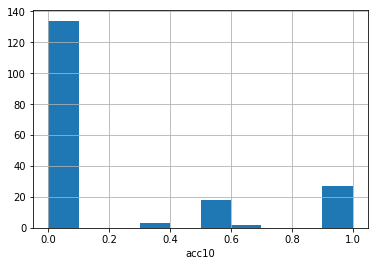

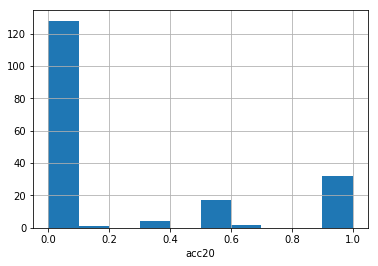

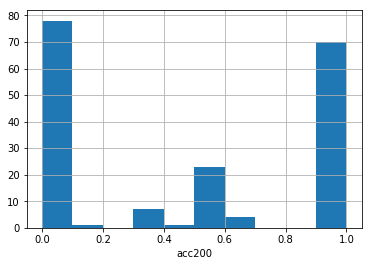

In [167]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

In [149]:
k = '59a7bc6d782b1b893a56a8b9'
print(k)
preds[k]

59a7bc6d782b1b893a56a8b9


['5984bac6b6b1134fb4638535',
 '5984ce6fb6b1132a53638538',
 '5984bab2b6b1134fcf6384f5',
 '5984b5b6b6b113067263852b',
 '5984d605b6b113780363854d',
 '5984d240b6b1134f2f638502',
 '5984b670b6b113138f63853e',
 '5984cdacb6b1132594638513',
 '5984d73db6b11301f9638504',
 '5984c78bb6b11367c4638543',
 '5984c78bb6b11367c4638542',
 '5984b7bcb6b1132865638503',
 '5984b8f1b6b1133a656384ff',
 '5984be4fb6b1137ca06384fb',
 '5984c744b6b113658e6384f4',
 '5984b81fb6b1132cab638523',
 '5984b865b6b1132fe963853c',
 '5984be01b6b11376e6638539',
 '5984c099b6b11319d2638536',
 '5984dc9cb6b1132dcb638519',
 '5984b847b6b1132ed66384ee',
 '5984b588b6b11304876384ee',
 '5984c577b6b11351b9638527',
 '5984bf7bb6b11308f263852a',
 '5984ce42b6b11328e6638541',
 '5984bf26b6b113065c6384f0',
 '5984c4c5b6b11348b66384f8',
 '5984d73cb6b113021563850b',
 '5984cdb5b6b1132595638529',
 '5984b696b6b113159b63851c',
 '5984b7a2b6b113267e63851f',
 '5984b6c5b6b11317aa63854b',
 '5984b704b6b1131ac863851e',
 '5984b90cb6b1133b70638515',
 '5984c950b6b1

In [150]:
predict([k], lim=10**9)[k].index('5984c686b6b113599c63854c')

107

# Develop

In [83]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        arr = np.array([[1,2,3], [4,5,6], [7,8,9]], dtype=np.float32)
        
        m = tf.nn.l2_normalize(arr, dim=1)
        
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[[ 0.26726124  0.53452247  0.80178368]
 [ 0.45584232  0.56980288  0.6837635 ]
 [ 0.50257069  0.57436651  0.64616233]]


In [84]:
np.array([1.,2.,3.])/np.sqrt(1+4+9)

array([ 0.26726124,  0.53452248,  0.80178373])

In [81]:
0.26726124**2 + 0.53452247**2 + 0.80178368**2

0.9999999108555808